In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Importing the databases that we need


In [3]:
# loading in statistics for college players
college_stats = pd.read_csv('all_college_data.csv')

# removing college players that were not drafted
college_stats = college_stats[college_stats['Pick'].notna()]

# dropping all the coloumns that are not going to be used in estimation
cols = ['Player', 'Pick', 'GP', 'MPG', 'WS', 'ORB', 'DRB', 'APG', 'BPG', 'SPG', 'FTM', 'FT%', '3PM', '3P%', 'TS%', 'TOV', 'eFG%', 'ORtg', 'DRtg']
college_stats = college_stats[cols]

# loading in career stats for NBA
# these include averages of culmulative season from 2009 to 2021
# not exactly career averages, but a good enough span for young players
nba_stats = pd.read_csv('NBA_data.csv')

# removing all columns except Player efficiency rating (PER) which is our target
nba_stats = nba_stats[['Player', 'PER']]

# joining college stats on player Name to add target of PER
data = college_stats.set_index('Player').join(nba_stats.set_index('Player'))
data.reset_index(inplace=True)


# making sure we have a PER for every player in our data set, remove those who don't 
data = data[data['PER'].notna()]
data = data.sort_values(by=['Player'])

data.describe()

Pick          GP         MPG          WS         ORB         DRB  \
count  372.000000  372.000000  372.000000  372.000000  372.000000  372.000000   
mean    24.838710   34.239247   31.735215    4.203226    1.998118    4.700457   
std     15.529671    2.997621    3.568275    3.771676    1.045037    1.666785   
min      1.000000   22.000000   19.100000   -0.400000    0.170000    1.700000   
25%     11.000000   32.000000   30.000000    1.200000    1.100000    3.400000   
50%     24.000000   34.000000   32.000000    3.550000    2.000000    4.500000   
75%     37.000000   37.000000   34.125000    6.300000    2.700000    5.800000   
max     60.000000   41.000000   38.400000   19.200000    5.700000   10.500000   

              APG         BPG         SPG         FTM         FT%         3PM  \
count  372.000000  372.000000  372.000000  372.000000  372.000000  372.000000   
mean     2.452608    1.013871    1.221290    3.700565    0.732871    1.091048   
std      1.627153    0.907953    0.526435    1.414923    0.090734    0.933787   
min      0.200000    0.000000    0.200000    0.760000    0.295000    0.000000   
25%      1.300000    0.300000    0.800000    2.700000    0.676750    0.200000   
50%      1.900000    0.800000    1.200000    3.500000    0.742500    0.900000   
75%      3.225000    1.400000    1.600000    4.600000    0.799250    1.900000   
max      9.750000    5.400000    3.000000    8.700000    0.974000    3.900000   

              3P%         TS%         TOV        eFG%        ORtg        DRtg  \
count  372.000000  368.000000  372.000000  368.000000  368.000000  368.000000   
mean     0.312237    0.586359    2.321183    0.548288  117.243207   94.011685   
std      0.160687    0.044760    0.631981    0.045582    7.432751    6.892420   
min      0.000000    0.488000    0.700000    0.423000   96.400000   54.300000   
25%      0.277500    0.558000    1.860000    0.515000  112.200000   89.450000   
50%      0.346000    0.582000    2.280000    0.547500  116.600000   94.000000   
75%      0.398000    0.616000    2.700000    0.577000  121.625000   98.325000   
max      1.000000    0.948000    4.400000    0.671000  140.500000  136.200000   

              PER  
count  372.000000  
mean    24.120161  
std      4.297764  
min      9.500000  
25%     21.100000  
50%     23.900000  
75%     27.000000  
max     42.300000

Cleaning the Data

In [ ]:
# filling in means for NaN values in stats
# not many NaN values, because we are taking drafted players only(i.e. high value players, which typically have complete statistics)
# therefore mean is appropriate

# we do not do this for picks over PER cause we already filter out NaN values for them
cols_to_adjust = cols[2:]


for col in cols_to_adjust:
   data[col] = data[col].fillna(data[col].mean())

data.describe() # cleaned data

Correlation Matrix

In [ ]:
corr = data.corr().abs()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

Splitting the Data

In [6]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error


# we remove pick as the goal is to determine the value of a college prospect
# therefore their draft order cannot be considered although it has a high correlation
X = data.drop(['Pick','Player', 'PER'], axis = 1)
y = data['PER']

# split the data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

X_train

GP   MPG    WS   ORB   DRB   APG   BPG   SPG   FTM    FT%   3PM    3P%  \
120  33  32.1  14.7  1.80  4.50  4.40  1.30  2.20  5.90  0.779  0.40  0.318   
258  27  35.3   4.9  3.30  7.10  1.40  0.60  0.90  7.20  0.719  0.10  0.333   
235  39  29.6  14.3  3.60  7.00  1.90  1.40  0.70  5.10  0.767  0.70  0.354   
393  37  31.5   0.2  2.60  4.50  1.30  1.10  1.60  2.10  0.658  0.80  0.316   
154  31  32.0   2.4  1.70  4.20  3.50  0.20  2.70  4.50  0.801  1.40  0.278   
..   ..   ...   ...   ...   ...   ...   ...   ...   ...    ...   ...    ...   
372  38  31.5   7.3  2.40  6.40  1.60  1.90  1.10  4.10  0.646  0.70  0.329   
221  38  27.6   1.7  2.53  5.32  2.16  1.29  1.45  1.92  0.613  0.08  0.231   
136  30  29.5   0.0  3.60  5.90  0.60  1.40  1.00  3.10  0.550  0.00  0.000   
55   30  30.4   6.4  2.90  4.60  1.90  2.10  0.60  3.00  0.788  0.10  0.600   
200  36  31.6   0.4  1.90  4.50  2.40  1.50  0.80  4.40  0.814  0.30  0.268   

       TS%   TOV   eFG%   ORtg   DRtg  
120  0.573  3.20  0.515  118.8   96.3  
258  0.567  2.40  0.500  115.0   99.0  
235  0.644  2.00  0.595  132.2   85.4  
393  0.573  1.70  0.557  116.6   88.1  
154  0.517  2.30  0.454  110.2   92.3  
..     ...   ...    ...    ...    ...  
372  0.512  2.00  0.470  108.7   89.0  
221  0.566  2.39  0.553  109.1   82.9  
136  0.560  2.50  0.556  105.8   92.9  
55   0.605  1.60  0.557  126.6  104.1  
200  0.536  2.20  0.474  112.2   93.5  

[260 rows x 17 columns]

Preprocessing Data

In [7]:
from sklearn import preprocessing

# defining an object of MinMaxScaler()
min_max_scaler = preprocessing.MinMaxScaler()

# normalize values between 0 and 1 using the training data
X_train_scaled = min_max_scaler.fit_transform(X_train)
# v shape of scaled data
X_train_scaled.shape

(260, 17)

Linear Regression

**Final Results**
MSE: 9.95 
R2: 0.37

In [9]:
from sklearn import linear_model
from sklearn.model_selection import cross_validate

# defining the model as an object of LinearRegression()
lin_model = linear_model.Lasso(alpha=0.1)

# fit the model on the scaled training data
lin_model.fit(X_train_scaled, y_train)

# calculate the coefficient of determination R^2
lin_model.score(X_train_scaled, y_train)

0.5619461713410905

In [10]:
# Model evaluation with normalization using test set 
min_max_scaler_2 = preprocessing.MinMaxScaler()

X_test_scaled = min_max_scaler_2.fit_transform(X_test)

# calculate the R^2 score
r2 = lin_model.score(X_test_scaled, y_test)
print(r2)

#Calculate mse
y_pred = lin_model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
print(mse)

0.3657821341659908
9.948034345312424


In [ ]:
# calculate the predicted values for training data
y_pred_train = lin_model.predict(X_train_scaled)

# visualize the difference between actual and predicted data using scatter plot
plt.scatter(y_train, y_pred_train)
plt.xlabel("Actual value")
plt.ylabel("Predicted value")
plt.title("Actual vs. Predicted - Train Set")
plt.show()

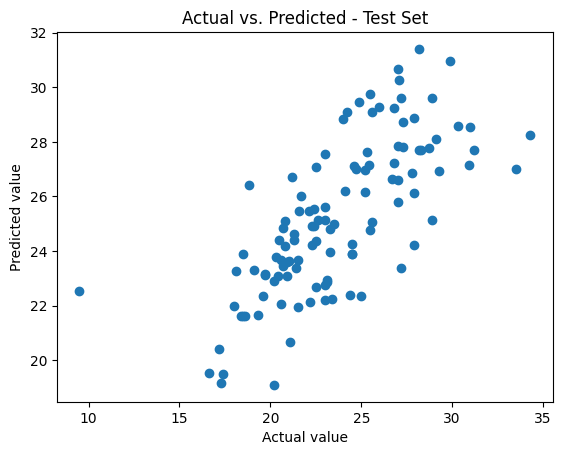

In [17]:
# calculate the predicted values for test data
y_pred_test = lin_model.predict(X_test_scaled)

# visualize the difference between actual and predicted data using scatter plot
plt.scatter(y_test, y_pred_test)
plt.xlabel("Actual value")
plt.ylabel("Predicted value")
plt.title("Actual vs. Predicted - Test Set")
plt.show()

Decision Tree: Grid Search but manually set the max depth to 6, yielded best result. MSE is 6.96 and r2 is 0.55

Decision Tree: Performed prunning and boosting. Used grid search.

**Final Results**
MSE: 7.57 
R2: 0.52

Best parameters for Decision Tree Regression: {'criterion': 'poisson', 'max_depth': 4, 'min_samples_leaf': 4, 'splitter': 'random'}
Best parameters for AdaBoost: {'learning_rate': 1, 'n_estimators': 200}
Test set performance (R^2): 0.5172188243771505
Test set performance (MSE): 7.572671750662114


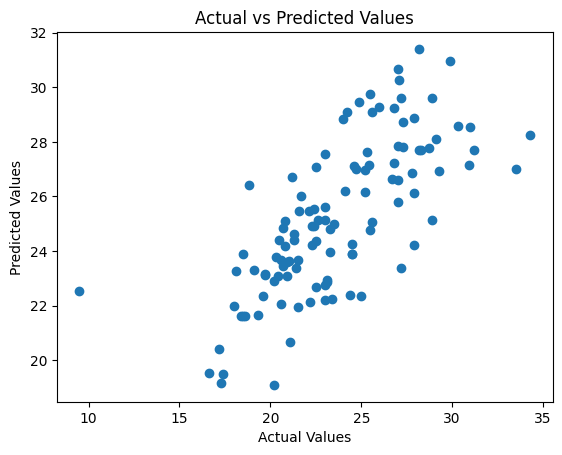

In [18]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import GridSearchCV
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#Performs Pruning to find the best maximum depth, min sample leafs, splitter and criterion for the decision tree, using Grid Search
treePruning = DecisionTreeRegressor()
param_grid_pruning = {'max_depth': [3,4,5,6,7,8],
                          'min_samples_leaf': [2,3,4,5,6,7,8],
                          'splitter': ['best', 'random'],
                          'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']} 
grid_search = GridSearchCV(treePruning, param_grid_pruning, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

#Outputs the best hyperparameters and creates a new decision tree from that
print("Best parameters for Decision Tree Regression:", grid_search.best_params_)
bestTreePruning = grid_search.best_estimator_

# Performs boosting using the AdaBoost library
# Iterates over the number of estimators and the learning rate GridSearch
ada = AdaBoostRegressor(base_estimator=bestTreePruning, random_state=42)
param_grid_lda_boosting = {'n_estimators': [50,100,150,200], 'learning_rate': [0.001,0.01,0.1,1]}
grid_search = GridSearchCV(ada, param_grid_lda_boosting, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

#Outputs the best hyperparameters (for learning rate and number of estimators) for boosting
print("Best parameters for AdaBoost:", grid_search.best_params_)
bestTreeBoosting = grid_search.best_estimator_

# Evaluates performance of the model on test set
Y_pred_test = bestTreeBoosting.predict(X_test)
r2 = r2_score(y_test, Y_pred_test)
print("Test set performance (R^2):", r2)
mse = mean_squared_error(y_test, Y_pred_test)
print("Test set performance (MSE):", mse)

# Create scatter plot of actual vs predicted values for test set
plt.scatter(y_test, y_pred_test)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

Decision Tree: Performed prunning and boosting. Used Random Search

**Final Results**
MSE: 7.90 
R2: 0.50

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
10 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/tree/_classes.py", line 1247, in fit
    super().fit(
  File "/usr/local/lib/python3.9/dist-packages/sklearn/tree/_classes.py", line 177, in fit
    self._validate_params()
  File "/usr/local/lib/python3.9/dist-packages/sklearn/base.py", line 600, in _validate_par

Best parameters for Decision Tree Regression: {'splitter': 'random', 'min_samples_leaf': 3, 'max_depth': 4, 'criterion': 'friedman_mse'}
Best parameters for AdaBoost Regression: {'n_estimators': 100, 'learning_rate': 1}
Test MSE: 7.7730
Test R^2: 0.5044


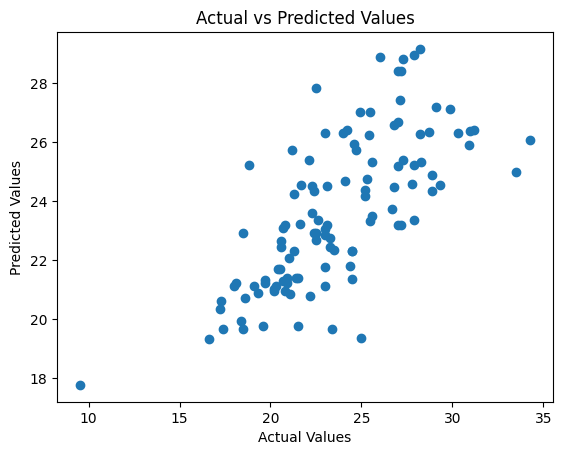

In [20]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#Performs Pruning to find the best maximum depth, min sample leafs, splitter and criterion for the decision tree, using Random Search
treePruning = DecisionTreeRegressor(random_state=0)
param_grid_pruning = {'max_depth': [3,4,5,6,7,8],
                      'min_samples_leaf': [2,3,4,5,6,7,8],
                      'splitter': ['best', 'random'],
                      'criterion': ['mse', 'friedman_mse', 'mae']} 
random_search = RandomizedSearchCV(treePruning, param_distributions=param_grid_pruning, n_iter=5, cv=5, scoring='neg_mean_squared_error', random_state=0)
random_search.fit(X_train, y_train)
print("Best parameters for Decision Tree Regression:", random_search.best_params_)
treePruning = DecisionTreeRegressor(max_depth=random_search.best_params_['max_depth'], random_state=0)

# Performs boosting using the AdaBoost library
# Iterates over the number of estimators and the learning ratemodel using RandomSearch
ada = AdaBoostRegressor(base_estimator=treePruning, random_state=0)
param = {'n_estimators': [25,50,75,100,125,150,175,200], 
         'learning_rate': [0.001,0.01,0.1,1]
         }
random_search = RandomizedSearchCV(ada, param, cv=5, scoring='neg_mean_squared_error')
random_search.fit(X_train, y_train)
print("Best parameters for AdaBoost Regression:", random_search.best_params_)

# Use the best hyperparameters to create the model
model = AdaBoostRegressor(base_estimator=treePruning, n_estimators=random_search.best_params_['n_estimators'], 
                          learning_rate=random_search.best_params_['learning_rate'], random_state=0)
model.fit(X_train, y_train)
y_pred_test = model.predict(X_test)

# Print the mean squared error and R^2 score for the test set
print('Test MSE: {0:0.4f}'. format(mean_squared_error(y_test, y_pred_test)))
print('Test R^2: {0:0.4f}'. format(r2_score(y_test, y_pred_test)))

# Create scatter plot of actual vs predicted values for test set
plt.scatter(y_test, y_pred_test)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()


Decision Tree: Performed boosting. Used Grid Search

**Final Results**
MSE: 7.35 
R2: 0.53

Best parameters for AdaBoost: {'learning_rate': 1, 'n_estimators': 150}
Test MSE: 7.3945
Test R^2: 0.5286


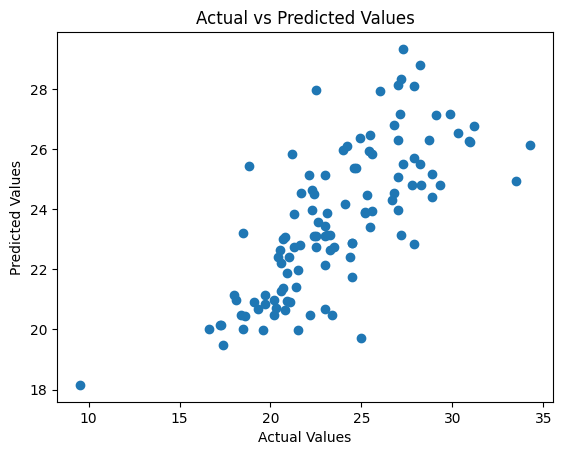

In [21]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import GridSearchCV

# Define the decision tree as the base estimator for boosting
clf = DecisionTreeRegressor(max_depth=5)

# Define the grid of hyperparameters to search over for AdaBoost
param_grid_boosting = {'n_estimators': [50, 100, 150, 200], 'learning_rate': [0.001, 0.01, 0.1, 1]}

# Perform grid search to find the best hyperparameters for AdaBoost
ada = AdaBoostRegressor(base_estimator=clf, random_state=42)
grid_search = GridSearchCV(ada, param_grid_boosting, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Output the best hyperparameters (for learning rate and number of estimators) for boosting
print("Best parameters for AdaBoost:", grid_search.best_params_)
bestTreeBoosting = grid_search.best_estimator_

# Evaluate performance of best model on test set
y_pred_test = bestTreeBoosting.predict(X_test)

# Print the mean squared error and R^2 score for the test set
print('Test MSE: {0:0.4f}'. format(mean_squared_error(y_test, y_pred_test)))
print('Test R^2: {0:0.4f}'. format(r2_score(y_test, y_pred_test)))

# Create scatter plot of actual vs predicted values for test set
plt.scatter(y_test, y_pred_test)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()


Decision Tree: Performed pruning only. Used Grid Search

**Final Results**
MSE: 11.28 
R2: 0.28

Best parameters for Decision Tree Regression (LDA): {'criterion': 'squared_error', 'max_depth': 6, 'min_samples_leaf': 6, 'splitter': 'random'}
Test set performance (R^2): 0.18529707432530274
Test set performance (MSE): 12.779035600298913


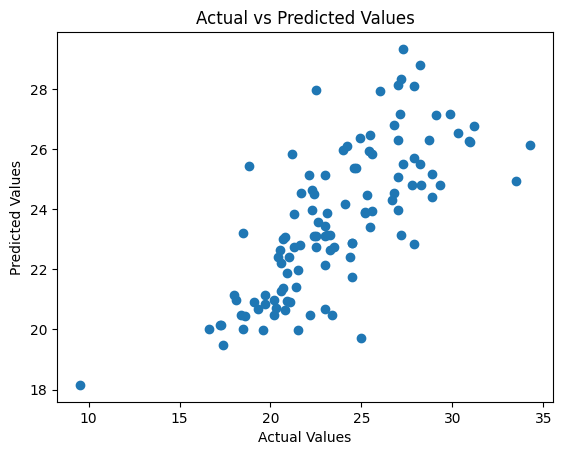

In [23]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#Performs Pruning to find the best maximum depth, minimum sample leafs, splitter, criterion for the decision tree
treeLDAPruning = DecisionTreeRegressor()
param_grid_lda_pruning = {'max_depth': [3,4,5,6,7,8],
                          'min_samples_leaf': [2,3,4,5,6,7,8],
                          'splitter': ['best', 'random'],
                          'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']} 
grid_search = GridSearchCV(treeLDAPruning, param_grid_lda_pruning, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

#Outputs value and creates the new decision tree
print("Best parameters for Decision Tree Regression (LDA):", grid_search.best_params_)
bestTreePruning = grid_search.best_estimator_

# Evaluates performance of best model on test set
Y_pred_lda = bestTreePruning.predict(X_test)
r2_lda = r2_score(y_test, Y_pred_lda)
print("Test set performance (R^2):", r2_lda)
mse_lda = mean_squared_error(y_test, Y_pred_lda)
print("Test set performance (MSE):", mse_lda)

# Create scatter plot of actual vs predicted values for test set
plt.scatter(y_test, y_pred_test)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()


MLP with Grid Search

**Final Results**
MSE: 74.78 
R2: -3.76

Fitting 5 folds for each of 2016 candidates, totalling 10080 fits
[CV 1/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-6.058 total time=   0.0s
[CV 2/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-7.452 total time=   0.0s
[CV 3/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-8.148 total time=   0.0s
[CV 4/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-4.141 total time=   0.0s
[CV 5/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-7.387 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 1/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-8.697 total time=   0.1s
[CV 2/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-9.215 total time=   0.1s
[CV 3/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-13.376 total time=   0.1s
[CV 4/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-7.504 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-7.942 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-183.899 total time=   0.1s
[CV 2/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-175.051 total time=   0.1s
[CV 3/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-341.190 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-271.608 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-213.499 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-6.033 total time=   0.0s
[CV 2/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-7.427 total time=   0.0s
[CV 3/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-8.130 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 4/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-4.154 total time=   0.0s
[CV 5/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-7.380 total time=   0.0s
[CV 1/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-9.303 total time=   0.1s
[CV 2/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-8.102 total time=   0.0s
[CV 3/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-12.781 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-9.887 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-8.076 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-307.581 total time=   0.1s
[CV 2/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-206.229 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-243.102 total time=   0.1s
[CV 4/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-263.503 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-334.001 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-6.004 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converg

[CV 2/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-7.459 total time=   0.0s
[CV 3/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-8.136 total time=   0.0s
[CV 4/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-4.149 total time=   0.0s
[CV 5/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-7.389 total time=   0.0s
[CV 1/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-44.238 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimiza

[CV 2/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-65.012 total time=   0.1s
[CV 3/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-23.385 total time=   0.1s
[CV 4/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-22.381 total time=   0.0s
[CV 5/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-170.593 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-227.451 total time=   0.1s
[CV 2/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-245.701 total time=   0.1s
[CV 3/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-267.562 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-130.377 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-182.719 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-6.058 total time=   0.0s
[CV 2/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-7.433 total time=   0.0s
[CV 3/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-8.154 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 4/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-4.164 total time=   0.0s
[CV 5/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-7.380 total time=   0.0s
[CV 1/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-8.354 total time=   0.1s
[CV 2/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-8.700 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-14.568 total time=   0.1s
[CV 4/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-6.621 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-12.605 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-313.019 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-199.234 total time=   0.1s
[CV 3/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-207.726 total time=   0.1s
[CV 4/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-205.089 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-186.197 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converg

[CV 1/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-6.061 total time=   0.0s
[CV 2/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-7.491 total time=   0.0s
[CV 3/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-8.273 total time=   0.0s
[CV 4/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-4.165 total time=   0.0s
[CV 5/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-7.368 total time=   0.0s
[CV 1/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-9.306 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimiza

[CV 2/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-8.549 total time=   0.1s
[CV 3/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-14.085 total time=   0.0s
[CV 4/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-7.964 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-8.651 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-261.750 total time=   0.1s
[CV 2/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-165.218 total time=   0.1s
[CV 3/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-240.869 total time=   0.1s
[CV 4/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-156.956 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/

[CV 5/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-191.341 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-6.085 total time=   0.0s
[CV 2/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-7.433 total time=   0.0s
[CV 3/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-8.085 total time=   0.0s
[CV 4/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-4.136 total time=   0.0s
[CV 5/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-7.539 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 1/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-73.231 total time=   0.1s
[CV 2/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-50.135 total time=   0.1s
[CV 3/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-62.882 total time=   0.1s
[CV 4/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-69.266 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-152.623 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-238.020 total time=   0.1s
[CV 2/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-179.690 total time=   0.1s
[CV 3/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-186.114 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-204.175 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-215.227 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-6.077 total time=   0.0s
[CV 2/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-7.424 total time=   0.0s
[CV 3/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-8.151 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 4/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-4.147 total time=   0.0s
[CV 5/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-7.380 total time=   0.0s
[CV 1/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-9.529 total time=   0.1s
[CV 2/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-8.707 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-12.116 total time=   0.1s
[CV 4/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-7.112 total time=   0.0s
[CV 5/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-10.104 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-216.009 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-236.656 total time=   0.1s
[CV 3/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-151.859 total time=   0.1s
[CV 4/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-174.419 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-151.637 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converg

[CV 1/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-6.063 total time=   0.0s
[CV 2/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-7.433 total time=   0.0s
[CV 3/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-8.174 total time=   0.0s
[CV 4/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-4.151 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-7.386 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimiza

[CV 1/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-9.567 total time=   0.1s
[CV 2/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-9.131 total time=   0.0s
[CV 3/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-12.848 total time=   0.1s
[CV 4/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-7.728 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-7.939 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-228.818 total time=   0.1s
[CV 2/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-176.056 total time=   0.1s
[CV 3/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-169.271 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-229.798 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-129.081 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-6.069 total time=   0.0s
[CV 2/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-7.434 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-8.151 total time=   0.2s
[CV 4/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-4.138 total time=   0.0s
[CV 5/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-7.378 total time=   0.0s
[CV 1/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-66.852 total time=   0.1s
[CV 2/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-63.832 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimiza

[CV 3/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-75.416 total time=   0.1s
[CV 4/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-52.566 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-89.698 total time=   0.0s
[CV 1/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-288.070 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-177.772 total time=   0.1s
[CV 3/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-176.669 total time=   0.1s
[CV 4/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-168.885 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-196.997 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-6.059 total time=   0.1s
[CV 2/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-7.430 total time=   0.1s
[CV 3/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-8.148 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimiza

[CV 4/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-4.179 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-7.411 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-7.932 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-7.909 total time=   0.1s
[CV 3/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-14.176 total time=   0.1s
[CV 4/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-7.689 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-8.490 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-147.584 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-182.869 total time=   0.1s
[CV 3/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-217.310 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-122.114 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-243.688 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-6.080 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-7.393 total time=   0.1s
[CV 3/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-8.142 total time=   0.1s
[CV 4/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-4.147 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-7.379 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-8.606 total time=   0.1s
[CV 2/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-8.871 total time=   0.1s
[CV 3/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-12.580 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-8.764 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-8.829 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-169.572 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-213.258 total time=   0.1s
[CV 3/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-180.246 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-181.084 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-206.422 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-6.064 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-7.443 total time=   0.1s
[CV 3/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-8.154 total time=   0.1s
[CV 4/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-4.154 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-7.380 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-71.397 total time=   0.1s
[CV 2/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-37.361 total time=   0.1s
[CV 3/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-25.602 total time=   0.0s
[CV 4/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-29.922 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-31.919 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-177.464 total time=   0.1s
[CV 2/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-163.757 total time=   0.1s
[CV 3/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-173.138 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converg

[CV 4/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-197.629 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-214.206 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-6.061 total time=   0.0s
[CV 2/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-7.421 total time=   0.0s
[CV 3/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-8.141 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimiza

[CV 4/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-4.146 total time=   0.0s
[CV 5/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-7.312 total time=   0.0s
[CV 1/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-8.336 total time=   0.0s
[CV 2/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-9.035 total time=   0.0s
[CV 3/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-13.359 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-7.123 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-9.573 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-211.115 total time=   0.1s
[CV 2/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-132.382 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/

[CV 3/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-186.751 total time=   0.1s
[CV 4/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-186.675 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-178.187 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-6.048 total time=   0.0s
[CV 2/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-7.430 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 3/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-8.101 total time=   0.1s
[CV 4/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-4.136 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-7.380 total time=   0.0s
[CV 1/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-8.404 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-8.798 total time=   0.1s
[CV 3/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-13.105 total time=   0.1s
[CV 4/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-7.394 total time=   0.0s
[CV 5/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-8.025 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-123.571 total time=   0.1s
[CV 2/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-99.812 total time=   0.1s
[CV 3/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-162.291 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converg

[CV 4/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-167.326 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-158.395 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-6.021 total time=   0.0s
[CV 2/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-7.432 total time=   0.0s
[CV 3/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-8.152 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimiza

[CV 4/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-4.146 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-7.377 total time=   0.0s
[CV 1/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-34.570 total time=   0.1s
[CV 2/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-39.335 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-33.925 total time=   0.1s
[CV 4/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-28.805 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-61.217 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-146.865 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-244.521 total time=   0.1s
[CV 3/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-235.993 total time=   0.1s
[CV 4/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-253.824 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-182.412 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 1/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-6.073 total time=   0.0s
[CV 2/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-7.432 total time=   0.0s
[CV 3/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-8.121 total time=   0.0s
[CV 4/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-4.145 total time=   0.0s
[CV 5/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-7.396 total time=   0.0s
[CV 1/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-9.177 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-10.101 total time=   0.1s
[CV 3/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-14.607 total time=   0.1s
[CV 4/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-8.598 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-7.681 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-133.121 total time=   0.1s
[CV 2/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-141.830 total time=   0.1s
[CV 3/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-177.300 total time=   0.1s
[CV 4/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-184.179 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/

[CV 5/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-189.834 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-6.058 total time=   0.0s
[CV 2/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-7.433 total time=   0.0s
[CV 3/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-8.151 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 4/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-4.147 total time=   0.0s
[CV 5/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-7.381 total time=   0.0s
[CV 1/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-8.423 total time=   0.1s
[CV 2/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-9.271 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-12.960 total time=   0.1s
[CV 4/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-7.734 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-8.786 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-197.983 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-188.729 total time=   0.1s
[CV 3/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-146.804 total time=   0.1s
[CV 4/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-146.904 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-197.430 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-6.059 total time=   0.0s
[CV 2/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-7.431 total time=   0.0s
[CV 3/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-8.122 total time=   0.0s
[CV 4/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-4.141 total time=   0.0s
[CV 5/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-7.384 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-52.352 total time=   0.1s
[CV 2/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-54.337 total time=   0.1s
[CV 3/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-41.274 total time=   0.1s
[CV 4/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-38.871 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-63.237 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-143.203 total time=   0.1s
[CV 2/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-155.828 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/

[CV 3/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-200.400 total time=   0.1s
[CV 4/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-113.893 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-156.926 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-6.065 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimiza

[CV 2/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-7.440 total time=   0.0s
[CV 3/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-8.097 total time=   0.0s
[CV 4/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-4.147 total time=   0.0s
[CV 5/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-7.380 total time=   0.0s
[CV 1/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-8.844 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-9.067 total time=   0.1s
[CV 3/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-13.628 total time=   0.1s
[CV 4/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-7.182 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-8.186 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-183.691 total time=   0.1s
[CV 2/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-163.133 total time=   0.1s
[CV 3/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-119.957 total time=   0.1s
[CV 4/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-190.100 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-123.835 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-6.062 total time=   0.0s
[CV 2/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-7.425 total time=   0.0s
[CV 3/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-8.155 total time=   0.0s
[CV 4/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-4.144 total time=   0.0s
[CV 5/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-7.378 total time=   0.0s
[CV 1/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-8.060 total time= 

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: M

[CV 4/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-7.613 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-9.232 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-125.234 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-158.306 total time=   0.1s
[CV 3/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-109.060 total time=   0.1s
[CV 4/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-129.940 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-183.380 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-6.061 total time=   0.0s
[CV 2/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-7.434 total time=   0.0s
[CV 3/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-8.149 total time=   0.0s
[CV 4/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-4.151 total time=   0.0s
[CV 5/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-7.398 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 1/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-29.744 total time=   0.1s
[CV 2/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-41.754 total time=   0.1s
[CV 3/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-43.372 total time=   0.1s
[CV 4/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-32.452 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-186.148 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-199.316 total time=   0.1s
[CV 2/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-145.884 total time=   0.1s
[CV 3/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-147.932 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-128.093 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-123.253 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-6.064 total time=   0.0s
[CV 2/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-7.437 total time=   0.0s
[CV 3/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-8.140 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 4/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-4.135 total time=   0.0s
[CV 5/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-7.511 total time=   0.0s
[CV 1/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-9.613 total time=   0.1s
[CV 2/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-8.566 total time=   0.0s
[CV 3/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-12.638 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-7.369 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-8.546 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-164.893 total time=   0.1s
[CV 2/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-319.951 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:

[CV 3/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-271.144 total time=   0.1s
[CV 4/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-292.981 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-280.149 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-6.079 total time=   0.0s
[CV 2/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-7.440 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 3/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-8.169 total time=   0.0s
[CV 4/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-4.151 total time=   0.0s
[CV 5/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-7.380 total time=   0.0s
[CV 1/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-8.443 total time=   0.1s
[CV 2/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-8.235 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-12.254 total time=   0.1s
[CV 4/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-7.611 total time=   0.0s
[CV 5/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-8.034 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-269.669 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-244.272 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-260.576 total time=   0.1s
[CV 4/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-251.037 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-246.100 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 1/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-6.058 total time=   0.0s
[CV 2/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-7.456 total time=   0.0s
[CV 3/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-8.140 total time=   0.0s
[CV 4/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-4.128 total time=   0.0s
[CV 5/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-7.392 total time=   0.0s
[CV 1/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-48.503 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-61.551 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-32.992 total time=   0.1s
[CV 4/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-48.596 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-62.121 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-267.853 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-162.107 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-222.488 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-274.022 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-253.945 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-6.086 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-7.433 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-8.153 total time=   0.1s
[CV 4/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-4.148 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-7.391 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-8.740 total time=   0.1s
[CV 2/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-8.137 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-12.405 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-6.008 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-9.002 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-255.479 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-282.313 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-158.786 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-208.121 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-280.487 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-6.184 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-7.433 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-8.176 total time=   0.1s
[CV 4/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-4.144 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-7.379 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-8.859 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-7.866 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-12.431 total time=   0.2s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-7.638 total time=   0.3s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-7.921 total time=   0.4s
[CV 1/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-212.274 total time=   0.2s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-252.915 total time=   0.2s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-256.864 total time=   0.2s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-196.602 total time=   0.3s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-181.610 total time=   0.3s
[CV 1/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-6.065 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-7.434 total time=   0.2s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-8.118 total time=   0.3s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-4.114 total time=   0.2s
[CV 5/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-7.380 total time=   0.2s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-36.013 total time=   0.4s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-297.758 total time=   0.3s
[CV 3/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-36.971 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-37.605 total time=   0.3s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-129.668 total time=   0.3s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-291.963 total time=   0.3s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-252.211 total time=   0.3s
[CV 3/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-237.112 total time=   0.2s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-199.587 total time=   0.2s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-216.657 total time=   0.4s
[CV 1/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-6.060 total time=   0.2s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-7.474 total time=   0.2s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-8.156 total time=   0.2s
[CV 4/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-4.145 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-7.385 total time=   0.2s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-9.511 total time=   0.2s
[CV 2/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-8.716 total time=   0.2s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-13.531 total time=   0.2s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-7.880 total time=   0.3s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-8.653 total time=   0.2s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-187.978 total time=   0.3s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-183.561 total time=   0.3s
[CV 3/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-111.700 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-158.901 total time=   0.2s
[CV 5/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-223.576 total time=   0.2s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 1/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-6.061 total time=   0.1s
[CV 2/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-7.424 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-8.158 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimiza

[CV 4/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-4.149 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-7.399 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-8.439 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-9.149 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-13.351 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-6.807 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-7.677 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-155.791 total time=   0.2s
[CV 2/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-199.522 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-182.756 total time=   0.2s
[CV 4/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-201.575 total time=   0.2s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-191.536 total time=   0.4s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-6.078 total time=   0.3s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-7.439 total time=   0.3s
[CV 3/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-8.125 total time=   0.1s
[CV 4/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-4.145 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-7.378 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-47.412 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-58.653 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-24.200 total time=   0.1s
[CV 4/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-65.052 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-30.109 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-268.632 total time=   0.1s
[CV 2/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-191.908 total time=   0.1s

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



[CV 3/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-236.002 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-173.172 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-206.755 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-6.040 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-7.443 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-8.150 total time=   0.1s
[CV 4/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-4.146 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-7.380 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-8.685 total time=   0.1s
[CV 2/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-7.832 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-12.843 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-6.354 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-8.732 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-183.833 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-199.906 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-169.516 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-145.601 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-167.824 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-6.062 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-7.438 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-8.151 total time=   0.1s
[CV 4/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-4.155 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-7.409 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-9.662 total time=   0.1s
[CV 2/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-8.206 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-13.064 total time=   0.0s
[CV 4/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-7.206 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-7.897 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-164.280 total time=   0.1s
[CV 2/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-210.322 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-222.901 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converg

[CV 4/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-175.374 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-263.802 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-6.061 total time=   0.0s
[CV 2/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-7.364 total time=   0.0s
[CV 3/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-8.152 total time=   0.0s
[CV 4/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-4.146 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: M

[CV 4/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-32.608 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-27.625 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-214.880 total time=   0.1s
[CV 2/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-196.836 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/

[CV 3/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-180.280 total time=   0.1s
[CV 4/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-204.760 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-190.012 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-6.063 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-7.435 total time=   0.0s
[CV 3/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-8.152 total time=   0.1s
[CV 4/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-4.143 total time=   0.0s
[CV 5/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-7.440 total time=   0.0s
[CV 1/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-8.862 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-8.583 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-12.342 total time=   0.0s
[CV 4/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-7.071 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-10.238 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-145.326 total time=   0.1s
[CV 2/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-162.982 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-217.146 total time=   0.1s
[CV 4/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-167.838 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-180.323 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-6.042 total time=   0.0s
[CV 2/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-7.433 total time=   0.0s
[CV 3/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-8.100 total time=   0.0s
[CV 4/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-4.147 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: M

[CV 5/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-7.328 total time=   0.0s
[CV 1/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-8.435 total time=   0.1s
[CV 2/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-8.704 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-13.013 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-8.615 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-8.131 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-274.780 total time=   0.1s
[CV 2/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-196.362 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/

[CV 3/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-116.978 total time=   0.1s
[CV 4/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-181.053 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-216.532 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-6.062 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-7.439 total time=   0.0s
[CV 3/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-8.145 total time=   0.0s
[CV 4/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-4.167 total time=   0.0s
[CV 5/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-7.391 total time=   0.0s
[CV 1/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-41.086 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-29.293 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-43.186 total time=   0.0s
[CV 4/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-72.131 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-31.035 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-231.922 total time=   0.1s
[CV 2/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-172.778 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-160.775 total time=   0.1s
[CV 4/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-153.364 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-159.846 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-6.057 total time=   0.0s
[CV 2/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-7.447 total time=   0.0s
[CV 3/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-8.144 total time=   0.0s
[CV 4/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-4.138 total time=   0.0s
[CV 5/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-7.374 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-8.788 total time=   0.1s
[CV 2/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-9.827 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-13.695 total time=   0.1s
[CV 4/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-7.403 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-8.136 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-183.316 total time=   0.1s
[CV 2/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-122.610 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-105.807 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converg

[CV 4/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-173.438 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-176.406 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-6.059 total time=   0.0s
[CV 2/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-7.433 total time=   0.0s
[CV 3/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-8.129 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimiza

[CV 4/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-4.150 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-7.363 total time=   0.0s
[CV 1/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-8.861 total time=   0.0s
[CV 2/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-9.012 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-12.456 total time=   0.1s
[CV 4/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-7.259 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-8.196 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-258.453 total time=   0.1s
[CV 2/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-179.203 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-150.815 total time=   0.1s
[CV 4/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-168.551 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-175.390 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-6.063 total time=   0.0s
[CV 2/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-7.439 total time=   0.0s

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC


[CV 3/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-8.130 total time=   0.0s
[CV 4/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-4.146 total time=   0.0s
[CV 5/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-7.386 total time=   0.0s
[CV 1/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-52.867 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-69.932 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-29.867 total time=   0.1s
[CV 4/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-24.419 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-51.951 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-132.625 total time=   0.1s
[CV 2/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-131.385 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-222.958 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/

[CV 4/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-132.918 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-184.889 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-6.059 total time=   0.0s
[CV 2/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-7.433 total time=   0.0s
[CV 3/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-8.151 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 4/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-4.146 total time=   0.0s
[CV 5/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-7.378 total time=   0.0s
[CV 1/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-9.712 total time=   0.1s
[CV 2/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-8.983 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-11.430 total time=   0.1s
[CV 4/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-6.687 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-8.963 total time=   0.0s
[CV 1/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-243.072 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-221.853 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-162.044 total time=   0.1s
[CV 4/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-195.819 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-120.492 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-6.059 total time=   0.0s
[CV 2/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-7.458 total time=   0.0s
[CV 3/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-8.101 total time=   0.0s
[CV 4/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-4.146 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: M

[CV 5/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-7.386 total time=   0.0s
[CV 1/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-8.368 total time=   0.1s
[CV 2/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-8.923 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-13.612 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-6.963 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-8.976 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-142.217 total time=   0.1s
[CV 2/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-138.888 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/

[CV 3/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-124.578 total time=   0.1s
[CV 4/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-185.268 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-126.518 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-6.072 total time=   0.0s
[CV 2/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-7.433 total time=   0.0s
[CV 3/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-8.168 total time=   0.0s
[CV 4/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-29.034 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-38.989 total time=   0.1s
[CV 4/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-23.160 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-37.725 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-156.816 total time=   0.1s
[CV 2/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-145.881 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-117.612 total time=   0.1s
[CV 4/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-110.728 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-100.673 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-5.988 total time=   0.0s
[CV 2/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-7.437 total time=   0.0s
[CV 3/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-8.192 total time=   0.0s
[CV 4/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-4.139 total time=   0.0s
[CV 5/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-7.377 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-8.761 total time=   0.1s
[CV 2/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-8.546 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-13.354 total time=   0.0s
[CV 4/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-7.482 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-8.437 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-178.682 total time=   0.1s
[CV 2/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-213.266 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-203.949 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-218.384 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-256.061 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-6.037 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-7.440 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-8.103 total time=   0.1s
[CV 4/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-4.146 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-7.360 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-8.842 total time=   0.1s
[CV 2/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-7.502 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-13.852 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-6.891 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-9.177 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-249.693 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-283.147 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-321.014 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-196.790 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-327.920 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-6.034 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-7.439 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-8.132 total time=   0.1s
[CV 4/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-4.144 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-7.403 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-30.353 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-41.764 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-30.928 total time=   0.1s
[CV 4/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-74.689 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-80.121 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-245.291 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-193.184 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-169.694 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-193.980 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-196.627 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-6.131 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-7.444 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-8.138 total time=   0.1s
[CV 4/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-4.143 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-7.434 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-8.410 total time=   0.1s
[CV 2/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-8.664 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-12.821 total time=   0.0s
[CV 4/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-7.193 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-9.110 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-247.611 total time=   0.1s
[CV 2/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-261.646 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-186.195 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converg

[CV 4/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-222.044 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-238.142 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-6.065 total time=   0.0s
[CV 2/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-7.433 total time=   0.0s
[CV 3/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-8.152 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimiza

[CV 4/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-4.147 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-7.381 total time=   0.0s
[CV 1/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-9.431 total time=   0.0s
[CV 2/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-9.459 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-13.155 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-7.104 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-8.088 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-238.419 total time=   0.1s
[CV 2/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-223.259 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/

[CV 3/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-166.019 total time=   0.1s
[CV 4/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-280.062 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-233.556 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-6.154 total time=   0.0s
[CV 2/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-7.527 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 3/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-7.998 total time=   0.1s
[CV 4/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-4.146 total time=   0.0s
[CV 5/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-7.438 total time=   0.0s
[CV 1/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-29.025 total time=   0.1s
[CV 2/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-55.713 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-40.986 total time=   0.1s
[CV 4/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-26.455 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-61.649 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-188.501 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-183.725 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-199.832 total time=   0.1s
[CV 4/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-201.066 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-173.888 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 1/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-6.053 total time=   0.1s
[CV 2/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-7.443 total time=   0.0s
[CV 3/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-7.990 total time=   0.0s
[CV 4/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-4.138 total time=   0.0s
[CV 5/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-7.383 total time=   0.0s
[CV 1/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-9.470 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-8.345 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-13.388 total time=   0.0s
[CV 4/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-7.247 total time=   0.0s
[CV 5/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-8.239 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-228.551 total time=   0.1s
[CV 2/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-207.183 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-288.547 total time=   0.1s
[CV 4/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-170.946 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converg

[CV 5/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-268.702 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-6.061 total time=   0.0s
[CV 2/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-7.432 total time=   0.0s
[CV 3/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-8.153 total time=   0.0s
[CV 4/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-4.159 total time=   0.0s
[CV 5/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-7.364 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimiza

[CV 1/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-8.756 total time=   0.1s
[CV 2/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-8.744 total time=   0.0s
[CV 3/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-12.662 total time=   0.1s
[CV 4/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-7.119 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-8.043 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-251.466 total time=   0.1s
[CV 2/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-159.417 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-208.900 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-273.578 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-200.929 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-6.048 total time=   0.0s
[CV 2/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-7.462 total time=   0.0s
[CV 3/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-8.151 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 4/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-4.154 total time=   0.0s
[CV 5/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-7.392 total time=   0.0s
[CV 1/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-31.866 total time=   0.1s
[CV 2/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-34.208 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-35.404 total time=   0.1s
[CV 4/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-29.722 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-140.134 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-163.501 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-281.996 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-264.623 total time=   0.1s
[CV 4/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-176.905 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/

[CV 5/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-212.711 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-6.069 total time=   0.0s
[CV 2/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-7.435 total time=   0.0s
[CV 3/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-8.123 total time=   0.0s
[CV 4/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-4.149 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 5/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-7.471 total time=   0.0s
[CV 1/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-8.351 total time=   0.1s
[CV 2/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-9.214 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-13.188 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-7.326 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-9.158 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-243.609 total time=   0.1s
[CV 2/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-178.415 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-227.010 total time=   0.1s
[CV 4/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-160.600 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-213.572 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-6.099 total time=   0.0s
[CV 2/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-7.445 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converg

[CV 3/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-8.153 total time=   0.0s
[CV 4/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-4.149 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-7.363 total time=   0.0s
[CV 1/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-8.828 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimiza

[CV 2/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-8.677 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-14.670 total time=   0.1s
[CV 4/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-9.449 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-9.842 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-211.510 total time=   0.1s
[CV 2/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-210.812 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-183.037 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-171.767 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-243.224 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-6.350 total time=   0.0s
[CV 2/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-7.434 total time=   0.0s
[CV 3/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-8.152 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 4/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-4.146 total time=   0.0s
[CV 5/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-7.377 total time=   0.0s
[CV 1/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-18.133 total time=   0.1s
[CV 2/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-46.955 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-28.797 total time=   0.1s
[CV 4/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-22.588 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-48.719 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-196.256 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-175.793 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-276.170 total time=   0.1s
[CV 4/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-207.427 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-155.650 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converg

[CV 1/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-6.075 total time=   0.0s
[CV 2/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-7.428 total time=   0.0s
[CV 3/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-8.147 total time=   0.0s
[CV 4/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-4.161 total time=   0.0s
[CV 5/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-7.379 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: M

[CV 1/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-9.079 total time=   0.1s
[CV 2/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-8.702 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-13.264 total time=   0.1s
[CV 4/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-6.901 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-9.004 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-186.798 total time=   0.1s
[CV 2/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-117.817 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-167.377 total time=   0.1s
[CV 4/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-122.651 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-230.590 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-6.056 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 2/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-7.519 total time=   0.0s
[CV 3/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-8.148 total time=   0.0s
[CV 4/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-4.158 total time=   0.0s
[CV 5/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-7.379 total time=   0.0s
[CV 1/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-9.100 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-8.526 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-12.803 total time=   0.1s
[CV 4/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-7.626 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-8.124 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-183.789 total time=   0.1s
[CV 2/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-234.755 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-159.145 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/

[CV 4/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-188.984 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-196.271 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-6.072 total time=   0.0s
[CV 2/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-7.431 total time=   0.0s
[CV 3/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-8.096 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 4/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-4.078 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-7.346 total time=   0.0s
[CV 1/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-37.332 total time=   0.1s
[CV 2/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-34.854 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-26.439 total time=   0.1s
[CV 4/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-38.078 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-23.252 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-216.718 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-179.475 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-153.421 total time=   0.1s
[CV 4/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-230.207 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-179.853 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-6.164 total time=   0.0s
[CV 2/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-7.438 total time=   0.0s
[CV 3/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-8.146 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimiza

[CV 4/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-4.135 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-7.391 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-9.900 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-8.486 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-12.435 total time=   0.1s
[CV 4/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-6.736 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-7.145 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-183.934 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-138.259 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-161.675 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-147.958 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-143.651 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-6.066 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-7.433 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-8.145 total time=   0.1s
[CV 4/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-4.141 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-7.398 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-8.893 total time=   0.1s
[CV 2/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-9.879 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-12.768 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-9.802 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-7.759 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-212.721 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-135.828 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-197.963 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-146.126 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-117.525 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-6.066 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-7.434 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-8.139 total time=   0.1s
[CV 4/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-4.147 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-7.432 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-35.517 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-28.472 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-21.288 total time=   0.1s
[CV 4/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-37.843 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-20.441 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-156.344 total time=   0.1s
[CV 2/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-167.221 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-168.829 total time=   0.1s
[CV 4/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-173.173 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-204.173 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-6.064 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converg

[CV 2/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-7.434 total time=   0.0s
[CV 3/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-8.133 total time=   0.0s
[CV 4/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-4.146 total time=   0.0s
[CV 5/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-7.371 total time=   0.0s
[CV 1/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-8.612 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: M

[CV 2/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-8.904 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-13.537 total time=   0.1s
[CV 4/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-6.743 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-7.670 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-179.619 total time=   0.1s
[CV 2/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-180.224 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-157.878 total time=   0.1s
[CV 4/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-152.402 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/

[CV 5/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-128.945 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-6.060 total time=   0.0s
[CV 2/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-7.434 total time=   0.0s
[CV 3/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-8.174 total time=   0.0s
[CV 4/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-4.146 total time=   0.0s
[CV 5/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-7.382 total time=   0.0s

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC


[CV 1/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-8.510 total time=   0.1s
[CV 2/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-8.573 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-11.811 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-7.221 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-7.658 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-196.418 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-121.496 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-164.671 total time=   0.1s
[CV 4/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-138.007 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converg

[CV 5/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-135.574 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-6.033 total time=   0.0s
[CV 2/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-7.430 total time=   0.0s
[CV 3/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-8.147 total time=   0.0s
[CV 4/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-4.146 total time=   0.0s
[CV 5/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-7.390 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimiza

[CV 1/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-68.863 total time=   0.1s
[CV 2/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-38.021 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-40.227 total time=   0.1s
[CV 4/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-26.407 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-42.704 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-129.293 total time=   0.1s
[CV 2/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-96.673 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-147.696 total time=   0.1s
[CV 4/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-122.134 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-130.234 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-6.041 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-7.437 total time=   0.0s
[CV 3/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-8.110 total time=   0.0s
[CV 4/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-4.157 total time=   0.0s
[CV 5/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-7.299 total time=   0.0s
[CV 1/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-9.394 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-9.247 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-13.083 total time=   0.1s
[CV 4/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-8.012 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-8.885 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-258.447 total time=   0.1s
[CV 2/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-242.556 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-341.199 total time=   0.1s
[CV 4/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-202.293 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-201.600 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-6.085 total time=   0.0s
[CV 2/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-7.469 total time=   0.0s
[CV 3/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-8.107 total time=   0.0s
[CV 4/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-4.168 total time=   0.0s
[CV 5/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-7.333 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-9.047 total time=   0.1s
[CV 2/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-8.646 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-12.615 total time=   0.1s
[CV 4/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-7.561 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-8.298 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-276.455 total time=   0.1s
[CV 2/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-232.982 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-329.259 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converg

[CV 4/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-210.239 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-209.845 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-6.064 total time=   0.0s
[CV 2/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-7.431 total time=   0.0s
[CV 3/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-8.172 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimiza

[CV 4/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-4.154 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-7.308 total time=   0.0s
[CV 1/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-98.739 total time=   0.1s
[CV 2/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-39.144 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-64.609 total time=   0.1s
[CV 4/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-231.259 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-24.386 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-314.380 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-229.321 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-273.967 total time=   0.1s
[CV 4/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-170.493 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-208.765 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 1/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-6.049 total time=   0.1s
[CV 2/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-7.452 total time=   0.0s
[CV 3/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-8.095 total time=   0.0s
[CV 4/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-4.149 total time=   0.0s
[CV 5/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-7.315 total time=   0.0s
[CV 1/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-8.366 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-9.552 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-13.223 total time=   0.1s
[CV 4/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-7.660 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-8.349 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-180.446 total time=   0.1s
[CV 2/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-231.538 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-192.330 total time=   0.1s
[CV 4/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-244.294 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-271.614 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-6.048 total time=   0.0s
[CV 2/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-7.437 total time=   0.0s
[CV 3/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-8.224 total time=   0.0s
[CV 4/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-4.122 total time=   0.0s
[CV 5/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-7.266 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-9.745 total time=   0.1s
[CV 2/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-8.954 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-13.062 total time=   0.1s
[CV 4/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-7.938 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-8.733 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-197.541 total time=   0.1s
[CV 2/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-177.578 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-192.464 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converg

[CV 4/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-249.056 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-254.535 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-6.056 total time=   0.0s
[CV 2/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-7.449 total time=   0.0s
[CV 3/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-8.167 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimiza

[CV 4/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-4.137 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-7.336 total time=   0.0s
[CV 1/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-30.794 total time=   0.0s
[CV 2/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-26.579 total time=   0.0s
[CV 3/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-51.017 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-31.436 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-30.924 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-220.896 total time=   0.1s
[CV 2/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-183.797 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/

[CV 3/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-228.621 total time=   0.1s
[CV 4/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-158.653 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-224.722 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-6.040 total time=   0.0s
[CV 2/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-7.438 total time=   0.0s
[CV 3/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-8.226 total time=   0.1s
[CV 4/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-4.149 total time=   0.

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-8.851 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-11.957 total time=   0.1s
[CV 4/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-6.836 total time=   0.0s
[CV 5/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-8.619 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-110.671 total time=   0.1s
[CV 2/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-263.052 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-151.822 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-190.252 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-294.706 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-6.052 total time=   0.0s
[CV 2/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-7.438 total time=   0.0s
[CV 3/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-8.050 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 4/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-4.141 total time=   0.0s
[CV 5/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-7.292 total time=   0.0s
[CV 1/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-8.942 total time=   0.1s
[CV 2/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-7.906 total time=   0.0s
[CV 3/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-13.232 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-6.474 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-9.188 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-173.466 total time=   0.1s
[CV 2/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-255.992 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:

[CV 3/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-180.478 total time=   0.1s
[CV 4/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-237.057 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-265.978 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-6.046 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-7.437 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-8.214 total time=   0.0s
[CV 4/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-4.134 total time=   0.0s
[CV 5/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-7.302 total time=   0.0s
[CV 1/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-39.298 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-37.022 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-19.802 total time=   0.1s
[CV 4/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-29.491 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-32.483 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-257.641 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-181.706 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-138.356 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-177.401 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-163.444 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-6.050 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-7.406 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-8.203 total time=   0.1s
[CV 4/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-4.137 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-7.329 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-10.495 total time=   0.1s
[CV 2/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-8.259 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-13.294 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-7.698 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-7.591 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-199.573 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-134.981 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-163.726 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-253.588 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-187.283 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-6.036 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-7.471 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-8.174 total time=   0.1s
[CV 4/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-4.137 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-7.263 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-9.796 total time=   0.1s
[CV 2/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-9.430 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-12.496 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-6.907 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-8.426 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-207.678 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-194.395 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-190.978 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converg

[CV 4/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-137.415 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-272.655 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-6.045 total time=   0.0s
[CV 2/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-7.434 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 3/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-8.220 total time=   0.1s
[CV 4/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-4.138 total time=   0.0s
[CV 5/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-7.327 total time=   0.0s
[CV 1/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-141.214 total time=   0.1s
[CV 2/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-25.784 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-27.363 total time=   0.1s
[CV 4/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-29.697 total time=   0.0s
[CV 5/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-26.227 total time=   0.0s
[CV 1/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-203.614 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-201.233 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-170.137 total time=   0.1s
[CV 4/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-133.806 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-179.594 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-6.057 total time=   0.0s
[CV 2/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-7.432 total time=   0.0s
[CV 3/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-8.149 total time=   0.0s
[CV 4/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-4.154 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: M

[CV 5/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-7.325 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-8.114 total time=   0.1s
[CV 2/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-7.712 total time=   0.0s
[CV 3/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-12.252 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-6.987 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-7.811 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-174.029 total time=   0.1s
[CV 2/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-177.404 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/

[CV 3/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-124.313 total time=   0.1s
[CV 4/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-143.866 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-166.737 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-6.070 total time=   0.0s
[CV 2/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-7.443 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 3/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-8.106 total time=   0.1s
[CV 4/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-4.146 total time=   0.0s
[CV 5/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-7.359 total time=   0.0s
[CV 1/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-8.017 total time=   0.0s
[CV 2/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-8.795 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-12.032 total time=   0.1s
[CV 4/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-6.765 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-9.050 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-182.455 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-170.279 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-171.098 total time=   0.1s
[CV 4/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-180.938 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-232.543 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 1/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-6.057 total time=   0.1s
[CV 2/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-7.422 total time=   0.0s
[CV 3/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-8.043 total time=   0.0s
[CV 4/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-4.141 total time=   0.0s
[CV 5/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-7.447 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-42.336 total time=   0.1s
[CV 2/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-39.329 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-22.099 total time=   0.1s
[CV 4/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-23.585 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-66.703 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-176.716 total time=   0.1s
[CV 2/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-138.780 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-179.951 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converg

[CV 4/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-147.395 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-202.697 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-6.084 total time=   0.0s
[CV 2/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-7.411 total time=   0.0s
[CV 3/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-8.231 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimiza

[CV 4/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-4.156 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-7.286 total time=   0.0s
[CV 1/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-8.664 total time=   0.1s
[CV 2/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-8.483 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-13.144 total time=   0.1s
[CV 4/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-6.247 total time=   0.0s
[CV 5/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-7.877 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-276.931 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-224.427 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-155.053 total time=   0.1s
[CV 4/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-162.371 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-200.623 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 1/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-6.091 total time=   0.1s
[CV 2/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-7.441 total time=   0.0s
[CV 3/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-8.320 total time=   0.0s
[CV 4/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-4.140 total time=   0.0s
[CV 5/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-7.334 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-9.243 total time=   0.1s
[CV 2/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-8.712 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-13.337 total time=   0.1s
[CV 4/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-7.691 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-8.376 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-184.737 total time=   0.1s
[CV 2/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-151.125 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-169.497 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converg

[CV 4/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-144.012 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-261.457 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-6.036 total time=   0.0s
[CV 2/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-7.436 total time=   0.0s
[CV 3/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-8.100 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimiza

[CV 4/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-4.131 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-7.313 total time=   0.0s
[CV 1/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-34.655 total time=   0.1s
[CV 2/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-69.134 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-29.199 total time=   0.1s
[CV 4/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-73.570 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-36.903 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-180.437 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-151.478 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-181.586 total time=   0.1s
[CV 4/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-139.370 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converg

[CV 5/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-168.738 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-6.064 total time=   0.0s
[CV 2/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-7.443 total time=   0.0s
[CV 3/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-8.178 total time=   0.0s
[CV 4/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-4.162 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimiza

[CV 5/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-7.320 total time=   0.0s
[CV 1/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-7.893 total time=   0.1s
[CV 2/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-8.747 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-11.824 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-6.398 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-8.526 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-115.720 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-163.349 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-130.791 total time=   0.1s
[CV 4/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-183.113 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-127.965 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 1/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-6.073 total time=   0.1s
[CV 2/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-7.396 total time=   0.0s
[CV 3/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-8.233 total time=   0.0s
[CV 4/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-4.151 total time=   0.0s
[CV 5/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-7.449 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-10.461 total time=   0.1s
[CV 2/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-8.382 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-12.178 total time=   0.1s
[CV 4/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-8.008 total time=   0.0s
[CV 5/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-8.265 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-161.417 total time=   0.1s
[CV 2/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-154.214 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-101.727 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/

[CV 4/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-124.285 total time=   0.1s
[CV 5/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-169.200 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-6.210 total time=   0.0s
[CV 2/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-7.436 total time=   0.0s
[CV 3/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-8.187 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 4/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-4.135 total time=   0.0s
[CV 5/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-7.337 total time=   0.0s
[CV 1/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-38.524 total time=   0.1s
[CV 2/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-65.320 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-38.870 total time=   0.1s
[CV 4/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-53.602 total time=   0.0s
[CV 5/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-63.804 total time=   0.1s
[CV 1/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-130.747 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-148.932 total time=   0.1s
[CV 3/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-131.899 total time=   0.1s
[CV 4/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-111.767 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-174.463 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-6.021 total time=   0.0s
[CV 2/5] END activation=identity, alpha=1, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-7.476 total time=   0.0s
[CV 3/5] END activation=identity, alpha=1, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-8.258 total time=   0.0s
[CV 4/5] END activation=identity, alpha=1, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-4.164 total time=   0.0s
[CV 5/5] END activation=identity, alpha=1, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-7.053 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=identity, alpha=1, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-8.312 total time=   0.1s
[CV 2/5] END activation=identity, alpha=1, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-9.250 total time=   0.0s
[CV 3/5] END activation=identity, alpha=1, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-12.639 total time=   0.1s
[CV 4/5] END activation=identity, alpha=1, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-6.662 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=identity, alpha=1, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-8.780 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-212.778 total time=   0.1s
[CV 2/5] END activation=identity, alpha=1, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-172.384 total time=   0.1s
[CV 3/5] END activation=identity, alpha=1, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-189.939 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converg

[CV 4/5] END activation=identity, alpha=1, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-189.726 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-345.231 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-6.047 total time=   0.0s
[CV 2/5] END activation=identity, alpha=1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-7.430 total time=   0.0s
[CV 3/5] END activation=identity, alpha=1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-8.234 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimiza

[CV 4/5] END activation=identity, alpha=1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-4.143 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-7.040 total time=   0.0s
[CV 1/5] END activation=identity, alpha=1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-8.317 total time=   0.1s
[CV 2/5] END activation=identity, alpha=1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-9.247 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=identity, alpha=1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-12.416 total time=   0.1s
[CV 4/5] END activation=identity, alpha=1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-6.564 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-8.848 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=identity, alpha=1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-242.194 total time=   0.1s
[CV 2/5] END activation=identity, alpha=1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-317.102 total time=   0.1s
[CV 3/5] END activation=identity, alpha=1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-162.884 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=identity, alpha=1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-252.064 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-174.012 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-5.979 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=identity, alpha=1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-7.403 total time=   0.1s
[CV 3/5] END activation=identity, alpha=1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-8.152 total time=   0.1s
[CV 4/5] END activation=identity, alpha=1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-4.140 total time=   0.0s
[CV 5/5] END activation=identity, alpha=1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-7.078 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=identity, alpha=1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-65.701 total time=   0.1s
[CV 2/5] END activation=identity, alpha=1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-55.557 total time=   0.1s
[CV 3/5] END activation=identity, alpha=1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-41.294 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=identity, alpha=1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-63.070 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-30.096 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-297.865 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-197.532 total time=   0.1s
[CV 3/5] END activation=identity, alpha=1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-168.725 total time=   0.1s
[CV 4/5] END activation=identity, alpha=1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-266.286 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=identity, alpha=1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-251.344 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-6.008 total time=   0.1s
[CV 2/5] END activation=identity, alpha=1, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-7.439 total time=   0.1s
[CV 3/5] END activation=identity, alpha=1, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-8.384 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimiza

[CV 4/5] END activation=identity, alpha=1, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-4.113 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-7.055 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-8.281 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=1, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-8.422 total time=   0.1s
[CV 3/5] END activation=identity, alpha=1, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-14.219 total time=   0.1s
[CV 4/5] END activation=identity, alpha=1, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-7.601 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=identity, alpha=1, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-8.262 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-347.859 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=1, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-181.260 total time=   0.1s
[CV 3/5] END activation=identity, alpha=1, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-208.095 total time=   0.1s
[CV 4/5] END activation=identity, alpha=1, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-183.949 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-287.863 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-6.002 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 2/5] END activation=identity, alpha=1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-7.427 total time=   0.1s
[CV 3/5] END activation=identity, alpha=1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-8.101 total time=   0.1s
[CV 4/5] END activation=identity, alpha=1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-4.164 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-7.128 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimiza

[CV 1/5] END activation=identity, alpha=1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-8.775 total time=   0.1s
[CV 2/5] END activation=identity, alpha=1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-9.194 total time=   0.1s
[CV 3/5] END activation=identity, alpha=1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-12.318 total time=   0.1s
[CV 4/5] END activation=identity, alpha=1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-6.840 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=identity, alpha=1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-8.006 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-241.669 total time=   0.1s
[CV 2/5] END activation=identity, alpha=1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-247.567 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=identity, alpha=1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-239.017 total time=   0.1s
[CV 4/5] END activation=identity, alpha=1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-163.171 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-208.040 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-6.002 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=identity, alpha=1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-7.479 total time=   0.0s
[CV 3/5] END activation=identity, alpha=1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-8.057 total time=   0.0s
[CV 4/5] END activation=identity, alpha=1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-4.190 total time=   0.0s
[CV 5/5] END activation=identity, alpha=1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-7.086 total time=   0.0s
[CV 1/5] END activation=identity, alpha=1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-38.494 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-213.301 total time=   0.1s
[CV 3/5] END activation=identity, alpha=1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-55.423 total time=   0.1s
[CV 4/5] END activation=identity, alpha=1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-19.657 total time=   0.0s
[CV 5/5] END activation=identity, alpha=1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-67.165 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=identity, alpha=1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-231.868 total time=   0.1s
[CV 2/5] END activation=identity, alpha=1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-278.381 total time=   0.1s
[CV 3/5] END activation=identity, alpha=1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-238.533 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/

[CV 4/5] END activation=identity, alpha=1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-190.832 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-265.092 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-6.018 total time=   0.0s
[CV 2/5] END activation=identity, alpha=1, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-7.440 total time=   0.0s
[CV 3/5] END activation=identity, alpha=1, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-8.265 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 4/5] END activation=identity, alpha=1, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-4.165 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-7.086 total time=   0.0s
[CV 1/5] END activation=identity, alpha=1, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-8.973 total time=   0.1s
[CV 2/5] END activation=identity, alpha=1, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-8.258 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=identity, alpha=1, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-13.977 total time=   0.1s
[CV 4/5] END activation=identity, alpha=1, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-6.979 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-7.866 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=identity, alpha=1, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-232.100 total time=   0.1s
[CV 2/5] END activation=identity, alpha=1, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-165.667 total time=   0.1s
[CV 3/5] END activation=identity, alpha=1, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-256.531 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converg

[CV 4/5] END activation=identity, alpha=1, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-201.245 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-284.406 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-5.990 total time=   0.0s
[CV 2/5] END activation=identity, alpha=1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-7.398 total time=   0.0s
[CV 3/5] END activation=identity, alpha=1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-8.211 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimiza

[CV 4/5] END activation=identity, alpha=1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-4.147 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-7.074 total time=   0.0s
[CV 1/5] END activation=identity, alpha=1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-8.564 total time=   0.0s
[CV 2/5] END activation=identity, alpha=1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-9.033 total time=   0.0s
[CV 3/5] END activation=identity, alpha=1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-13.791 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=identity, alpha=1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-7.482 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-8.045 total time=   0.0s
[CV 1/5] END activation=identity, alpha=1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-250.165 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-179.262 total time=   0.1s
[CV 3/5] END activation=identity, alpha=1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-186.294 total time=   0.1s
[CV 4/5] END activation=identity, alpha=1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-126.300 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-174.568 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 1/5] END activation=identity, alpha=1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-6.013 total time=   0.1s
[CV 2/5] END activation=identity, alpha=1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-7.458 total time=   0.1s
[CV 3/5] END activation=identity, alpha=1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-8.263 total time=   0.0s
[CV 4/5] END activation=identity, alpha=1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-4.180 total time=   0.0s
[CV 5/5] END activation=identity, alpha=1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-6.973 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=identity, alpha=1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-97.455 total time=   0.1s
[CV 2/5] END activation=identity, alpha=1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-80.357 total time=   0.1s
[CV 3/5] END activation=identity, alpha=1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-25.314 total time=   0.1s
[CV 4/5] END activation=identity, alpha=1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-28.088 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=identity, alpha=1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-68.346 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-174.270 total time=   0.1s
[CV 2/5] END activation=identity, alpha=1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-175.457 total time=   0.1s
[CV 3/5] END activation=identity, alpha=1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-223.185 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converg

[CV 4/5] END activation=identity, alpha=1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-190.094 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-151.028 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-5.999 total time=   0.0s
[CV 2/5] END activation=identity, alpha=1, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-7.416 total time=   0.0s
[CV 3/5] END activation=identity, alpha=1, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-8.240 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimiza

[CV 4/5] END activation=identity, alpha=1, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-4.159 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-7.018 total time=   0.0s
[CV 1/5] END activation=identity, alpha=1, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-9.143 total time=   0.1s
[CV 2/5] END activation=identity, alpha=1, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-8.809 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=identity, alpha=1, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-12.871 total time=   0.1s
[CV 4/5] END activation=identity, alpha=1, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-6.793 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-9.018 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-235.080 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=1, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-194.964 total time=   0.1s
[CV 3/5] END activation=identity, alpha=1, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-221.340 total time=   0.1s
[CV 4/5] END activation=identity, alpha=1, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-199.868 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=identity, alpha=1, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-170.931 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-6.028 total time=   0.1s
[CV 2/5] END activation=identity, alpha=1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-7.502 total time=   0.1s
[CV 3/5] END activation=identity, alpha=1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-8.264 total time=   0.0s
[CV 4/5] END activation=identity, alpha=1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-4.170 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: M

[CV 5/5] END activation=identity, alpha=1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-7.124 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-8.685 total time=   0.1s
[CV 2/5] END activation=identity, alpha=1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-8.790 total time=   0.1s
[CV 3/5] END activation=identity, alpha=1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-12.861 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=identity, alpha=1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-6.712 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-8.305 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-181.245 total time=   0.1s
[CV 2/5] END activation=identity, alpha=1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-206.826 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/

[CV 3/5] END activation=identity, alpha=1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-109.550 total time=   0.1s
[CV 4/5] END activation=identity, alpha=1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-88.269 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-144.510 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-6.037 total time=   0.0s
[CV 2/5] END activation=identity, alpha=1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-7.375 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 3/5] END activation=identity, alpha=1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-8.265 total time=   0.1s
[CV 4/5] END activation=identity, alpha=1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-4.197 total time=   0.0s
[CV 5/5] END activation=identity, alpha=1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-7.158 total time=   0.0s
[CV 1/5] END activation=identity, alpha=1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-49.329 total time=   0.1s
[CV 2/5] END activation=identity, alpha=1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-102.842 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=identity, alpha=1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-36.013 total time=   0.1s
[CV 4/5] END activation=identity, alpha=1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-52.374 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-60.517 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-208.828 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-147.625 total time=   0.1s
[CV 3/5] END activation=identity, alpha=1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-193.159 total time=   0.1s
[CV 4/5] END activation=identity, alpha=1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-171.004 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-146.635 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 1/5] END activation=identity, alpha=1, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-6.015 total time=   0.1s
[CV 2/5] END activation=identity, alpha=1, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-7.549 total time=   0.0s
[CV 3/5] END activation=identity, alpha=1, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-8.303 total time=   0.0s
[CV 4/5] END activation=identity, alpha=1, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-4.183 total time=   0.0s
[CV 5/5] END activation=identity, alpha=1, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-7.140 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=identity, alpha=1, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-8.284 total time=   0.1s
[CV 2/5] END activation=identity, alpha=1, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-9.241 total time=   0.1s
[CV 3/5] END activation=identity, alpha=1, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-13.515 total time=   0.0s
[CV 4/5] END activation=identity, alpha=1, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-6.937 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=identity, alpha=1, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-8.280 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-168.656 total time=   0.1s
[CV 2/5] END activation=identity, alpha=1, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-159.312 total time=   0.1s
[CV 3/5] END activation=identity, alpha=1, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-118.537 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/

[CV 4/5] END activation=identity, alpha=1, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-183.198 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-213.622 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-6.041 total time=   0.0s
[CV 2/5] END activation=identity, alpha=1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-7.473 total time=   0.0s
[CV 3/5] END activation=identity, alpha=1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-8.273 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 4/5] END activation=identity, alpha=1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-4.181 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-7.114 total time=   0.0s
[CV 1/5] END activation=identity, alpha=1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-8.253 total time=   0.1s
[CV 2/5] END activation=identity, alpha=1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-9.190 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=identity, alpha=1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-13.757 total time=   0.1s
[CV 4/5] END activation=identity, alpha=1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-6.827 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-8.639 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-221.925 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-143.532 total time=   0.1s
[CV 3/5] END activation=identity, alpha=1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-172.327 total time=   0.1s
[CV 4/5] END activation=identity, alpha=1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-127.027 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/

[CV 5/5] END activation=identity, alpha=1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-194.935 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-5.934 total time=   0.0s
[CV 2/5] END activation=identity, alpha=1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-7.418 total time=   0.0s
[CV 3/5] END activation=identity, alpha=1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-8.359 total time=   0.0s
[CV 4/5] END activation=identity, alpha=1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-4.158 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 5/5] END activation=identity, alpha=1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-7.024 total time=   0.0s
[CV 1/5] END activation=identity, alpha=1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-63.438 total time=   0.1s
[CV 2/5] END activation=identity, alpha=1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-20.861 total time=   0.1s
[CV 3/5] END activation=identity, alpha=1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-90.880 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=identity, alpha=1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-45.490 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-44.346 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-157.581 total time=   0.1s
[CV 2/5] END activation=identity, alpha=1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-156.407 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=identity, alpha=1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-136.552 total time=   0.1s
[CV 4/5] END activation=identity, alpha=1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-228.232 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-213.183 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-5.982 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 2/5] END activation=identity, alpha=1, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-7.476 total time=   0.0s
[CV 3/5] END activation=identity, alpha=1, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-8.304 total time=   0.1s
[CV 4/5] END activation=identity, alpha=1, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-4.221 total time=   0.0s
[CV 5/5] END activation=identity, alpha=1, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-7.008 total time=   0.0s
[CV 1/5] END activation=identity, alpha=1, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-9.234 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=identity, alpha=1, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-9.590 total time=   0.1s
[CV 3/5] END activation=identity, alpha=1, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-13.053 total time=   0.1s
[CV 4/5] END activation=identity, alpha=1, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-7.261 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=identity, alpha=1, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-7.897 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-133.416 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=1, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-130.973 total time=   0.1s
[CV 3/5] END activation=identity, alpha=1, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-154.651 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=identity, alpha=1, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-116.102 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-161.069 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-6.016 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 2/5] END activation=identity, alpha=1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-7.457 total time=   0.1s
[CV 3/5] END activation=identity, alpha=1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-8.242 total time=   0.1s
[CV 4/5] END activation=identity, alpha=1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-4.208 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-7.040 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimiza

[CV 1/5] END activation=identity, alpha=1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-8.242 total time=   0.1s
[CV 2/5] END activation=identity, alpha=1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-9.052 total time=   0.1s
[CV 3/5] END activation=identity, alpha=1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-13.050 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=identity, alpha=1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-6.923 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-10.159 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-195.224 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-158.098 total time=   0.1s
[CV 3/5] END activation=identity, alpha=1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-165.899 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=identity, alpha=1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-144.972 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-207.473 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-6.043 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=identity, alpha=1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-7.442 total time=   0.1s
[CV 3/5] END activation=identity, alpha=1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-8.350 total time=   0.1s
[CV 4/5] END activation=identity, alpha=1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-4.168 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-7.080 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=identity, alpha=1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-29.739 total time=   0.1s
[CV 2/5] END activation=identity, alpha=1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-41.081 total time=   0.1s
[CV 3/5] END activation=identity, alpha=1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-63.850 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=identity, alpha=1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-35.873 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-135.503 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-190.206 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-169.626 total time=   0.1s
[CV 3/5] END activation=identity, alpha=1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-226.233 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=identity, alpha=1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-124.949 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-204.559 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-6.079 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=identity, alpha=1, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-7.461 total time=   0.1s
[CV 3/5] END activation=identity, alpha=1, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-8.356 total time=   0.1s
[CV 4/5] END activation=identity, alpha=1, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-4.162 total time=   0.0s
[CV 5/5] END activation=identity, alpha=1, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-7.030 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=identity, alpha=1, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-9.270 total time=   0.1s
[CV 2/5] END activation=identity, alpha=1, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-8.360 total time=   0.1s
[CV 3/5] END activation=identity, alpha=1, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-13.332 total time=   0.1s
[CV 4/5] END activation=identity, alpha=1, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-7.019 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=identity, alpha=1, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-8.128 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-230.207 total time=   0.1s
[CV 2/5] END activation=identity, alpha=1, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-183.758 total time=   0.1s
[CV 3/5] END activation=identity, alpha=1, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-171.957 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converg

[CV 4/5] END activation=identity, alpha=1, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-235.751 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-179.096 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-5.981 total time=   0.0s
[CV 2/5] END activation=identity, alpha=1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-7.430 total time=   0.0s
[CV 3/5] END activation=identity, alpha=1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-8.402 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimiza

[CV 4/5] END activation=identity, alpha=1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-4.138 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-7.112 total time=   0.0s
[CV 1/5] END activation=identity, alpha=1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-8.602 total time=   0.1s
[CV 2/5] END activation=identity, alpha=1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-9.268 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=identity, alpha=1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-13.049 total time=   0.1s
[CV 4/5] END activation=identity, alpha=1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-5.952 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-7.562 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-148.910 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-121.425 total time=   0.1s
[CV 3/5] END activation=identity, alpha=1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-124.740 total time=   0.1s
[CV 4/5] END activation=identity, alpha=1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-106.693 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=identity, alpha=1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-150.184 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-6.031 total time=   0.0s
[CV 2/5] END activation=identity, alpha=1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-7.424 total time=   0.0s
[CV 3/5] END activation=identity, alpha=1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-8.188 total time=   0.0s
[CV 4/5] END activation=identity, alpha=1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-4.163 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: M

[CV 5/5] END activation=identity, alpha=1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-7.175 total time=   0.0s
[CV 1/5] END activation=identity, alpha=1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-61.298 total time=   0.1s
[CV 2/5] END activation=identity, alpha=1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-56.065 total time=   0.1s
[CV 3/5] END activation=identity, alpha=1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-107.020 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=identity, alpha=1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-36.036 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-38.378 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-97.664 total time=   0.1s
[CV 2/5] END activation=identity, alpha=1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-140.149 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=identity, alpha=1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-189.963 total time=   0.1s
[CV 4/5] END activation=identity, alpha=1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-86.441 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-167.293 total time=   0.1s
[CV 1/5] END activation=identity, alpha=10, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-6.454 total time=   0.0s
[CV 2/5] END activation=identity, alpha=10, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-7.740 total time=   0.0s
[CV 3/5] END activation=identity, alpha=10, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-9.045 total time=   0.1s
[CV 4/5] END activation=identity, alpha=10, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-4.493 total time=   0.0s
[CV 5/5]

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=identity, alpha=10, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-14.294 total time=   0.1s
[CV 4/5] END activation=identity, alpha=10, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-6.367 total time=   0.0s
[CV 5/5] END activation=identity, alpha=10, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-9.678 total time=   0.1s
[CV 1/5] END activation=identity, alpha=10, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-268.984 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=10, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-193.446 total time=   0.1s
[CV 3/5] END activation=identity, alpha=10, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-286.180 total time=   0.1s
[CV 4/5] END activation=identity, alpha=10, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-176.679 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/

[CV 5/5] END activation=identity, alpha=10, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-249.218 total time=   0.1s
[CV 1/5] END activation=identity, alpha=10, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-6.454 total time=   0.0s
[CV 2/5] END activation=identity, alpha=10, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-7.740 total time=   0.1s
[CV 3/5] END activation=identity, alpha=10, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-9.046 total time=   0.0s
[CV 4/5] END activation=identity, alpha=10, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-4.494 total time=   0.0s
[CV 5/5] END activation=identity, alpha=10, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-6.463 total time=   0.0s
[CV 1/5] END activation=identity, alpha=10, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-9.830 total time=   0.1s
[CV 2/5] END a

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=identity, alpha=10, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-6.995 total time=   0.1s
[CV 5/5] END activation=identity, alpha=10, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-9.974 total time=   0.1s
[CV 1/5] END activation=identity, alpha=10, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-275.789 total time=   0.1s
[CV 2/5] END activation=identity, alpha=10, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-282.534 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:

[CV 3/5] END activation=identity, alpha=10, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-248.531 total time=   0.1s
[CV 4/5] END activation=identity, alpha=10, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-214.447 total time=   0.1s
[CV 5/5] END activation=identity, alpha=10, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-266.187 total time=   0.1s
[CV 1/5] END activation=identity, alpha=10, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-6.455 total time=   0.0s
[CV 2/5] END activation=identity, alpha=10, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-7.740 total time=   0.0s
[CV 3/5] END activation=identity, alpha=10, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-9.045 total time=   0.0s
[CV 4/5] END activation=identity, alpha=10, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-4.494 total time=   0.0s
[C

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: M

[CV 2/5] END activation=identity, alpha=10, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-43.528 total time=   0.1s
[CV 3/5] END activation=identity, alpha=10, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-60.443 total time=   0.1s
[CV 4/5] END activation=identity, alpha=10, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-48.412 total time=   0.1s
[CV 5/5] END activation=identity, alpha=10, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-100.333 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=identity, alpha=10, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-206.230 total time=   0.1s
[CV 2/5] END activation=identity, alpha=10, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-225.924 total time=   0.1s
[CV 3/5] END activation=identity, alpha=10, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-255.702 total time=   0.1s
[CV 4/5] END activation=identity, alpha=10, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-196.058 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/

[CV 5/5] END activation=identity, alpha=10, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-285.243 total time=   0.1s
[CV 1/5] END activation=identity, alpha=10, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-6.454 total time=   0.0s
[CV 2/5] END activation=identity, alpha=10, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-7.740 total time=   0.0s
[CV 3/5] END activation=identity, alpha=10, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-9.045 total time=   0.1s
[CV 4/5] END activation=identity, alpha=10, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-4.494 total time=   0.0s
[CV 5/5] END activation=identity, alpha=10, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-6.463 total time=   0.0s
[CV 1/5] END activation=identity, alpha=10, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-11.186 total time=   0.1s
[CV 2/5] EN

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=identity, alpha=10, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-9.319 total time=   0.1s
[CV 1/5] END activation=identity, alpha=10, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-170.487 total time=   0.1s
[CV 2/5] END activation=identity, alpha=10, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-284.217 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=identity, alpha=10, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-158.925 total time=   0.1s
[CV 4/5] END activation=identity, alpha=10, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-217.677 total time=   0.1s
[CV 5/5] END activation=identity, alpha=10, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-263.312 total time=   0.1s
[CV 1/5] END activation=identity, alpha=10, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-6.455 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=10, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-7.741 total time=   0.1s
[CV 3/5] END activation=identity, alpha=10, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-9.046 total time=   0.0s
[CV 4/5] END activation=identity, alpha=10, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-4.494 total time=   0.0s
[CV 5/5] END activation=identity, alpha=10, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-6.463 total time=   0.0s
[CV 1/5] END activation=identity, alpha=10, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-10.222 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: M

[CV 2/5] END activation=identity, alpha=10, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-11.366 total time=   0.1s
[CV 3/5] END activation=identity, alpha=10, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-14.690 total time=   0.1s
[CV 4/5] END activation=identity, alpha=10, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-6.847 total time=   0.1s
[CV 5/5] END activation=identity, alpha=10, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-9.089 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=identity, alpha=10, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-182.350 total time=   0.1s
[CV 2/5] END activation=identity, alpha=10, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-208.565 total time=   0.1s
[CV 3/5] END activation=identity, alpha=10, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-217.828 total time=   0.1s
[CV 4/5] END activation=identity, alpha=10, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-212.694 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=identity, alpha=10, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-239.565 total time=   0.1s
[CV 1/5] END activation=identity, alpha=10, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-6.454 total time=   0.0s
[CV 2/5] END activation=identity, alpha=10, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-7.739 total time=   0.0s
[CV 3/5] END activation=identity, alpha=10, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-9.045 total time=   0.0s
[CV 4/5] END activation=identity, alpha=10, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-4.494 total time=   0.0s
[CV 5/5] END activation=identity, alpha=10, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-6.463 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=identity, alpha=10, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-53.946 total time=   0.1s
[CV 2/5] END activation=identity, alpha=10, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-36.925 total time=   0.1s
[CV 3/5] END activation=identity, alpha=10, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-55.730 total time=   0.0s
[CV 4/5] END activation=identity, alpha=10, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-45.243 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=identity, alpha=10, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-59.197 total time=   0.1s
[CV 1/5] END activation=identity, alpha=10, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-210.701 total time=   0.1s
[CV 2/5] END activation=identity, alpha=10, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-187.345 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=identity, alpha=10, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-148.265 total time=   0.1s
[CV 4/5] END activation=identity, alpha=10, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-143.543 total time=   0.1s
[CV 5/5] END activation=identity, alpha=10, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-249.790 total time=   0.1s
[CV 1/5] END activation=identity, alpha=10, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-6.454 total time=   0.0s
[CV 2/5] END activation=identity, alpha=10, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-7.739 total time=   0.0s
[CV 3/5] END activation=identity, alpha=10, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-9.045 total time=   0.1s
[CV 4/5] END activation=identity, alpha=10, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-4.493 total time=   0.0s
[CV 

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=10, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-11.465 total time=   0.1s
[CV 3/5] END activation=identity, alpha=10, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-14.176 total time=   0.1s
[CV 4/5] END activation=identity, alpha=10, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-10.005 total time=   0.1s
[CV 5/5] END activation=identity, alpha=10, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-10.286 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=identity, alpha=10, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-173.095 total time=   0.1s
[CV 2/5] END activation=identity, alpha=10, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-258.708 total time=   0.1s
[CV 3/5] END activation=identity, alpha=10, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-207.789 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=identity, alpha=10, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-221.869 total time=   0.1s
[CV 5/5] END activation=identity, alpha=10, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-211.440 total time=   0.1s
[CV 1/5] END activation=identity, alpha=10, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-6.455 total time=   0.0s
[CV 2/5] END activation=identity, alpha=10, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-7.739 total time=   0.0s
[CV 3/5] END activation=identity, alpha=10, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-9.046 total time=   0.0s
[CV 4/5] END activation=identity, alpha=10, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-4.494 total time=   0.0s
[CV 5/5] END activation=identity, alpha=10, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-6.463 total time=   0.0s
[CV 1/5] EN

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=identity, alpha=10, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-6.753 total time=   0.1s
[CV 5/5] END activation=identity, alpha=10, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-9.085 total time=   0.1s
[CV 1/5] END activation=identity, alpha=10, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-257.332 total time=   0.1s
[CV 2/5] END activation=identity, alpha=10, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-220.565 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:

[CV 3/5] END activation=identity, alpha=10, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-151.860 total time=   0.1s
[CV 4/5] END activation=identity, alpha=10, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-226.460 total time=   0.1s
[CV 5/5] END activation=identity, alpha=10, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-240.754 total time=   0.1s
[CV 1/5] END activation=identity, alpha=10, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-6.455 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=10, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-7.740 total time=   0.1s
[CV 3/5] END activation=identity, alpha=10, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-9.046 total time=   0.0s
[CV 4/5] END activation=identity, alpha=10, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-4.494 total time=   0.0s
[CV 5/5] END activation=identity, alpha=10, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-6.463 total time=   0.0s
[CV 1/5] END activation=identity, alpha=10, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-84.360 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=10, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-23.994 total time=   0.1s
[CV 3/5] END activation=identity, alpha=10, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-29.451 total time=   0.1s
[CV 4/5] END activation=identity, alpha=10, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-118.367 total time=   0.0s
[CV 5/5] END activation=identity, alpha=10, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-168.401 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=identity, alpha=10, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-211.143 total time=   0.1s
[CV 2/5] END activation=identity, alpha=10, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-181.085 total time=   0.1s
[CV 3/5] END activation=identity, alpha=10, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-180.135 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=identity, alpha=10, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-169.480 total time=   0.1s
[CV 5/5] END activation=identity, alpha=10, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-224.841 total time=   0.1s
[CV 1/5] END activation=identity, alpha=10, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-6.454 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/5] END activation=identity, alpha=10, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-7.740 total time=   0.1s
[CV 3/5] END activation=identity, alpha=10, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-9.046 total time=   0.1s
[CV 4/5] END activation=identity, alpha=10, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-4.493 total time=   0.1s
[CV 5/5] END activation=identity, alpha=10, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-6.463 total time=   0.0s
[CV 1/5] END activation=identity, alpha=10, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-10.477 total time=   0.1s
[CV 2/5] END activation=identity, alpha=10, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-11.525 total time=   0.1s
[CV 3/5] END activation=identity, alpha=10, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-14.985 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=identity, alpha=10, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-6.787 total time=   0.1s
[CV 5/5] END activation=identity, alpha=10, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-8.998 total time=   0.1s
[CV 1/5] END activation=identity, alpha=10, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-260.977 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=10, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-187.330 total time=   0.1s
[CV 3/5] END activation=identity, alpha=10, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-157.568 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=identity, alpha=10, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-160.236 total time=   0.1s
[CV 5/5] END activation=identity, alpha=10, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-271.855 total time=   0.1s
[CV 1/5] END activation=identity, alpha=10, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-6.454 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=10, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-7.739 total time=   0.1s
[CV 3/5] END activation=identity, alpha=10, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-9.045 total time=   0.0s
[CV 4/5] END activation=identity, alpha=10, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-4.493 total time=   0.1s
[CV 5/5] END activation=identity, alpha=10, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-6.463 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=identity, alpha=10, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-10.406 total time=   0.1s
[CV 2/5] END activation=identity, alpha=10, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-11.366 total time=   0.1s
[CV 3/5] END activation=identity, alpha=10, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-14.796 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=identity, alpha=10, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-6.547 total time=   0.1s
[CV 5/5] END activation=identity, alpha=10, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-11.468 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=identity, alpha=10, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-206.436 total time=   0.1s
[CV 2/5] END activation=identity, alpha=10, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-207.403 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=identity, alpha=10, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-128.618 total time=   0.1s
[CV 4/5] END activation=identity, alpha=10, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-186.560 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=identity, alpha=10, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-243.349 total time=   0.1s
[CV 1/5] END activation=identity, alpha=10, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-6.454 total time=   0.1s
[CV 2/5] END activation=identity, alpha=10, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-7.740 total time=   0.0s
[CV 3/5] END activation=identity, alpha=10, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-9.046 total time=   0.1s
[CV 4/5] END activation=identity, alpha=10, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-4.494 total time=   0.1s
[CV 5/5] END activation=identity, alpha=10, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-6.463 total time=   0.1s
[CV 1/5] END activation=identity, alpha=10, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-48.836 total time=   0.1s
[

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=identity, alpha=10, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-40.629 total time=   0.1s
[CV 4/5] END activation=identity, alpha=10, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-26.610 total time=   0.1s
[CV 5/5] END activation=identity, alpha=10, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-40.772 total time=   0.1s
[CV 1/5] END activation=identity, alpha=10, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-197.438 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=10, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-237.103 total time=   0.1s
[CV 3/5] END activation=identity, alpha=10, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-171.911 total time=   0.1s
[CV 4/5] END activation=identity, alpha=10, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-161.069 total time=   0.1s
[CV 5/5] END activation=identity, alpha=10, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-220.916 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=identity, alpha=10, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-6.455 total time=   0.0s
[CV 2/5] END activation=identity, alpha=10, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-7.740 total time=   0.0s
[CV 3/5] END activation=identity, alpha=10, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-9.044 total time=   0.0s
[CV 4/5] END activation=identity, alpha=10, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-4.493 total time=   0.0s
[CV 5/5] END activation=identity, alpha=10, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-6.463 total time=   0.0s
[CV 1/5] END activation=identity, alpha=10, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-9.704 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=10, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-11.944 total time=   0.1s
[CV 3/5] END activation=identity, alpha=10, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-14.642 total time=   0.1s
[CV 4/5] END activation=identity, alpha=10, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-6.209 total time=   0.1s
[CV 5/5] END activation=identity, alpha=10, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-10.271 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=identity, alpha=10, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-173.151 total time=   0.1s
[CV 2/5] END activation=identity, alpha=10, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-159.051 total time=   0.1s
[CV 3/5] END activation=identity, alpha=10, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-143.891 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/

[CV 4/5] END activation=identity, alpha=10, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-142.699 total time=   0.1s
[CV 5/5] END activation=identity, alpha=10, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-177.813 total time=   0.1s
[CV 1/5] END activation=identity, alpha=10, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-6.454 total time=   0.0s
[CV 2/5] END activation=identity, alpha=10, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-7.740 total time=   0.1s
[CV 3/5] END activation=identity, alpha=10, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-9.046 total time=   0.0s
[CV 4/5] END activation=identity, alpha=10, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-4.493 total time=   0.0s
[CV 5/5] END activation=identity, alpha=10, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-6.463 total time=   0.0s
[CV 1/5] EN

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=identity, alpha=10, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-14.756 total time=   0.1s
[CV 4/5] END activation=identity, alpha=10, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-6.495 total time=   0.1s
[CV 5/5] END activation=identity, alpha=10, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-9.380 total time=   0.1s
[CV 1/5] END activation=identity, alpha=10, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-192.253 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=10, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-140.391 total time=   0.1s
[CV 3/5] END activation=identity, alpha=10, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-155.189 total time=   0.1s
[CV 4/5] END activation=identity, alpha=10, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-171.302 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=identity, alpha=10, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-208.607 total time=   0.1s
[CV 1/5] END activation=identity, alpha=10, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-6.454 total time=   0.0s
[CV 2/5] END activation=identity, alpha=10, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-7.739 total time=   0.1s
[CV 3/5] END activation=identity, alpha=10, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-9.046 total time=   0.0s
[CV 4/5] END activation=identity, alpha=10, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-4.493 total time=   0.0s
[CV 5/5] END activation=identity, alpha=10, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-6.463 total time=   0.0s
[CV 1/5] END activation=identity, alpha=10, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-43.544 total time=   0.1s
[

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=identity, alpha=10, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-17.069 total time=   0.1s
[CV 5/5] END activation=identity, alpha=10, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-74.196 total time=   0.1s
[CV 1/5] END activation=identity, alpha=10, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-220.448 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=10, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-169.970 total time=   0.1s
[CV 3/5] END activation=identity, alpha=10, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-184.769 total time=   0.1s
[CV 4/5] END activation=identity, alpha=10, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-177.089 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=identity, alpha=10, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-144.890 total time=   0.1s
[CV 1/5] END activation=identity, alpha=10, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-6.455 total time=   0.0s
[CV 2/5] END activation=identity, alpha=10, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-7.741 total time=   0.0s
[CV 3/5] END activation=identity, alpha=10, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-9.045 total time=   0.0s
[CV 4/5] END activation=identity, alpha=10, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-4.493 total time=   0.0s
[CV 5/5] END activation=identity, alpha=10, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-6.463 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=identity, alpha=10, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-11.141 total time=   0.1s
[CV 2/5] END activation=identity, alpha=10, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-11.674 total time=   0.1s
[CV 3/5] END activation=identity, alpha=10, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-14.203 total time=   0.0s
[CV 4/5] END activation=identity, alpha=10, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-6.406 total time=   0.0s
[CV 5/5] END activation=identity, alpha=10, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-9.469 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=identity, alpha=10, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-161.279 total time=   0.1s
[CV 2/5] END activation=identity, alpha=10, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-181.045 total time=   0.1s
[CV 3/5] END activation=identity, alpha=10, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-152.753 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=identity, alpha=10, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-192.578 total time=   0.1s
[CV 5/5] END activation=identity, alpha=10, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-207.822 total time=   0.1s
[CV 1/5] END activation=identity, alpha=10, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-6.454 total time=   0.0s
[CV 2/5] END activation=identity, alpha=10, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-7.739 total time=   0.0s
[CV 3/5] END activation=identity, alpha=10, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-9.045 total time=   0.0s
[CV 4/5] END activation=identity, alpha=10, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-4.493 total time=   0.1s
[CV 5/5] END activation=identity, alpha=10, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-6.463 total time=   0.0s
[CV 1/5] EN

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=identity, alpha=10, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-6.390 total time=   0.1s
[CV 5/5] END activation=identity, alpha=10, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-9.394 total time=   0.1s
[CV 1/5] END activation=identity, alpha=10, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-150.305 total time=   0.1s
[CV 2/5] END activation=identity, alpha=10, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-132.454 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:

[CV 3/5] END activation=identity, alpha=10, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-155.317 total time=   0.1s
[CV 4/5] END activation=identity, alpha=10, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-198.960 total time=   0.1s
[CV 5/5] END activation=identity, alpha=10, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-204.763 total time=   0.1s
[CV 1/5] END activation=identity, alpha=10, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-6.454 total time=   0.0s
[CV 2/5] END activation=identity, alpha=10, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-7.740 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimiza

[CV 3/5] END activation=identity, alpha=10, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-9.047 total time=   0.1s
[CV 4/5] END activation=identity, alpha=10, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-4.493 total time=   0.0s
[CV 5/5] END activation=identity, alpha=10, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-6.463 total time=   0.0s
[CV 1/5] END activation=identity, alpha=10, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-30.632 total time=   0.1s
[CV 2/5] END activation=identity, alpha=10, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-53.484 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=identity, alpha=10, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-58.455 total time=   0.1s
[CV 4/5] END activation=identity, alpha=10, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-58.771 total time=   0.1s
[CV 5/5] END activation=identity, alpha=10, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-44.804 total time=   0.1s
[CV 1/5] END activation=identity, alpha=10, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-220.318 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=10, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-152.894 total time=   0.1s
[CV 3/5] END activation=identity, alpha=10, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-150.143 total time=   0.1s
[CV 4/5] END activation=identity, alpha=10, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-128.221 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END activation=identity, alpha=10, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-178.776 total time=   0.1s
[CV 1/5] END activation=identity, alpha=10, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-6.455 total time=   0.1s
[CV 2/5] END activation=identity, alpha=10, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-7.740 total time=   0.0s
[CV 3/5] END activation=identity, alpha=10, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-9.045 total time=   0.0s
[CV 4/5] END activation=identity, alpha=10, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-4.494 total time=   0.0s
[CV 5/5] END activation=identity, alpha=10, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-6.462 total time=   0.0s
[CV 1/5] END activation=identity, alpha=10, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-11.202 total time=   0.1s
[CV 2/5] EN

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=identity, alpha=10, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-9.394 total time=   0.1s
[CV 1/5] END activation=identity, alpha=10, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-166.360 total time=   0.1s
[CV 2/5] END activation=identity, alpha=10, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-127.605 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=identity, alpha=10, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-132.238 total time=   0.1s
[CV 4/5] END activation=identity, alpha=10, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-201.681 total time=   0.1s
[CV 5/5] END activation=identity, alpha=10, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-150.068 total time=   0.1s
[CV 1/5] END activation=identity, alpha=10, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-6.454 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/5] END activation=identity, alpha=10, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-7.740 total time=   0.0s
[CV 3/5] END activation=identity, alpha=10, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-9.045 total time=   0.0s
[CV 4/5] END activation=identity, alpha=10, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-4.494 total time=   0.1s
[CV 5/5] END activation=identity, alpha=10, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-6.462 total time=   0.0s
[CV 1/5] END activation=identity, alpha=10, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-10.598 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: M

[CV 2/5] END activation=identity, alpha=10, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-11.444 total time=   0.1s
[CV 3/5] END activation=identity, alpha=10, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-14.496 total time=   0.1s
[CV 4/5] END activation=identity, alpha=10, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-6.540 total time=   0.1s
[CV 5/5] END activation=identity, alpha=10, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-11.756 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=identity, alpha=10, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-160.189 total time=   0.1s
[CV 2/5] END activation=identity, alpha=10, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-177.110 total time=   0.1s
[CV 3/5] END activation=identity, alpha=10, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-201.331 total time=   0.1s
[CV 4/5] END activation=identity, alpha=10, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-86.735 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=identity, alpha=10, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-130.441 total time=   0.1s
[CV 1/5] END activation=identity, alpha=10, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-6.455 total time=   0.0s
[CV 2/5] END activation=identity, alpha=10, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-7.740 total time=   0.0s
[CV 3/5] END activation=identity, alpha=10, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-9.046 total time=   0.0s
[CV 4/5] END activation=identity, alpha=10, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-4.494 total time=   0.0s
[CV 5/5] END activation=identity, alpha=10, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-6.463 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=identity, alpha=10, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-70.422 total time=   0.1s
[CV 2/5] END activation=identity, alpha=10, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-28.353 total time=   0.1s
[CV 3/5] END activation=identity, alpha=10, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-40.213 total time=   0.1s
[CV 4/5] END activation=identity, alpha=10, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-97.522 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=identity, alpha=10, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-95.253 total time=   0.1s
[CV 1/5] END activation=identity, alpha=10, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-160.638 total time=   0.1s
[CV 2/5] END activation=identity, alpha=10, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-118.571 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=identity, alpha=10, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-160.069 total time=   0.1s
[CV 4/5] END activation=identity, alpha=10, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-156.827 total time=   0.1s
[CV 5/5] END activation=identity, alpha=10, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-139.796 total time=   0.1s
[CV 1/5] END activation=identity, alpha=100, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-10.570 total time=   0.0s
[CV 2/5] END activation=identity, alpha=100, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-13.909 total time=   0.0s
[CV 3/5] END activation=identity, alpha=100, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-15.413 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=identity, alpha=100, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-7.333 total time=   0.0s
[CV 5/5] END activation=identity, alpha=100, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-9.873 total time=   0.0s
[CV 1/5] END activation=identity, alpha=100, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-21.850 total time=   0.0s
[CV 2/5] END activation=identity, alpha=100, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-22.609 total time=   0.0s
[CV 3/5] END activation=identity, alpha=100, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-22.882 total time=   0.0s
[CV 4/5] END activation=identity, alpha=100, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-14.533 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=identity, alpha=100, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-17.784 total time=   0.1s
[CV 1/5] END activation=identity, alpha=100, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-310.060 total time=   0.1s
[CV 2/5] END activation=identity, alpha=100, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-237.777 total time=   0.1s
[CV 3/5] END activation=identity, alpha=100, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-285.231 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=identity, alpha=100, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-255.301 total time=   0.1s
[CV 5/5] END activation=identity, alpha=100, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-337.978 total time=   0.1s
[CV 1/5] END activation=identity, alpha=100, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-10.570 total time=   0.0s
[CV 2/5] END activation=identity, alpha=100, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-13.909 total time=   0.0s
[CV 3/5] END activation=identity, alpha=100, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-15.414 total time=   0.0s
[CV 4/5] END activation=identity, alpha=100, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-7.333 total time=   0.0s
[CV 5/5] END activation=identity, alpha=100, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-9.874 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=identity, alpha=100, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-18.086 total time=   0.1s
[CV 2/5] END activation=identity, alpha=100, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-22.397 total time=   0.1s
[CV 3/5] END activation=identity, alpha=100, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-21.481 total time=   0.1s
[CV 4/5] END activation=identity, alpha=100, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-13.334 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=identity, alpha=100, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-17.735 total time=   0.1s
[CV 1/5] END activation=identity, alpha=100, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-348.518 total time=   0.1s
[CV 2/5] END activation=identity, alpha=100, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-372.618 total time=   0.1s
[CV 3/5] END activation=identity, alpha=100, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-312.129 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=identity, alpha=100, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-302.564 total time=   0.1s
[CV 5/5] END activation=identity, alpha=100, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-332.290 total time=   0.1s
[CV 1/5] END activation=identity, alpha=100, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-10.570 total time=   0.0s
[CV 2/5] END activation=identity, alpha=100, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-13.908 total time=   0.0s
[CV 3/5] END activation=identity, alpha=100, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-15.413 total time=   0.0s
[CV 4/5] END activation=identity, alpha=100, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-7.333 total time=   0.0s
[CV 5/5] END activation=identity, alpha=100, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-9.873 total time

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=100, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-95.779 total time=   0.1s
[CV 3/5] END activation=identity, alpha=100, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-50.415 total time=   0.1s
[CV 4/5] END activation=identity, alpha=100, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-46.806 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=identity, alpha=100, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-149.448 total time=   0.1s
[CV 1/5] END activation=identity, alpha=100, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-392.176 total time=   0.1s
[CV 2/5] END activation=identity, alpha=100, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-279.745 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=identity, alpha=100, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-225.122 total time=   0.1s
[CV 4/5] END activation=identity, alpha=100, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-310.409 total time=   0.1s
[CV 5/5] END activation=identity, alpha=100, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-284.299 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=identity, alpha=100, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-10.570 total time=   0.0s
[CV 2/5] END activation=identity, alpha=100, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-13.909 total time=   0.0s
[CV 3/5] END activation=identity, alpha=100, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-15.413 total time=   0.0s
[CV 4/5] END activation=identity, alpha=100, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-7.333 total time=   0.0s
[CV 5/5] END activation=identity, alpha=100, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-9.873 total time=   0.0s
[CV 1/5] END activation=identity, alpha=100, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-17.408 total time=   0.1s
[CV 2/5] END activation=identity, alpha=100, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-23.875 total time=   0.0s
[CV 3

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=identity, alpha=100, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-324.759 total time=   0.1s
[CV 2/5] END activation=identity, alpha=100, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-351.818 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=identity, alpha=100, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-301.707 total time=   0.1s
[CV 4/5] END activation=identity, alpha=100, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-244.809 total time=   0.1s
[CV 5/5] END activation=identity, alpha=100, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-282.994 total time=   0.1s
[CV 1/5] END activation=identity, alpha=100, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-10.569 total time=   0.0s
[CV 2/5] END activation=identity, alpha=100, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-13.909 total time=   0.0s
[CV 3/5] END activation=identity, alpha=100, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-15.413 total time=   0.0s
[CV 4/5] END activation=identity, alpha=100, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-7.333 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=identity, alpha=100, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-19.665 total time=   0.1s
[CV 2/5] END activation=identity, alpha=100, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-22.269 total time=   0.1s
[CV 3/5] END activation=identity, alpha=100, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-22.091 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=identity, alpha=100, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-13.160 total time=   0.1s
[CV 5/5] END activation=identity, alpha=100, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-17.701 total time=   0.1s
[CV 1/5] END activation=identity, alpha=100, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-393.610 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=100, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-389.681 total time=   0.1s
[CV 3/5] END activation=identity, alpha=100, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-288.149 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=identity, alpha=100, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-187.446 total time=   0.1s
[CV 5/5] END activation=identity, alpha=100, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-332.686 total time=   0.1s
[CV 1/5] END activation=identity, alpha=100, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-10.570 total time=   0.0s
[CV 2/5] END activation=identity, alpha=100, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-13.910 total time=   0.0s
[CV 3/5] END activation=identity, alpha=100, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-15.414 total time=   0.0s
[CV 4/5] END activation=identity, alpha=100, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-7.333 total time=   0.0s
[CV 5/5] END activation=identity, alpha=100, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-9.873 total time

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=100, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-74.823 total time=   0.1s
[CV 3/5] END activation=identity, alpha=100, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-87.259 total time=   0.1s
[CV 4/5] END activation=identity, alpha=100, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-93.123 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=identity, alpha=100, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-80.875 total time=   0.1s
[CV 1/5] END activation=identity, alpha=100, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-300.709 total time=   0.1s
[CV 2/5] END activation=identity, alpha=100, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-309.135 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=identity, alpha=100, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-316.515 total time=   0.1s
[CV 4/5] END activation=identity, alpha=100, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-246.148 total time=   0.1s
[CV 5/5] END activation=identity, alpha=100, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-267.655 total time=   0.1s
[CV 1/5] END activation=identity, alpha=100, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-10.570 total time=   0.0s
[CV 2/5] END activation=identity, alpha=100, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-13.909 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=identity, alpha=100, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-15.413 total time=   0.0s
[CV 4/5] END activation=identity, alpha=100, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-7.333 total time=   0.0s
[CV 5/5] END activation=identity, alpha=100, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-9.873 total time=   0.0s
[CV 1/5] END activation=identity, alpha=100, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-20.811 total time=   0.0s
[CV 2/5] END activation=identity, alpha=100, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-25.550 total time=   0.0s
[CV 3/5] END activation=identity, alpha=100, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-23.561 total time=   0.0s
[CV 4/5] END activation=identity, alpha=100, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-11.798 total time=   0.0s
[CV 5/5] 

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=identity, alpha=100, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-223.186 total time=   0.1s
[CV 5/5] END activation=identity, alpha=100, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-373.653 total time=   0.1s
[CV 1/5] END activation=identity, alpha=100, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-10.570 total time=   0.0s
[CV 2/5] END activation=identity, alpha=100, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-13.909 total time=   0.0s
[CV 3/5] END activation=identity, alpha=100, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-15.413 total time=   0.0s
[CV 4/5] END activation=identity, alpha=100, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-7.333 total time=   0.0s
[CV 5/5] END activation=identity, alpha=100, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-9.873 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=identity, alpha=100, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-20.470 total time=   0.1s
[CV 2/5] END activation=identity, alpha=100, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-23.048 total time=   0.1s
[CV 3/5] END activation=identity, alpha=100, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-22.167 total time=   0.1s
[CV 4/5] END activation=identity, alpha=100, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-13.408 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=identity, alpha=100, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-17.503 total time=   0.1s
[CV 1/5] END activation=identity, alpha=100, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-193.420 total time=   0.1s
[CV 2/5] END activation=identity, alpha=100, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-297.336 total time=   0.1s
[CV 3/5] END activation=identity, alpha=100, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-276.212 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:

[CV 4/5] END activation=identity, alpha=100, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-270.314 total time=   0.1s
[CV 5/5] END activation=identity, alpha=100, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-247.509 total time=   0.1s
[CV 1/5] END activation=identity, alpha=100, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-10.570 total time=   0.0s
[CV 2/5] END activation=identity, alpha=100, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-13.909 total time=   0.0s
[CV 3/5] END activation=identity, alpha=100, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-15.414 total time=   0.0s
[CV 4/5] END activation=identity, alpha=100, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-7.333 total time=   0.0s
[CV 5/5] END activation=identity, alpha=100, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-9.874 total time

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=identity, alpha=100, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-52.841 total time=   0.1s
[CV 2/5] END activation=identity, alpha=100, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-47.850 total time=   0.1s
[CV 3/5] END activation=identity, alpha=100, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-111.358 total time=   0.0s
[CV 4/5] END activation=identity, alpha=100, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-42.043 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=identity, alpha=100, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-98.274 total time=   0.1s
[CV 1/5] END activation=identity, alpha=100, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-240.999 total time=   0.1s
[CV 2/5] END activation=identity, alpha=100, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-248.175 total time=   0.1s
[CV 3/5] END activation=identity, alpha=100, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-240.167 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=identity, alpha=100, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-242.871 total time=   0.1s
[CV 5/5] END activation=identity, alpha=100, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-237.802 total time=   0.1s
[CV 1/5] END activation=identity, alpha=100, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-10.570 total time=   0.0s
[CV 2/5] END activation=identity, alpha=100, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-13.910 total time=   0.0s
[CV 3/5] END activation=identity, alpha=100, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-15.413 total time=   0.0s
[CV 4/5] END activation=identity, alpha=100, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-7.332 total time=   0.0s
[CV 5/5] END activation=identity, alpha=100, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-9.874 total time=   0.

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=identity, alpha=100, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-373.326 total time=   0.1s
[CV 2/5] END activation=identity, alpha=100, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-215.990 total time=   0.1s
[CV 3/5] END activation=identity, alpha=100, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-288.784 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=identity, alpha=100, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-267.345 total time=   0.1s
[CV 5/5] END activation=identity, alpha=100, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-260.524 total time=   0.1s
[CV 1/5] END activation=identity, alpha=100, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-10.570 total time=   0.0s
[CV 2/5] END activation=identity, alpha=100, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-13.909 total time=   0.0s
[CV 3/5] END activation=identity, alpha=100, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-15.413 total time=   0.0s
[CV 4/5] END activation=identity, alpha=100, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-7.333 total time=   0.0s
[CV 5/5] END activation=identity, alpha=100, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-9.873 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=identity, alpha=100, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-19.418 total time=   0.1s
[CV 2/5] END activation=identity, alpha=100, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-22.177 total time=   0.1s
[CV 3/5] END activation=identity, alpha=100, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-21.925 total time=   0.1s
[CV 4/5] END activation=identity, alpha=100, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-13.262 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=identity, alpha=100, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-18.353 total time=   0.1s
[CV 1/5] END activation=identity, alpha=100, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-331.365 total time=   0.1s
[CV 2/5] END activation=identity, alpha=100, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-326.216 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=identity, alpha=100, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-226.508 total time=   0.1s
[CV 4/5] END activation=identity, alpha=100, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-215.763 total time=   0.1s
[CV 5/5] END activation=identity, alpha=100, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-317.142 total time=   0.1s
[CV 1/5] END activation=identity, alpha=100, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-10.570 total time=   0.0s
[CV 2/5] END activation=identity, alpha=100, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-13.909 total time=   0.0s
[CV 3/5] END activation=identity, alpha=100, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-15.413 total time=   0.0s
[CV 4/5] END activation=identity, alpha=100, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-7.333 total time=

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=identity, alpha=100, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-162.401 total time=   0.1s
[CV 4/5] END activation=identity, alpha=100, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-66.705 total time=   0.1s
[CV 5/5] END activation=identity, alpha=100, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-67.783 total time=   0.1s
[CV 1/5] END activation=identity, alpha=100, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-262.497 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=100, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-209.031 total time=   0.1s
[CV 3/5] END activation=identity, alpha=100, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-227.143 total time=   0.1s
[CV 4/5] END activation=identity, alpha=100, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-233.597 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=identity, alpha=100, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-335.463 total time=   0.1s
[CV 1/5] END activation=identity, alpha=100, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-10.570 total time=   0.0s
[CV 2/5] END activation=identity, alpha=100, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-13.909 total time=   0.0s
[CV 3/5] END activation=identity, alpha=100, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-15.413 total time=   0.0s
[CV 4/5] END activation=identity, alpha=100, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-7.333 total time=   0.0s
[CV 5/5] END activation=identity, alpha=100, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-9.873 total time=   0.0s
[CV 1/5] END activation=identity, alpha=100, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-22.427 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=100, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-23.351 total time=   0.1s
[CV 3/5] END activation=identity, alpha=100, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-21.740 total time=   0.0s
[CV 4/5] END activation=identity, alpha=100, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-14.269 total time=   0.0s
[CV 5/5] END activation=identity, alpha=100, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-19.121 total time=   0.0s
[CV 1/5] END activation=identity, alpha=100, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-291.717 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=100, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-282.443 total time=   0.1s
[CV 3/5] END activation=identity, alpha=100, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-236.743 total time=   0.1s
[CV 4/5] END activation=identity, alpha=100, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-159.221 total time=   0.1s
[CV 5/5] END activation=identity, alpha=100, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-340.980 total time=   0.1s
[CV 1/5] END activation=identity, alpha=100, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-10.570 total time=   0.0s
[CV 2/5] END activation=identity, alpha=100, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-13.909 total time=   0.0s
[CV 3/5] END activation=identity, alpha=100, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-15.413 total time=   0.0s

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=identity, alpha=100, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-21.800 total time=   0.1s
[CV 4/5] END activation=identity, alpha=100, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-12.522 total time=   0.1s
[CV 5/5] END activation=identity, alpha=100, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-19.363 total time=   0.1s
[CV 1/5] END activation=identity, alpha=100, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-276.895 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=100, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-337.152 total time=   0.1s
[CV 3/5] END activation=identity, alpha=100, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-315.401 total time=   0.1s
[CV 4/5] END activation=identity, alpha=100, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-213.034 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=identity, alpha=100, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-283.219 total time=   0.1s
[CV 1/5] END activation=identity, alpha=100, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-10.570 total time=   0.0s
[CV 2/5] END activation=identity, alpha=100, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-13.910 total time=   0.0s
[CV 3/5] END activation=identity, alpha=100, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-15.413 total time=   0.0s
[CV 4/5] END activation=identity, alpha=100, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-7.333 total time=   0.0s
[CV 5/5] END activation=identity, alpha=100, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-9.874 total time=   0.0s
[CV 1/5] END activation=identity, alpha=100, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-70.467 total time

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=100, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-72.998 total time=   0.1s
[CV 3/5] END activation=identity, alpha=100, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-175.787 total time=   0.1s
[CV 4/5] END activation=identity, alpha=100, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-44.148 total time=   0.1s
[CV 5/5] END activation=identity, alpha=100, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-102.370 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=identity, alpha=100, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-214.818 total time=   0.1s
[CV 2/5] END activation=identity, alpha=100, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-162.946 total time=   0.1s
[CV 3/5] END activation=identity, alpha=100, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-220.941 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=identity, alpha=100, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-294.687 total time=   0.1s
[CV 5/5] END activation=identity, alpha=100, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-256.964 total time=   0.1s
[CV 1/5] END activation=identity, alpha=100, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-10.570 total time=   0.0s
[CV 2/5] END activation=identity, alpha=100, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-13.909 total time=   0.0s
[CV 3/5] END activation=identity, alpha=100, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-15.413 total time=   0.0s
[CV 4/5] END activation=identity, alpha=100, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-7.333 total time=   0.0s
[CV 5/5] END activation=identity, alpha=100, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-9.874 total time=   0.

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=100, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-255.910 total time=   0.1s
[CV 3/5] END activation=identity, alpha=100, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-255.682 total time=   0.1s
[CV 4/5] END activation=identity, alpha=100, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-223.191 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=identity, alpha=100, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-303.778 total time=   0.1s
[CV 1/5] END activation=identity, alpha=100, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-10.570 total time=   0.0s
[CV 2/5] END activation=identity, alpha=100, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-13.909 total time=   0.0s
[CV 3/5] END activation=identity, alpha=100, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-15.413 total time=   0.0s
[CV 4/5] END activation=identity, alpha=100, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-7.333 total time=   0.0s
[CV 5/5] END activation=identity, alpha=100, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-9.873 total time=   0.0s
[CV 1/5] END activation=identity, alpha=100, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-18.188 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=100, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-22.366 total time=   0.1s
[CV 3/5] END activation=identity, alpha=100, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-21.402 total time=   0.1s
[CV 4/5] END activation=identity, alpha=100, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-12.849 total time=   0.1s
[CV 5/5] END activation=identity, alpha=100, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-18.356 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=identity, alpha=100, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-272.910 total time=   0.1s
[CV 2/5] END activation=identity, alpha=100, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-311.966 total time=   0.1s
[CV 3/5] END activation=identity, alpha=100, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-227.499 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=identity, alpha=100, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-207.386 total time=   0.1s
[CV 5/5] END activation=identity, alpha=100, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-310.004 total time=   0.1s
[CV 1/5] END activation=identity, alpha=100, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-10.570 total time=   0.0s
[CV 2/5] END activation=identity, alpha=100, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-13.909 total time=   0.0s
[CV 3/5] END activation=identity, alpha=100, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-15.413 total time=   0.0s
[CV 4/5] END activation=identity, alpha=100, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-7.333 total time=   0.0s
[CV 5/5] END activation=identity, alpha=100, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-9.873 total time

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=identity, alpha=100, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-62.505 total time=   0.1s
[CV 2/5] END activation=identity, alpha=100, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-94.075 total time=   0.1s
[CV 3/5] END activation=identity, alpha=100, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-118.180 total time=   0.1s
[CV 4/5] END activation=identity, alpha=100, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-43.847 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=identity, alpha=100, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-149.110 total time=   0.1s
[CV 1/5] END activation=identity, alpha=100, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-195.395 total time=   0.1s
[CV 2/5] END activation=identity, alpha=100, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-244.772 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=identity, alpha=100, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-207.048 total time=   0.1s
[CV 4/5] END activation=identity, alpha=100, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-235.239 total time=   0.1s
[CV 5/5] END activation=identity, alpha=100, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-176.608 total time=   0.1s
[CV 1/5] END activation=identity, alpha=100, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-10.570 total time=   0.0s
[CV 2/5] END activation=identity, alpha=100, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-13.909 total time=   0.0s
[CV 3/5] END activation=identity, alpha=100, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-15.413 total time=   0.0s
[CV 4/5] END activation=identity, alpha=100, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-7.333 total time=  

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=identity, alpha=100, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-303.410 total time=   0.1s
[CV 4/5] END activation=identity, alpha=100, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-206.665 total time=   0.1s
[CV 5/5] END activation=identity, alpha=100, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-256.099 total time=   0.1s
[CV 1/5] END activation=identity, alpha=100, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-10.569 total time=   0.0s
[CV 2/5] END activation=identity, alpha=100, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-13.908 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=identity, alpha=100, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-15.413 total time=   0.0s
[CV 4/5] END activation=identity, alpha=100, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-7.333 total time=   0.0s
[CV 5/5] END activation=identity, alpha=100, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-9.874 total time=   0.0s
[CV 1/5] END activation=identity, alpha=100, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-20.684 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=100, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-22.647 total time=   0.1s
[CV 3/5] END activation=identity, alpha=100, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-21.241 total time=   0.1s
[CV 4/5] END activation=identity, alpha=100, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-13.382 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=identity, alpha=100, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-18.566 total time=   0.1s
[CV 1/5] END activation=identity, alpha=100, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-208.701 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=100, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-304.984 total time=   0.1s
[CV 3/5] END activation=identity, alpha=100, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-177.080 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=identity, alpha=100, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-183.986 total time=   0.1s
[CV 5/5] END activation=identity, alpha=100, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-200.370 total time=   0.1s
[CV 1/5] END activation=identity, alpha=100, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-10.570 total time=   0.0s
[CV 2/5] END activation=identity, alpha=100, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-13.910 total time=   0.0s
[CV 3/5] END activation=identity, alpha=100, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-15.413 total time=   0.0s
[CV 4/5] END activation=identity, alpha=100, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-7.333 total time=   0.0s
[CV 5/5] END activation=identity, alpha=100, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-9.873 total time

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=100, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-64.940 total time=   0.1s
[CV 3/5] END activation=identity, alpha=100, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-70.095 total time=   0.1s
[CV 4/5] END activation=identity, alpha=100, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-74.340 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=identity, alpha=100, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-132.184 total time=   0.1s
[CV 1/5] END activation=identity, alpha=100, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-226.600 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=100, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-230.691 total time=   0.1s
[CV 3/5] END activation=identity, alpha=100, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-219.852 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=identity, alpha=100, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-177.701 total time=   0.1s
[CV 5/5] END activation=identity, alpha=100, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-243.265 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1000, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=identity, alpha=1000, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=identity, alpha=1000, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-22.562 total time=   0.0s
[CV 4/5] END activation=identity, alpha=1000, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-15.674 total time=   0.0s
[CV 5/5] END activation=identity, alpha=1000, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-17.712 total tim

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=identity, alpha=1000, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-26.694 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1000, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-507.236 total time=   0.1s
[CV 2/5] END activation=identity, alpha=1000, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-507.399 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=identity, alpha=1000, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-511.358 total time=   0.1s
[CV 4/5] END activation=identity, alpha=1000, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-583.196 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=identity, alpha=1000, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-525.814 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1000, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=identity, alpha=1000, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=identity, alpha=1000, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-22.562 total time=   0.0s
[CV 4/5] END activation=identity, alpha=1000, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-15.673 total time=   0.0s
[CV 5/5] END activation=identity, alpha=1000, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-17.712 total time=   0.0s
[CV 1/5] END activation=identity, alpha=1000, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-31.020 total time=  

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=identity, alpha=1000, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-31.009 total time=   0.1s
[CV 4/5] END activation=identity, alpha=1000, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-24.324 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1000, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-28.598 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=identity, alpha=1000, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-568.235 total time=   0.1s
[CV 2/5] END activation=identity, alpha=1000, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-563.958 total time=   0.1s
[CV 3/5] END activation=identity, alpha=1000, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-503.650 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=identity, alpha=1000, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-556.660 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1000, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-595.794 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1000, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=identity, alpha=1000, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=identity, alpha=1000, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-22.562 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=identity, alpha=1000, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-15.674 total time=   0.0s
[CV 5/5] END activation=identity, alpha=1000, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-17.712 total time=   0.0s
[CV 1/5] END activation=identity, alpha=1000, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-612.721 total time=   0.0s
[CV 2/5] END activation=identity, alpha=1000, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-583.150 total time=   0.0s
[CV 3/5] END activation=identity, alpha=1000, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-547.230 total time=   0.0s
[CV 4/5] END activation=identity, alpha=1000, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-628.324 total time=   0.0s
[CV 5/5] END activation=identity, alpha=1000, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-596.786 to

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=1000, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-536.330 total time=   0.1s
[CV 3/5] END activation=identity, alpha=1000, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-529.674 total time=   0.1s
[CV 4/5] END activation=identity, alpha=1000, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-514.359 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1000, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-568.098 total time=   0.1s

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



[CV 1/5] END activation=identity, alpha=1000, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=identity, alpha=1000, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=identity, alpha=1000, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-22.562 total time=   0.0s
[CV 4/5] END activation=identity, alpha=1000, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-15.674 total time=   0.0s
[CV 5/5] END activation=identity, alpha=1000, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-17.712 total time=   0.0s
[CV 1/5] END activation=identity, alpha=1000, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-40.330 total time=   0.1s
[CV 2/5] END activation=identity, alpha=1000, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-31.205 total time=   

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=identity, alpha=1000, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-33.462 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1000, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-544.347 total time=   0.1s
[CV 2/5] END activation=identity, alpha=1000, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-521.081 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=identity, alpha=1000, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-489.430 total time=   0.1s
[CV 4/5] END activation=identity, alpha=1000, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-495.557 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1000, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-554.316 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1000, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=identity, alpha=1000, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=identity, alpha=1000, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-22.562 total time=   0.0s
[CV 4/5] END activation=identity, alpha=1000, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-15.674 total time=

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=identity, alpha=1000, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-33.721 total time=   0.1s
[CV 4/5] END activation=identity, alpha=1000, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-20.663 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1000, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-33.044 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1000, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-542.166 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=1000, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-545.653 total time=   0.1s
[CV 3/5] END activation=identity, alpha=1000, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-559.956 total time=   0.1s
[CV 4/5] END activation=identity, alpha=1000, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-502.578 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1000, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-525.934 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=identity, alpha=1000, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=identity, alpha=1000, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=identity, alpha=1000, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-22.562 total time=   0.0s
[CV 4/5] END activation=identity, alpha=1000, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-15.674 total time=   0.0s
[CV 5/5] END activation=identity, alpha=1000, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-17.712 total time=   0.0s
[CV 1/5] END activation=identity, alpha=1000, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-614.917 total time=   0.0s
[CV 2/5] END activation=identity, alpha=1000, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-566.590

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=identity, alpha=1000, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-554.803 total time=   0.1s
[CV 2/5] END activation=identity, alpha=1000, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-531.651 total time=   0.1s
[CV 3/5] END activation=identity, alpha=1000, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-544.288 total time=   0.1s
[CV 4/5] END activation=identity, alpha=1000, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-500.329 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=identity, alpha=1000, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-612.793 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1000, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=identity, alpha=1000, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=identity, alpha=1000, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-22.562 total time=   0.0s
[CV 4/5] END activation=identity, alpha=1000, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-15.674 total time=   0.0s
[CV 5/5] END activation=identity, alpha=1000, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-17.712 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=identity, alpha=1000, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-24.196 total time=   0.1s
[CV 2/5] END activation=identity, alpha=1000, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-35.544 total time=   0.1s
[CV 3/5] END activation=identity, alpha=1000, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-27.007 total time=   0.1s
[CV 4/5] END activation=identity, alpha=1000, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-24.431 total time=   0.0s
[CV 5/5] END activation=identity, alpha=1000, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-30.527 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1000, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-516.451 total time=   0.1s
[CV 2/5] END activation=identity, alpha=1000, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-491.824 total time=   0.1s
[C

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=identity, alpha=1000, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-517.404 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1000, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-474.429 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1000, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=identity, alpha=1000, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=identity, alpha=1000, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-22.562 total time=   0.0s
[CV 4/5] END activation=identity, alpha=1000, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-15.674 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=identity, alpha=1000, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-17.712 total time=   0.0s
[CV 1/5] END activation=identity, alpha=1000, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-30.922 total time=   0.0s
[CV 2/5] END activation=identity, alpha=1000, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-34.192 total time=   0.1s
[CV 3/5] END activation=identity, alpha=1000, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-34.211 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=identity, alpha=1000, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-18.861 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1000, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-29.312 total time=   0.0s
[CV 1/5] END activation=identity, alpha=1000, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-582.066 total time=   0.1s
[CV 2/5] END activation=identity, alpha=1000, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-514.259 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=identity, alpha=1000, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-556.151 total time=   0.1s
[CV 4/5] END activation=identity, alpha=1000, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-496.490 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1000, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-526.586 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1000, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=identity, alpha=1000, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-24.296 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=identity, alpha=1000, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-22.562 total time=   0.0s
[CV 4/5] END activation=identity, alpha=1000, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-15.674 total time=   0.0s
[CV 5/5] END activation=identity, alpha=1000, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-17.712 total time=   0.0s
[CV 1/5] END activation=identity, alpha=1000, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-613.801 total time=   0.0s
[CV 2/5] END activation=identity, alpha=1000, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-557.773 total time=   0.0s
[CV 3/5] END activation=identity, alpha=1000, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-598.961 total time=   0.0s
[CV 4/5] END activation=identity, alpha=1000, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-554.049 t

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=identity, alpha=1000, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-593.972 total time=   0.1s
[CV 2/5] END activation=identity, alpha=1000, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-542.742 total time=   0.1s
[CV 3/5] END activation=identity, alpha=1000, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-528.168 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=identity, alpha=1000, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-496.053 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1000, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-519.357 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1000, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=identity, alpha=1000, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=identity, alpha=1000, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-22.562 total time=   0.0s
[CV 4/5] END activation=identity, alpha=1000, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-15.674 total time=   0.0s
[CV 5/5] END activation=identity, alpha=1000, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-17.712 total t

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=identity, alpha=1000, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-32.236 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1000, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-563.349 total time=   0.1s
[CV 2/5] END activation=identity, alpha=1000, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-536.513 total time=   0.1s
[CV 3/5] END activation=identity, alpha=1000, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-504.956 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:

[CV 4/5] END activation=identity, alpha=1000, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-537.734 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1000, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-552.832 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1000, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=identity, alpha=1000, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=identity, alpha=1000, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-22.562 total time=   0.0s
[CV 4/5] END activation=identity, alpha=1000, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-15.674 total time=   0.0s
[CV 5/5] END activation=identity, alpha=1000, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-17.712 total time=

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=identity, alpha=1000, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-19.399 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1000, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-32.802 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1000, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-507.803 total time=   0.1s
[CV 2/5] END activation=identity, alpha=1000, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-481.541 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=identity, alpha=1000, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-542.529 total time=   0.1s
[CV 4/5] END activation=identity, alpha=1000, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-477.752 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1000, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-597.876 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1000, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-17.454 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=1000, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=identity, alpha=1000, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-22.562 total time=   0.0s
[CV 4/5] END activation=identity, alpha=1000, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-15.674 total time=   0.0s
[CV 5/5] END activation=identity, alpha=1000, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-17.712 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1000, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-612.138 total time=   0.0s
[CV 2/5] END activation=identity, alpha=1000, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-557.521 total time=   0.0s
[CV 3/5] END activation=identity, alpha=1000, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-539.626 

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=identity, alpha=1000, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-560.424 total time=   0.1s
[CV 2/5] END activation=identity, alpha=1000, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-525.373 total time=   0.1s
[CV 3/5] END activation=identity, alpha=1000, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-517.261 total time=   0.1s
[CV 4/5] END activation=identity, alpha=1000, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-528.815 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=identity, alpha=1000, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-535.187 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1000, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=identity, alpha=1000, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=identity, alpha=1000, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-22.562 total time=   0.0s
[CV 4/5] END activation=identity, alpha=1000, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-15.674 total time=   0.0s
[CV 5/5] END activation=identity, alpha=1000, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-17.712 total time=   0.0s
[CV 1/5] END activation=identity, alpha=1000, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-42.029 total time=

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=identity, alpha=1000, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-577.142 total time=   0.1s
[CV 2/5] END activation=identity, alpha=1000, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-542.470 total time=   0.1s
[CV 3/5] END activation=identity, alpha=1000, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-492.484 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=identity, alpha=1000, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-472.974 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1000, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-569.554 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1000, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=identity, alpha=1000, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=identity, alpha=1000, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-22.562 total time=   0.0s
[CV 4/5] END activation=identity, alpha=1000, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-15.674 total time=   0.0s
[CV 5/5] END activation=identity, alpha=1000, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-17.712 total time=

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=identity, alpha=1000, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-23.578 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1000, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-28.779 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1000, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-513.894 total time=   0.1s
[CV 2/5] END activation=identity, alpha=1000, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-533.381 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:

[CV 3/5] END activation=identity, alpha=1000, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-542.616 total time=   0.1s
[CV 4/5] END activation=identity, alpha=1000, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-526.477 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1000, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-559.656 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1000, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-17.455 total time=   0.0s
[CV 2/5] END activation=identity, alpha=1000, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=identity, alpha=1000, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-22.562 total time=   0.1s
[CV 4/5] END activation=identity, alpha=1000, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-15.674 tot

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=identity, alpha=1000, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-498.053 total time=   0.1s
[CV 2/5] END activation=identity, alpha=1000, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-551.916 total time=   0.1s
[CV 3/5] END activation=identity, alpha=1000, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-505.113 total time=   0.1s
[CV 4/5] END activation=identity, alpha=1000, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-527.451 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=identity, alpha=1000, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-517.453 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1000, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=identity, alpha=1000, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=identity, alpha=1000, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-22.562 total time=   0.0s
[CV 4/5] END activation=identity, alpha=1000, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-15.674 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1000, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-17.712 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1000, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-36.417 total time=

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=identity, alpha=1000, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-25.806 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1000, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-25.747 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=identity, alpha=1000, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-538.677 total time=   0.1s
[CV 2/5] END activation=identity, alpha=1000, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-515.124 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=identity, alpha=1000, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-516.275 total time=   0.1s
[CV 4/5] END activation=identity, alpha=1000, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-446.901 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=identity, alpha=1000, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-479.548 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1000, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=identity, alpha=1000, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=identity, alpha=1000, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-22.562 total time=   0.0s
[CV 4/5] END activation=identity, alpha=1000, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-15.674 total time=   0.0s
[CV 5/5] END activation=identity, alpha=1000, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-17.712 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1000, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-27.328 total time=  

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:

[CV 3/5] END activation=identity, alpha=1000, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-26.622 total time=   0.1s
[CV 4/5] END activation=identity, alpha=1000, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-20.560 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1000, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-24.101 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=identity, alpha=1000, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-560.698 total time=   0.1s
[CV 2/5] END activation=identity, alpha=1000, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-533.020 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=identity, alpha=1000, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-573.657 total time=   0.1s
[CV 4/5] END activation=identity, alpha=1000, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-507.282 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=identity, alpha=1000, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-535.341 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1000, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=identity, alpha=1000, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=identity, alpha=1000, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-22.562 total time=   0.1s
[CV 4/5] END activation=identity, alpha=1000, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-15.674 total time=   0.0s
[CV 5/5] END activation=identity, alpha=1000, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-17.712 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1000, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-589.895 

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=1000, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-546.653 total time=   0.1s
[CV 3/5] END activation=identity, alpha=1000, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-534.572 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=identity, alpha=1000, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-503.053 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1000, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-539.211 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1000, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-17.454 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=1000, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-24.296 total time=   0.1s
[CV 3/5] END activation=identity, alpha=1000, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-22.562 total time=   0.1s
[CV 4/5] END activation=identity, alpha=1000, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-15.674 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1000, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-17.712 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1000, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-26.270 total time=   0.1s
[CV 2/5] END activation=identity, alpha=1000, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-32.660 total time=   0.1s
[CV 3/5] END activation=identity, alpha=1000, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-37.856 total time=   0.1

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=identity, alpha=1000, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-30.990 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1000, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-523.312 total time=   0.1s
[CV 2/5] END activation=identity, alpha=1000, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-566.340 total time=   0.1s
[CV 3/5] END activation=identity, alpha=1000, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-479.290 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:

[CV 4/5] END activation=identity, alpha=1000, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-494.344 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1000, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-484.977 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1000, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=identity, alpha=1000, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=identity, alpha=1000, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-22.562 total time=   0.0s
[CV 4/5] END activation=identity, alpha=1000, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-15.674 total time=   0.0s
[CV 5/5] END activation=identity, alpha=1000, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-17.712 total time=

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=identity, alpha=1000, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-19.560 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1000, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-25.183 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=identity, alpha=1000, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-532.651 total time=   0.1s
[CV 2/5] END activation=identity, alpha=1000, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-496.176 total time=   0.1s
[CV 3/5] END activation=identity, alpha=1000, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-512.332 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=identity, alpha=1000, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-476.166 total time=   0.1s
[CV 5/5] END activation=identity, alpha=1000, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-518.261 total time=   0.1s
[CV 1/5] END activation=identity, alpha=1000, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=identity, alpha=1000, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=identity, alpha=1000, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-22.562 total time=   0.1s
[CV 4/5] END activation=identity, alpha=1000, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-15.674 total time=   0.0s
[CV 5/5] END activation=identity, alpha=1000, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-17.712 t

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=identity, alpha=1000, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-522.688 total time=   0.1s
[CV 3/5] END activation=identity, alpha=1000, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-578.387 total time=   0.1s
[CV 4/5] END activation=identity, alpha=1000, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-539.417 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converg

[CV 5/5] END activation=identity, alpha=1000, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-536.082 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-9.078 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-10.340 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-10.822 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-12.562 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-9.215 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-16.158 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-23.807 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-23.969 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-17.011 total time=   0.0s
[CV 5/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-18.529 total time=   0.0s
[CV 1/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-577.273 total time=   0

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-481.949 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-544.107 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-530.102 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converg

[CV 5/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-470.229 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-13.151 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-9.630 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-14.788 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-10.700 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 5/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-8.853 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-15.809 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-22.389 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-21.482 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-13.564 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-16.311 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-511.484 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-535.329 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-531.245 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-474.098 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-534.977 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-16.381 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-12.617 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-10.022 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-6.480 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: M

[CV 5/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-9.589 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-432.240 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-459.767 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-460.054 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-413.768 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-396.972 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-516.375 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-518.568 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/

[CV 3/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-494.546 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-510.935 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-544.006 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-15.904 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-9.488 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-10.758 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-6.027 total time=   0.0s
[CV 5/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-8.775 total time=   0.0s
[CV 1/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-16.312 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-23.498 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-24.721 total time=  

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-526.331 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-494.365 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-448.680 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-10.202 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converg

[CV 2/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-12.549 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-9.879 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-11.965 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-10.922 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 1/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-16.540 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-22.251 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-20.411 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-13.326 total time=   0.1s

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



[CV 5/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-15.864 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-522.097 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-556.861 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-478.921 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-495.841 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converg

[CV 5/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-485.246 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-12.163 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-10.648 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-9.444 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-9.452 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 5/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-8.980 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-470.531 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-398.976 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-389.325 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-400.053 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-446.917 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-482.849 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-469.512 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-492.933 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-449.727 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/

[CV 5/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-550.070 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-18.348 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-11.786 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-9.685 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-10.069 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 5/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-9.662 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-15.963 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-23.500 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-24.132 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-15.242 total time=   0.0s
[CV 5/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-15.897 total time=   0.0s
[CV 1/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-565.060 total time=   0

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-491.324 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-510.075 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-462.713 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converg

[CV 5/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-531.558 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-14.988 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-12.428 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-9.929 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-8.455 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 5/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-10.426 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-17.756 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-22.011 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-21.146 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-13.172 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-16.368 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-507.794 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-531.170 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-477.941 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-491.654 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-547.654 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-10.084 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-14.153 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-11.750 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-9.185 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: M

[CV 5/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-9.971 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-392.332 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-417.092 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-421.713 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-357.927 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-403.165 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-557.244 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-490.593 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-510.086 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-443.690 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-472.495 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-10.711 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-10.597 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 3/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-7.977 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-14.122 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-8.201 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-15.729 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-24.030 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-22.191 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-15.111 total time=   

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-472.716 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-558.623 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-450.198 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-452.573 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-521.543 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-9.356 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-10.117 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 3/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-8.446 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-9.014 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-8.061 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-16.105 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-22.029 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-20.819 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-12.782 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-16.132 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-506.767 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-464.579 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-521.929 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-438.354 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-543.126 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-13.242 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-10.369 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-13.723 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-12.214 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-7.879 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-412.558 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-403.499 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-410.157 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-375.046 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-413.758 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-541.842 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-498.110 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-443.594 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-507.671 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-497.271 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-12.160 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-10.482 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-10.100 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-17.116 total time=   0.0s
[CV 5/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-10.242 total time=   0.0s
[CV 1/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-15.543 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-23.230 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-22.782 total time

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-449.718 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-430.734 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-473.308 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converg

[CV 1/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-9.333 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-11.759 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-10.704 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-14.847 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 5/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-9.903 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-16.960 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-21.212 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-20.828 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-12.802 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-16.178 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-480.791 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-462.308 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-457.521 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-471.058 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-442.648 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-11.103 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-15.483 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-9.523 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-14.214 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-7.760 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-450.137 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-375.001 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-366.000 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-363.110 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-363.475 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-510.419 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-489.207 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-476.262 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-484.689 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converg

[CV 5/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-534.078 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-15.527 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-16.076 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-10.551 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-10.065 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 5/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-8.279 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-15.524 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-21.638 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-22.724 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-14.947 total time=   0.0s
[CV 5/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-15.773 total time=   0.0s
[CV 1/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-482.266 total time=   0

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-450.888 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-483.998 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-471.084 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-506.816 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-14.484 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-12.647 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-8.217 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 4/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-8.586 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-10.751 total time=   0.0s
[CV 1/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-16.902 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-21.617 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-20.749 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-12.830 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-15.985 total time=   0

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-412.935 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-498.940 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-499.090 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-523.260 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-12.630 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-20.307 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-11.880 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-10.774 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 5/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-7.041 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-411.546 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-357.004 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-345.564 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-396.443 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-389.283 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-480.734 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-426.281 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-485.690 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-497.358 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converg

[CV 5/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-470.354 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-16.821 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-12.790 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-10.830 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-11.775 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 5/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-12.153 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-15.372 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-22.990 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-22.016 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-14.057 total time=   0.0s
[CV 5/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-15.631 total time=   0.0s
[CV 1/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-500.487 total time=   

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-505.293 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-477.510 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-425.737 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converg

[CV 5/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-429.897 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-19.525 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-11.712 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-8.774 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-7.761 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 5/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-9.180 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-14.573 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-21.576 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-21.272 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-12.574 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-16.772 total time=   0.0s
[CV 1/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-509.138 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-469.451 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/

[CV 3/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-498.278 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-430.033 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-469.788 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-13.700 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-9.066 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-17.289 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-7.858 total time=   0.0s
[CV 5/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-8.725 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-402.819 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-423.900 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-330.396 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-323.387 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-373.154 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-491.412 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-501.237 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-481.785 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-404.171 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-496.775 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-21.876 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-10.910 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-8.560 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-6.267 total time=   0.0s
[CV 5/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-7.337 total time=   0.0s
[CV 1/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-16.001 t

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-489.989 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-460.618 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-475.509 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converg

[CV 5/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-542.587 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-11.433 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-13.016 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-11.045 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-6.893 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 5/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-9.673 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-15.821 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-22.101 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-20.729 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-13.504 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-16.021 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-541.252 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-468.290 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-504.007 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-510.627 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-480.126 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-11.400 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 2/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-13.736 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-12.194 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-10.617 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 5/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-8.522 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-440.587 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-438.683 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-455.292 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-428.251 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-413.242 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-543.031 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-463.174 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-498.423 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-463.379 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-537.005 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-13.467 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-10.801 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 3/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-9.642 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-7.972 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-8.282 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-16.137 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-24.201 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-23.133 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-16.847 total ti

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-558.284 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-511.323 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-526.033 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-448.562 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-571.349 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-12.822 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-9.836 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-10.727 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimiza

[CV 4/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-11.553 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-9.888 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-15.992 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-22.066 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-20.867 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-12.689 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-15.796 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-559.402 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-484.963 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-554.352 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-506.269 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-509.661 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 1/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-12.227 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-10.511 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-9.365 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-8.923 total time=   0.0s
[CV 5/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-8.295 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-439.907 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-446.390 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-392.084 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-446.254 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-441.634 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-486.376 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-500.691 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-487.342 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-535.474 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converg

[CV 5/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-509.742 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-15.549 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-10.787 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-14.416 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-11.661 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 5/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-9.223 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-16.035 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-22.941 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-22.960 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-16.588 total time=   0.0s
[CV 5/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-16.650 total time=   0.0s
[CV 1/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-529.885 total ti

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-452.519 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-469.746 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-474.382 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converg

[CV 5/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-510.597 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-8.998 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-10.735 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-10.349 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-13.652 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 5/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-8.544 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-16.138 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-21.927 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-20.734 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-13.100 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-16.000 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-484.665 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-555.865 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-512.594 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-459.355 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/

[CV 5/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-484.699 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-11.502 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-17.186 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-8.485 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-8.264 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 5/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-8.380 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-446.093 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-412.127 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-367.000 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-390.525 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-390.679 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-569.446 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-503.985 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-501.406 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-472.562 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/

[CV 5/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-558.951 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-12.836 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-13.286 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-9.242 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-8.183 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 5/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-9.658 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-16.041 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-22.653 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-22.785 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-14.969 total time=   0.0s
[CV 5/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-16.499 total time=   0.0s
[CV 1/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-532.505 total ti

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-508.814 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-500.954 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-494.041 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converg

[CV 5/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-549.669 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-13.048 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-9.148 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-10.983 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-14.325 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 5/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-9.083 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-16.767 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-22.290 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-20.319 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-13.367 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-16.210 total time=   0.0s
[CV 1/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-553.968 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-558.061 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-486.709 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-512.567 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-498.009 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-12.021 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-14.516 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-9.348 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-15.061 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: M

[CV 5/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-11.062 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-424.008 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-421.035 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-393.540 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-353.861 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-341.157 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-504.668 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-518.334 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-462.168 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-427.647 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-528.851 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-10.602 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-11.170 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-13.254 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-11.809 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-9.211 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-15.707 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-24.515 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-23.260 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-14.104 total time=   0.0s
[CV 5/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-16.233 total time=   0.0s
[CV 1/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-515.074 total ti

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-499.416 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-490.703 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-487.656 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-523.526 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 1/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-16.476 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-11.183 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-11.573 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-10.704 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-11.054 total time=   0.0s
[CV 1/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-16.641 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-21.726 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-20.619 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-12.303 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-16.130 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-484.810 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-424.854 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-521.026 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-419.839 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-510.035 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-11.591 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-14.621 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-13.247 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-8.173 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: M

[CV 5/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-12.891 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-403.962 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-379.138 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-379.721 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-377.263 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-388.433 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-554.562 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-503.351 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/

[CV 3/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-506.136 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-480.189 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-430.104 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-8.101 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-9.856 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-13.418 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-12.563 total time=   0.0s
[CV 5/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-9.122 total time=   0.0s
[CV 1/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-15.534 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-22.738 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-22.401 total

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-489.195 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-502.476 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-448.519 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-509.854 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 1/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-11.873 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-11.078 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-12.571 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 4/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-6.970 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-8.760 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-17.805 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-21.580 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-20.796 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-11.690 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-15.959 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-502.308 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-458.134 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-471.898 total time=   0.2s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-446.404 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-489.408 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 1/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-12.303 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-9.582 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-9.293 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 4/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-8.244 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-9.040 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-341.598 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-348.870 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-402.446 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-332.768 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-378.905 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-490.823 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-473.555 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-521.411 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-460.097 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-462.474 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-18.679 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-10.050 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 3/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-10.128 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-14.726 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-9.603 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-13.432 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-23.368 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-22.091 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-14.437 total time=   0.0s
[CV 5/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-15.818 total time=   0.0s
[CV 1/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-490.279 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-482.779 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-518.801 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-442.782 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-481.380 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converg

[CV 1/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-11.174 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-10.117 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-11.570 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-9.215 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 5/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-7.293 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-17.763 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-19.437 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-20.801 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-12.047 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-13.742 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-489.979 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-454.645 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-478.941 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-444.259 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converg

[CV 5/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-501.858 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-11.940 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-14.025 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-7.989 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 4/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-6.604 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-9.872 total time=   0.0s
[CV 1/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-412.868 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-380.243 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-382.818 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-319.052 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-343.639 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-509.049 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-415.392 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-474.334 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converg

[CV 4/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-468.968 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-482.882 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-8.004 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-14.541 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 3/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-11.440 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-11.329 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-9.778 total time=   0.0s
[CV 1/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-16.006 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-24.928 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-23.052 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-16.079 total time=  

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-510.024 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-538.881 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-492.904 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-462.729 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-503.109 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-11.249 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-13.716 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-9.230 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-9.506 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-9.289 total time=   0.0s
[CV 1/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-16.191 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-21.978 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-21.174 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-13.652 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-16.078 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-543.817 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-519.830 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-469.856 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-502.972 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-449.187 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-14.826 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-12.971 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-13.089 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-12.354 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-9.244 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-437.074 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-400.258 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-402.977 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-414.804 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-433.447 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-520.409 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-522.862 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-524.979 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-416.363 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-543.263 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-9.446 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-19.557 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-9.589 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-7.316 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-7.611 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-15.900 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-24.153 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-22.056 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-15.991 total time=   0.0s
[CV 5/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-16.084 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-487.067 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-550.263 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-470.633 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converg

[CV 4/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-540.989 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-515.410 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-13.046 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-10.641 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 3/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-13.082 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-12.599 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-10.243 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-16.864 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-22.065 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-21.230 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-13.682 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-16.212 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-514.383 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-516.410 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-517.751 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-459.274 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-558.946 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-10.466 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-15.145 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-11.929 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-13.533 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: M

[CV 5/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-9.928 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-475.609 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-401.337 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-394.329 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-407.111 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-427.942 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-518.882 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-512.042 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/

[CV 3/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-481.703 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-465.885 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-510.105 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-9.243 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-8.993 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-9.061 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-10.436 total time=   0.0s
[CV 5/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-7.665 total time=   0.0s
[CV 1/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-16.377 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-24.332 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-22.814 total time=  

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-483.966 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-484.181 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-501.112 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converg

[CV 1/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-12.508 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-10.724 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-10.660 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-13.697 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-8.724 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 1/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-16.578 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-21.923 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-21.189 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-13.146 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-15.741 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-498.776 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-506.131 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-507.854 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-466.165 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-478.912 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-10.517 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-12.474 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 3/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-7.955 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-9.441 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-6.835 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimiza

[CV 1/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-398.373 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-401.932 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-381.641 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-403.029 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-398.664 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-495.573 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-527.961 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-521.092 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-447.141 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-506.440 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-8.964 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 2/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-9.805 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-12.024 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-7.343 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-9.751 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 1/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-15.827 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-24.627 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-21.808 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-14.315 total time=   0.0s
[CV 5/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-16.165 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-518.802 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-507.544 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-438.689 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-522.450 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-460.562 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-25.214 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-11.205 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-14.273 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-10.583 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-7.861 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-16.995 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-22.813 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-20.973 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-12.972 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-16.237 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-517.629 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-457.571 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-505.986 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-496.238 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-543.387 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-12.000 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-11.510 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 3/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-21.664 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-9.204 total time=   0.0s
[CV 5/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-9.202 total time=   0.0s
[CV 1/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-429.603 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-395.792 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-374.062 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-335.670 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-391.649 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-505.208 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-496.783 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/

[CV 3/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-444.009 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-505.565 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-512.478 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-14.286 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-10.771 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-9.712 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-12.101 total time=   0.0s
[CV 5/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-8.619 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-15.703 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-22.880 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-23.533 total time= 

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-532.470 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-501.571 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-466.932 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converg

[CV 1/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-13.752 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-11.465 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-8.921 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-10.319 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 5/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-8.859 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-15.959 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-21.901 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-20.214 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-13.207 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-17.068 total time=   0.0s
[CV 1/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-504.031 total time=   0

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-509.380 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-508.040 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-412.452 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converg

[CV 5/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-508.225 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-16.006 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-12.186 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-14.863 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-5.796 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 5/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-7.526 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-367.485 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-387.715 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-418.711 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-342.205 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-371.090 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-460.655 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-503.587 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-515.044 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/

[CV 4/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-473.532 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-444.426 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-26.921 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-10.778 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 3/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-10.926 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-8.341 total time=   0.0s
[CV 5/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-9.733 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-14.342 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-22.580 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-21.785 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-15.008 total time=   0.0s
[CV 5/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-15.753 total time=   0.0s
[CV 1/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-512.919 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-494.040 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-507.432 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-431.967 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-526.505 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-16.600 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-14.796 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-17.519 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-6.784 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-7.269 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-16.650 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-21.603 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-20.706 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-13.080 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-16.773 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-539.646 total time=   0

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-504.327 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-488.770 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-490.535 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converg

[CV 5/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-500.836 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-13.674 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-11.092 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-11.528 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-9.507 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 5/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-7.169 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-409.325 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-343.066 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-394.580 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-399.948 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-388.821 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-481.050 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-509.265 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-528.229 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-459.652 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-458.576 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-16.098 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-9.633 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 3/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-20.373 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-11.681 total time=   0.0s
[CV 5/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-8.780 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-15.649 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-23.261 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-22.445 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-13.526 total time=  

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-16.061 total time=   0.0s
[CV 1/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-493.704 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-462.753 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-442.360 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-408.201 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-494.135 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-12.854 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converg

[CV 2/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-10.405 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-10.610 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-7.142 total time=   0.0s
[CV 5/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-8.513 total time=   0.0s
[CV 1/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-17.033 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-21.323 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-20.721 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-12.387 total time=   0.0s
[CV 5/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-17.145 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-490.887 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-425.817 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-468.452 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converg

[CV 4/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-468.406 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-487.135 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-16.130 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-12.325 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 3/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-10.173 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-6.817 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-9.577 total time=   0.0s
[CV 1/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-410.883 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-375.771 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-355.712 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-345.501 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-353.475 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-476.567 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-502.163 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/

[CV 3/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-413.897 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-434.008 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-464.653 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-10.668 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-10.687 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-8.556 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-8.704 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-8.321 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-15.854 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-24.280 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-23.354 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-15.002 total time=   0.0s
[CV 5/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-17.290 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-525.428 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-502.744 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-512.056 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-551.233 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-530.069 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-9.517 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-10.420 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-9.781 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimiza

[CV 4/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-9.335 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-8.856 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-16.452 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-22.697 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-21.174 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-12.778 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-16.081 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-549.855 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-516.655 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-533.655 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-468.283 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-541.331 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-11.940 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-10.775 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 3/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-9.744 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-6.406 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-8.333 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-429.225 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-394.575 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-438.272 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-411.209 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-448.269 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-538.609 total time=   0.2s
[CV 2/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-503.751 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/

[CV 3/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-515.839 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-513.718 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-536.098 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-9.712 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-9.548 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-9.066 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-7.309 total time=   0.0s
[CV 5/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-6.461 total time=   0.0s
[CV 1/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-16.058 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-24.062 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-22.529 total time=   0.0s
[CV 4/5] 

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-474.366 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-513.489 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-519.681 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converg

[CV 5/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-519.636 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-13.419 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-10.455 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-9.611 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-9.573 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 5/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-6.944 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-16.725 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-21.769 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-21.033 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-13.592 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-15.913 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-513.335 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-549.131 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-522.674 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-474.121 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-496.650 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-15.276 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-9.833 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 3/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-9.704 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-8.693 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-8.704 total time=   0.0s
[CV 1/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-468.009 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-407.618 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-394.267 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-380.922 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-414.186 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:

[CV 1/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-466.163 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-510.941 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-534.901 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converg

[CV 4/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-473.397 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-484.076 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-12.058 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-10.156 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 3/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-9.420 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-7.579 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-7.836 total time=   0.0s
[CV 1/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-15.854 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-23.614 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-24.920 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-16.133 total time=   0.0s
[CV 5/5] E

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-508.346 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-500.859 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-499.064 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converg

[CV 1/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-11.671 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-9.884 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-9.128 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-9.865 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 5/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-7.304 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-16.233 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-22.109 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-21.024 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-12.818 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-16.607 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-572.828 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-492.307 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-452.046 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-503.593 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-496.912 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-8.843 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-9.283 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-8.423 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-6.897 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 5/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-8.218 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-429.742 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-394.255 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-344.633 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-410.845 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-417.140 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-471.525 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-519.014 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/

[CV 3/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-504.383 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-458.864 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-476.215 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-10.273 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-11.521 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-9.717 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-9.154 total time=   0.0s
[CV 5/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-8.177 total time=   0.0s
[CV 1/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-15.710 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-24.020 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-21.432 total time=   0.0s
[CV 4/5]

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-493.612 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-474.179 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-531.205 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converg

[CV 1/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-9.275 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-10.428 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-9.186 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-9.735 total time=   0.0s
[CV 5/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-6.998 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 1/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-17.394 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-22.419 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-20.258 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-12.599 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-15.932 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-476.936 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-516.615 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-499.593 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-486.849 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converg

[CV 5/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-457.448 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-11.816 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-9.232 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-10.013 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-9.906 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 5/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-7.898 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-407.310 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-382.701 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-368.506 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-332.515 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-433.537 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-516.589 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-490.058 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-506.504 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/

[CV 4/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-487.811 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-492.207 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-12.107 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-9.758 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 3/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-8.512 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-6.666 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-8.123 total time=   0.0s
[CV 1/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-16.231 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-22.057 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-21.632 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-14.996 total time=   0.0s
[CV 5/5] E

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-458.739 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-457.725 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-506.770 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converg

[CV 1/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-12.533 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-10.029 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-9.332 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-9.766 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 5/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-6.553 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-16.931 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-21.783 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-21.044 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-12.876 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-17.319 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-518.794 total time=   0.2s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-512.718 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-519.682 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-514.121 total time=   0.2s
[CV 5/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-463.351 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 1/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-11.542 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-9.780 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-8.265 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 4/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-8.940 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-6.275 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-421.022 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-387.864 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-376.956 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-382.543 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-399.528 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-559.631 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-457.550 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-503.118 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-412.793 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-462.504 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-11.256 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-9.696 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-9.005 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-8.366 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-8.563 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-16.031 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-21.815 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-21.176 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-15.340 total time=   0.0s
[CV 5/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-16.203 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-524.160 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-469.542 total time=   0.2s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-503.679 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-473.538 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-543.897 total time=   0.2s
[CV 1/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-11.461 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-10.559 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 3/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-8.639 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-7.985 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-8.329 total time=   0.0s
[CV 1/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-18.099 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-20.996 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-20.462 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-12.659 total time=   0.0s
[CV 5/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-16.813 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-534.626 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-524.257 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-502.086 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-427.531 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-458.416 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-9.589 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-9.577 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-8.854 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-9.672 total time=   0.0s

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimiza


[CV 5/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-7.783 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-390.017 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-359.855 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-371.373 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-326.269 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-369.172 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-478.024 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-513.974 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-507.345 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converg

[CV 4/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-458.519 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-516.453 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-9.505 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-10.345 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 3/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-9.048 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-10.848 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-7.463 total time=   0.0s
[CV 1/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-15.622 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-21.872 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-21.075 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-14.648 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-13.646 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-480.462 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-487.361 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-461.517 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-479.023 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-450.463 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 1/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-11.709 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-10.150 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-9.026 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-8.494 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-6.592 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-15.820 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-21.380 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-20.095 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-10.449 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-15.843 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-530.531 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-454.983 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-506.826 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-409.023 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-525.483 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-9.896 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-10.353 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-8.671 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-7.709 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: M

[CV 5/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-8.410 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-383.291 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-372.883 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-403.826 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-318.317 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-401.398 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-466.819 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-500.976 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-449.841 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-473.714 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-482.533 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-7.030 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=1, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-8.742 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=1, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-8.534 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=1, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-5.074 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=logistic, alpha=1, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-6.378 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-16.071 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=1, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-23.857 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=1, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-22.971 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=1, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-15.142 total time=   0.0s
[CV 5/5] END activation=logistic, alpha=1, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-16.164 total time=   0.0s
[CV 1/5] END activation=logistic, alpha=1, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-530.847 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=1, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-497.702 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-488.318 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-484.764 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=logistic, alpha=1, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-573.051 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-7.035 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-8.323 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-8.116 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-5.544 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=logistic, alpha=1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-6.426 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-16.656 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-22.437 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-21.080 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-13.400 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-16.325 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-532.810 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-513.971 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-517.810 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-507.246 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/

[CV 5/5] END activation=logistic, alpha=1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-537.175 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-7.012 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-8.233 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-7.967 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-5.660 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 5/5] END activation=logistic, alpha=1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-6.497 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-490.214 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-432.403 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-440.130 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:

[CV 4/5] END activation=logistic, alpha=1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-420.258 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-446.898 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-497.456 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-513.498 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-474.730 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-499.529 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=logistic, alpha=1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-483.841 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-7.161 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=1, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-8.191 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=1, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-8.331 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=1, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-5.456 total time=   0.0s
[CV 5/5] END activation=logistic, alpha=1, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-6.367 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, alpha=1, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-16.063 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=1, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-23.275 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=1, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-22.464 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=1, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-16.176 total time=   0.0s
[CV 5/5] END activation=logistic, alpha=1, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-16.230 total time=   0.0s
[CV 1/5] END activation=logistic, alpha=1, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-515.099 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=1, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-554.327 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-504.099 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-494.808 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=logistic, alpha=1, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-507.213 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-7.172 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-8.211 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-8.076 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-5.483 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=logistic, alpha=1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-6.472 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-16.795 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-22.153 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-20.863 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-13.152 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-16.393 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-512.096 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-496.426 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-448.643 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-512.656 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converg

[CV 5/5] END activation=logistic, alpha=1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-495.937 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-6.992 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-8.141 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-8.006 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 4/5] END activation=logistic, alpha=1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-5.391 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-6.537 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-490.606 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-492.567 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-397.960 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, alpha=1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-384.239 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-457.884 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, alpha=1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-516.341 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-478.437 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-483.717 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-454.660 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=logistic, alpha=1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-474.031 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-7.015 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=1, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-8.267 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 3/5] END activation=logistic, alpha=1, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-8.405 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-5.435 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=1, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-6.594 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-16.453 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=1, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-22.958 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=1, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-23.258 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=1, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-15.598 total time=   0.0s
[CV 5/5] END activation=

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, alpha=1, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-559.577 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=1, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-485.681 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=1, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-482.508 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-506.405 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=logistic, alpha=1, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-488.901 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-7.180 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-8.084 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 3/5] END activation=logistic, alpha=1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-8.025 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-5.504 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-6.518 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-16.798 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-22.381 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-20.620 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-13.300 total time=   0.1s
[CV 5/5] END activation=

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-550.805 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-493.604 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, alpha=1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-425.987 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-502.248 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 1/5] END activation=logistic, alpha=1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-7.020 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-8.040 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-8.467 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 4/5] END activation=logistic, alpha=1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-5.312 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-6.325 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-482.334 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-397.066 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-432.077 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-372.955 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-393.510 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, alpha=1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-517.352 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-486.226 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-497.573 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, alpha=1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-453.289 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-495.570 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-6.901 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=1, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-8.052 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 3/5] END activation=logistic, alpha=1, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-8.580 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-5.540 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=1, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-6.451 total time=   0.0s
[CV 1/5] END activation=logistic, alpha=1, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-16.356 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=1, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-23.514 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=1, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-21.846 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=1, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-13.638 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END activation=logistic, alpha=1, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-15.803 total time=   0.0s
[CV 1/5] END activation=logistic, alpha=1, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-545.239 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=1, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-488.660 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=1, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-475.486 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-450.732 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=1, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-546.764 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-6.972 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converg

[CV 2/5] END activation=logistic, alpha=1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-7.782 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-8.141 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-5.397 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-6.516 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 1/5] END activation=logistic, alpha=1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-17.341 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-21.428 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-20.650 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, alpha=1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-12.577 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-16.286 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-440.474 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-515.499 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-444.219 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-513.599 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=logistic, alpha=1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-474.864 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-6.935 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-8.125 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-8.346 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimiza

[CV 4/5] END activation=logistic, alpha=1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-5.556 total time=   0.0s
[CV 5/5] END activation=logistic, alpha=1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-6.435 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-420.473 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-403.528 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-403.337 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-367.502 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=logistic, alpha=1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-390.529 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-472.627 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-508.325 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/

[CV 3/5] END activation=logistic, alpha=1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-486.680 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-471.806 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-553.285 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-6.884 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=logistic, alpha=1, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-8.107 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-8.227 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-5.235 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=1, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-6.562 total time=   0.0s
[CV 1/5] END activation=logistic, alpha=1, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-15.574 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=1, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-23.133 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=1, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-21.923 total time=   0.0s
[CV 4/5] END activation

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=1, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-467.869 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-487.148 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-451.334 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converg

[CV 5/5] END activation=logistic, alpha=1, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-491.988 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-7.044 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-8.245 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-8.074 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 4/5] END activation=logistic, alpha=1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-5.698 total time=   0.0s
[CV 5/5] END activation=logistic, alpha=1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-6.613 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-16.833 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-22.135 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-20.911 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-11.115 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-16.627 total time=   0.0s
[CV 1/5] END activation=l

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:

[CV 2/5] END activation=logistic, alpha=1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-519.708 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-463.705 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-461.228 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=logistic, alpha=1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-479.981 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-6.920 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-8.220 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-8.052 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-5.341 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=logistic, alpha=1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-6.414 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-377.347 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-374.173 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-418.184 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-379.515 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-387.888 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, alpha=1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-485.740 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-518.570 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-469.771 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converg

[CV 4/5] END activation=logistic, alpha=1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-434.689 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-538.740 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-6.944 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=1, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-7.961 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 3/5] END activation=logistic, alpha=1, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-8.266 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-5.331 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=1, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-6.478 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-15.625 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=1, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-22.100 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=1, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-21.702 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=1, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-15.730 total time=   0.0s
[CV 5/5] END activation=

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=1, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-423.555 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-398.926 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=1, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-440.803 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converg

[CV 1/5] END activation=logistic, alpha=1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-6.956 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-7.971 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-8.157 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-5.385 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 5/5] END activation=logistic, alpha=1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-6.476 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-17.138 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-22.214 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-20.892 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-12.726 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-16.332 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-507.280 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-497.143 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-474.320 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-428.520 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=logistic, alpha=1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-477.378 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-7.137 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-7.908 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-8.062 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 4/5] END activation=logistic, alpha=1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-5.343 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-6.533 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-394.227 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-388.811 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: M

[CV 3/5] END activation=logistic, alpha=1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-375.994 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-353.271 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-350.899 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, alpha=1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-541.316 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-476.374 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-460.634 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converg

[CV 4/5] END activation=logistic, alpha=1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-411.517 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-459.679 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-6.925 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=1, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-8.025 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 3/5] END activation=logistic, alpha=1, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-8.198 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-5.692 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=1, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-6.523 total time=   0.0s
[CV 1/5] END activation=logistic, alpha=1, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-15.647 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=1, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-21.669 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=1, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-19.271 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-14.338 total time=   0.0s
[CV 5/5] END activation=logistic, alpha=1, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-15.994 total time=   0.0s
[CV 1/5] END activation=logistic, alpha=1, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-463.136 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=1, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-480.259 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-460.314 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, alpha=1, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-454.929 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=1, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-493.415 total time=   0.2s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 1/5] END activation=logistic, alpha=1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-6.928 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-7.920 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-8.307 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimiza

[CV 4/5] END activation=logistic, alpha=1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-5.605 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-6.488 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-13.736 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-21.931 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-19.340 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-11.589 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=logistic, alpha=1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-14.243 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-506.784 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-476.049 total time=   0.2s
[CV 3/5] END activation=logistic, alpha=1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-420.055 total time=   0.2s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, alpha=1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-483.389 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-517.552 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 1/5] END activation=logistic, alpha=1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-6.884 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-8.246 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-8.183 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimiza

[CV 4/5] END activation=logistic, alpha=1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-5.367 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-6.424 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-402.633 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-410.482 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-369.123 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, alpha=1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-327.686 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-395.256 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, alpha=1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-469.289 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-411.371 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-494.612 total time=   0.2s
[CV 4/5] END activation=logistic, alpha=1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-429.846 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END activation=logistic, alpha=1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-456.770 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=10, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-7.994 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=10, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-9.314 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 3/5] END activation=logistic, alpha=10, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-11.500 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=10, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-5.184 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=10, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-7.259 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=10, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-19.677 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=10, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-26.373 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=10, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-24.201 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=10, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-13.876 total time=   0.0s
[CV 5/5] END act

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=10, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-548.790 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=10, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-535.171 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=10, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-514.104 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=10, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-7.994 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converg

[CV 2/5] END activation=logistic, alpha=10, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-9.314 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=10, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-11.498 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=10, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-5.189 total time=   0.0s
[CV 5/5] END activation=logistic, alpha=10, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-7.237 total time=   0.0s
[CV 1/5] END activation=logistic, alpha=10, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-20.916 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=10, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-24.252 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=10, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-23.216 total time=   0.1s
[CV 4/5] END ac

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, alpha=10, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-568.569 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=10, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-461.723 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=10, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-519.687 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=10, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-457.398 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END activation=logistic, alpha=10, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-499.722 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=10, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-7.994 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=10, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-9.314 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=10, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-11.498 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=10, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-5.188 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=logistic, alpha=10, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-7.237 total time=   0.0s
[CV 1/5] END activation=logistic, alpha=10, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-441.870 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=10, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-446.360 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=10, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-415.380 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=10, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-409.319 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=10, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-456.162 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, alpha=10, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-548.376 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=10, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-502.272 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=10, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-517.940 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, alpha=10, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-492.551 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=10, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-498.078 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=10, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-7.983 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=10, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-9.295 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=10, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-11.494 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=10, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-5.190 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=10, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-7.219 total time=   0.1s
[CV 1/

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



[CV 1/5] END activation=logistic, alpha=10, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-535.777 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=10, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-559.765 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=10, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-578.507 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=10, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-493.847 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=10, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-478.633 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/5] END activation=logistic, alpha=10, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-7.983 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=10, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-9.294 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=10, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-11.493 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=10, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-5.190 total time=   0.0s
[CV 5/5] END activation=logistic, alpha=10, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-7.219 total time=   0.0s
[CV 1/5] END activation=logistic, alpha=10, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-19.396 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=10, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-23.073 total time=   0.1s
[CV 3/5] END a

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:

[CV 4/5] END activation=logistic, alpha=10, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-517.856 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=10, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-506.723 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=10, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-7.983 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=10, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-9.296 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=10, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-11.495 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=10, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-5.190 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=10, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-7.220 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=10, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-418.716 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=10, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-394.566 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=10, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-407.416 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=logistic, alpha=10, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-413.545 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=10, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-534.385 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=10, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-524.313 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=10, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-455.949 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=10, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-459.046 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=10, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-495.900 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=10, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-7.974 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/5] END activation=logistic, alpha=10, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-9.281 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=10, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-11.491 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=10, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-5.191 total time=   0.0s
[CV 5/5] END activation=logistic, alpha=10, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-7.205 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=10, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-19.738 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=10, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-24.306 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=10, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-22.581 total time=   0.0s
[CV 4/5] END ac

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=10, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-471.680 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=10, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-478.370 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=10, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-460.271 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, alpha=10, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-7.975 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=10, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-9.279 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=10, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-11.493 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=10, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-5.191 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=10, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-7.206 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/5] END activation=logistic, alpha=10, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-19.189 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=10, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-23.917 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=10, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-22.015 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=10, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-13.167 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=logistic, alpha=10, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-18.902 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=10, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-546.602 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=10, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-483.448 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=10, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-480.731 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=10, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-497.110 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=10, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-485.573 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/5] END activation=logistic, alpha=10, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-7.972 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=10, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-9.280 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=10, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-11.492 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=10, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-5.191 total time=   0.0s
[CV 5/5] END activation=logistic, alpha=10, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-7.205 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, alpha=10, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-436.284 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=10, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-411.323 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=10, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-422.601 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=10, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-385.609 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=logistic, alpha=10, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-383.558 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=10, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-523.556 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=10, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-524.055 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/

[CV 3/5] END activation=logistic, alpha=10, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-506.068 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=10, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-514.972 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=10, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-480.020 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=10, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-7.968 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=10, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-9.267 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=10, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-11.488 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=10, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-5.192 total time=   0.0s
[CV

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=10, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-532.380 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=10, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-481.764 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=10, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-472.244 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END activation=logistic, alpha=10, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-481.213 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=10, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-7.967 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=10, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-9.268 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=10, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-11.488 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=10, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-5.193 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END activation=logistic, alpha=10, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-7.193 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=10, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-18.334 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=10, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-23.633 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=10, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-21.235 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=10, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-13.179 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=10, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-17.935 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=10, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-467.791 total time=   0.1s
[CV 2/5] END acti

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=10, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-477.571 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=10, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-458.514 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END activation=logistic, alpha=10, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-530.607 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=10, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-7.965 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=10, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-9.267 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=10, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-11.488 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=10, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-5.193 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=10, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-7.194 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, alpha=10, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-449.221 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=10, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-393.155 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=10, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-357.104 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=10, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-384.864 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=logistic, alpha=10, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-407.296 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=10, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-536.114 total time=   0.2s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=10, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-542.798 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=10, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-513.684 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, alpha=10, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-476.127 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=10, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-559.271 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/5] END activation=logistic, alpha=10, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-7.962 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=10, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-9.256 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=10, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-11.487 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=10, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-5.194 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=10, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-7.183 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=10, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-19.626 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=10, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-23.696 total time=   0.0s
[CV 3/5] END a

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, alpha=10, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-464.252 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=10, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-470.031 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=10, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-515.222 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=10, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-465.090 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=logistic, alpha=10, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-529.310 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=10, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-7.961 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=10, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-9.256 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=10, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-11.486 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=10, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-5.194 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=10, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-7.183 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=10, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-18.721 total time=   0.1s
[CV 2/5] END

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, alpha=10, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-12.803 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=10, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-18.716 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=10, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-471.561 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=10, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-508.842 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=10, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-506.414 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=10, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-439.474 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END activation=logistic, alpha=10, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-471.594 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=10, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-7.961 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=10, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-9.258 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=10, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-11.486 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=10, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-5.193 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=logistic, alpha=10, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-7.183 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=10, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-419.965 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=10, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-431.225 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=10, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-387.079 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=10, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-373.884 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=10, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-414.491 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, alpha=10, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-509.907 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=10, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-494.778 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=10, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-471.091 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, alpha=10, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-471.695 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=10, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-541.267 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=10, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-7.956 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=10, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-9.247 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=10, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-11.485 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=10, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-5.196 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=10, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-7.175 total time=   0.0s
[CV 1/

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=logistic, alpha=10, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-13.372 total time=   0.0s
[CV 5/5] END activation=logistic, alpha=10, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-19.115 total time=   0.0s
[CV 1/5] END activation=logistic, alpha=10, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-570.685 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=10, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-476.234 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=10, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-447.626 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=10, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-459.599 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=logistic, alpha=10, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-473.611 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=10, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-7.957 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=10, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-9.247 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=10, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-11.486 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=logistic, alpha=10, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-5.196 total time=   0.0s
[CV 5/5] END activation=logistic, alpha=10, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-7.174 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=10, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-18.893 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=10, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-22.487 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=10, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-21.470 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=10, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-13.219 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=10, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-17.556 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, alpha=10, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-485.635 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=10, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-479.777 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=10, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-526.164 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, alpha=10, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-419.687 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=10, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-498.821 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=10, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-7.958 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=10, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-9.247 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=10, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-11.485 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=10, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-5.195 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=10, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-7.175 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=10, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-379.814 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=10, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-354.619 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=10, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-355.672 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=logistic, alpha=10, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-387.234 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=10, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-481.262 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=10, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-498.539 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=10, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-530.208 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=10, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-416.953 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=10, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-492.071 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, alpha=10, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-7.953 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=10, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-9.241 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=10, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-11.483 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=10, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-5.197 total time=   0.0s
[CV 5/5] END activation=logistic, alpha=10, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-7.166 total time=   0.0s
[CV 1/5] END activation=logistic, alpha=10, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-18.956 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=10, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-23.647 total time=   0.0s
[CV 3/5] END a

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=10, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-494.476 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=10, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-457.977 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=10, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-486.733 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=logistic, alpha=10, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-453.165 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=10, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-7.952 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=10, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-9.238 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=10, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-11.482 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=10, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-5.196 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=10, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-7.167 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=10, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-18.745 total time=   0.1s
[CV 2/5] END

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=10, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-20.957 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=10, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-12.626 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=10, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-17.407 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, alpha=10, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-509.574 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=10, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-488.108 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=10, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-529.437 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, alpha=10, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-441.035 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=10, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-439.928 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=10, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-7.952 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=10, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-9.240 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=10, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-11.484 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=10, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-5.196 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=10, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-7.167 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=10, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-356.839 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=10, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-385.394 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=10, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-334.393 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=logistic, alpha=10, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-410.282 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=10, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-471.190 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=10, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-504.710 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=10, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-501.631 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=10, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-464.563 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=10, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-426.865 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=100, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=100, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=100, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-22.562 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, alpha=100, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-15.674 total time=   0.0s
[CV 5/5] END activation=logistic, alpha=100, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-17.712 total time=   0.0s
[CV 1/5] END activation=logistic, alpha=100, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-97.560 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=100, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-94.533 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=100, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-86.900 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=100, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-72.676 total time=   0.0s
[CV 5/5] END activation=logistic, alpha=100, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-92.463 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, alpha=100, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-583.628 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=100, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-517.077 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=100, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-583.558 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, alpha=100, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-473.306 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=100, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-564.812 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=100, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=100, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=100, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-22.562 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=100, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-15.674 total time=   0.0s
[CV 5/5] END activation=logistic, alpha=100, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-17.712 total time=   0.0s

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, alpha=100, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-40.536 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=100, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-68.550 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=100, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-62.003 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=100, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-27.929 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=logistic, alpha=100, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-36.741 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=100, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-588.886 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=100, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-553.434 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=100, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-485.177 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=100, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-536.836 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=100, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-539.893 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=100, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=100, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=100, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-22.562 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=100, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-15.674 total time

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=100, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-410.152 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=100, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-442.626 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=100, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-432.818 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, alpha=100, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-647.892 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=100, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-573.476 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=100, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-515.546 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, alpha=100, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-503.488 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=100, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-528.605 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=100, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=100, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=100, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-22.562 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=100, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-15.674 total time=   0.0s
[CV 5/5] END activation=logistic, alpha=100, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-17.712 total time=   

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, alpha=100, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-533.672 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=100, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-530.422 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=100, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-526.886 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=100, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-534.107 total time=   0.2s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=logistic, alpha=100, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-531.787 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=100, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=100, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=100, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-22.562 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=100, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-15.674 total time=   0.0s
[CV 5/5] END activation=logistic, alpha=100, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-17.712 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, alpha=100, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-69.330 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=100, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-63.106 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=100, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-61.656 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, alpha=100, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-50.520 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=100, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-63.315 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, alpha=100, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-531.542 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=100, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-536.927 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=100, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-496.783 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=100, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-490.055 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=logistic, alpha=100, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-546.124 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=100, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=100, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=100, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-22.562 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=100, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-15.674 total time=   0.0s
[CV 5/5] END activation=logistic, alpha=100, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-17.712 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, alpha=100, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-443.200 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=100, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-444.904 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=100, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-439.502 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, alpha=100, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-397.763 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=100, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-453.917 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=100, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-561.730 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=100, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-491.212 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=100, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-541.508 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, alpha=100, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-546.027 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=100, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-522.906 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=100, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=100, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=100, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-22.562 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=100, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-15.674 total time=   0.0s
[CV 5/5] END activation=logistic, alpha=100, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-17.712 total time=   

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, alpha=100, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-598.277 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=100, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-487.936 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=100, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-534.686 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=100, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-501.627 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=logistic, alpha=100, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-540.402 total time=   0.2s
[CV 1/5] END activation=logistic, alpha=100, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=100, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=100, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-22.562 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=100, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-15.674 total time=   0.0s
[CV 5/5] END activation=logistic, alpha=100, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-17.712 total time=   0.0s
[CV 1/5] END activation=logistic, alpha=100, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-87.012 total time=   0.1s
[

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=100, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-59.989 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=100, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-57.405 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=logistic, alpha=100, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-73.360 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=100, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-499.508 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=100, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-537.748 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=100, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-551.591 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=100, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-468.151 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=logistic, alpha=100, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-519.326 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=100, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=100, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=100, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-22.562 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=100, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-15.674 total time=   0.0s
[CV 5/5] END activation=logistic, alpha=100, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-17.712 total time=   0.0s
[CV 1/5] END activation=logistic, alpha=100, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-433.136 total t

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=100, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-391.487 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=100, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-434.840 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=100, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-363.623 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=logistic, alpha=100, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-424.100 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=100, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-517.358 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=100, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-580.431 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=100, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-522.363 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=100, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-532.497 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=100, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-503.093 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=100, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=100, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=100, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-22.562 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, alpha=100, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-15.674 total time=   0.0s
[CV 5/5] END activation=logistic, alpha=100, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-17.712 total time=   0.0s
[CV 1/5] END activation=logistic, alpha=100, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-92.312 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=100, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-79.044 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=100, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-81.541 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=100, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-68.428 total time=   0.0s
[CV 5/5] END activation=logistic, alpha=100, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-81.910 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, alpha=100, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-528.647 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=100, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-507.838 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=100, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-515.526 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, alpha=100, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-491.500 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=100, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-522.488 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=100, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=100, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=100, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-22.562 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=100, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-15.674 total time=   0.0s
[CV 5/5] END activation=logistic, alpha=100, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-17.712 total time=   0.0s

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=logistic, alpha=100, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-68.892 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=100, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-563.200 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=100, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-554.502 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=100, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-466.014 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=100, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-495.236 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=100, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-507.909 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=100, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=100, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=100, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-22.562 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=100, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-15.674 total time

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=100, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-408.059 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=100, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-382.779 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=100, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-419.161 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, alpha=100, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-521.978 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=100, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-536.975 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=100, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-489.483 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, alpha=100, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-481.741 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=100, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-526.252 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=100, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=100, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=100, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-22.562 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=100, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-15.674 total time=   0.0s
[CV 5/5] END activation=logistic, alpha=100, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-17.712 total time=   

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=100, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-76.971 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=100, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-72.251 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=100, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-71.288 total time=   0.0s
[CV 5/5] END activation=logistic, alpha=100, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-86.455 total time=   0.0s
[CV 1/5] END activation=logistic, alpha=100, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-573.323 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=100, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-493.770 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=100, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-456.290 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=100, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-499.511 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=logistic, alpha=100, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-460.576 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=100, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=100, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=100, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-22.562 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=100, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-15.674 total time=   0.0s
[CV 5/5] END activation=logistic, alpha=100, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-17.712 total time=   0.0s
[CV 1/5] END activation=logistic, alpha=100, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-85.976 total time=   0.1s
[

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=100, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-71.363 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=100, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-57.126 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=100, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-68.632 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, alpha=100, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-591.025 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=100, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-529.587 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=100, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-560.628 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, alpha=100, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-464.590 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=100, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-489.099 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=100, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=100, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=100, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-22.562 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=100, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-15.674 total time=   0.0s
[CV 5/5] END activation=logistic, alpha=100, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-17.712 total ti

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, alpha=100, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-419.379 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=100, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-418.863 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=100, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-398.491 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, alpha=100, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-374.497 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=100, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-417.025 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=100, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-526.846 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=100, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-493.640 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=100, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-552.752 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=100, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-474.660 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=logistic, alpha=100, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-527.521 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=100, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=100, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=100, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-22.562 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=100, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-15.674 total time=   0.0s
[CV 5/5] END activation=logistic, alpha=100, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-17.712 total time=   0.0s
[CV 1/5] END activation=logistic, alpha=100, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-88.683 total time=   0.0s

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, alpha=100, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-549.826 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=100, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-542.328 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=100, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-509.030 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, alpha=100, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-457.861 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=100, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-489.622 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=100, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=100, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=100, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-22.562 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=100, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-15.674 total time=   0.0s
[CV 5/5] END activation=logistic, alpha=100, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-17.712 total time=   0.0s

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=logistic, alpha=100, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-74.218 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=100, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-520.202 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=100, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-542.930 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=100, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-510.104 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=100, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-474.198 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=100, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-539.143 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=100, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=100, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-24.296 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=100, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-22.562 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=100, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-15.674 total time=   0.0s
[CV 5/5] END activation=logistic, alpha=100, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-17.712 total time=   0.0s
[CV 1/5] END activation=logistic, alpha=100, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-407.245 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=100, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-380.511 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=100, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-365.622 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=100, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-410.062 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=100, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-423.521 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, alpha=100, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-520.078 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=100, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-487.191 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=100, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-525.683 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, alpha=100, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-433.857 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=100, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-486.783 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=100, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=100, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=100, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-22.562 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=100, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-15.674 total time=   0.0s
[CV 5/5] END activation=logistic, alpha=100, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-17.712 total time=   

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=100, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-478.642 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=100, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-495.349 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=100, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-477.018 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=logistic, alpha=100, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-535.869 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=100, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=100, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=100, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-22.562 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=100, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-15.674 total time=   0.0s
[CV 5/5] END activation=logistic, alpha=100, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-17.712 total time=   0.0s
[CV 1/5] END activation=logistic, alpha=100, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-69.837 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=100, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-70.473 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=100, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-64.575 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=100, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-56.557 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=logistic, alpha=100, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-62.541 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=100, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-523.477 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=100, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-469.018 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=100, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-468.046 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=100, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-489.478 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=logistic, alpha=100, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-513.179 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=100, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=100, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=100, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-22.562 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=100, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-15.674 total time=   0.0s
[CV 5/5] END activation=logistic, alpha=100, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-17.712 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, alpha=100, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-411.276 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=100, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-348.822 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=100, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-384.094 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=100, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-352.720 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=logistic, alpha=100, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-413.768 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=100, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-500.014 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=100, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-526.310 total time=   0.2s
[CV 3/5] END activation=logistic, alpha=100, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-452.491 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, alpha=100, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-479.948 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=100, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-525.500 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-22.562 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-15.674 total time=   0.0s
[CV 5/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-17.712 total tim

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-31.900 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-34.102 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-31.279 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-22.190 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-29.579 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-619.927 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-556.906 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-584.543 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-527.833 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-575.398 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-22.562 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-15.674 total time=   0.0s
[CV 5/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-17.712 total time=   0.0s
[CV 1/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-31.949 total time=  

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-33.008 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-30.865 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-21.335 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-29.394 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-599.714 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-596.111 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-571.393 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-541.967 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-613.736 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-22.562 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-15.674 total time=   0.0s
[CV 5/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-17.712 total time=   0.0s
[CV 1/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-548.973 

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-521.580 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-517.071 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-503.966 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-541.984 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-619.367 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-584.025 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-570.989 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-568.178 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-585.887 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-22.562 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-15.674 total time=   0.0s
[CV 5/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-17.712 total t

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-31.395 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-34.321 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-30.793 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-21.542 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-30.084 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-619.906 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-573.725 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-567.656 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-531.649 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-573.684 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-22.562 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-15.674 total time=   0.0s
[CV 5/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-17.712 total time=   0.0s
[CV 1/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-32.934 total time=  

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-30.257 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-21.406 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-29.349 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-593.724 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-586.303 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-567.777 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-529.611 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-575.524 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-22.562 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-15.674 total time=   0.0s
[CV 5/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-17.712 total time=   0.0s
[CV 1/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-536.847 

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-516.167 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-470.014 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-522.080 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-587.874 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-590.835 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-555.527 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-539.140 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-560.766 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-22.562 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-15.674 total time=   0.0s
[CV 5/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-17.712 total t

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-31.347 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-34.239 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-31.166 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-22.072 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-29.723 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-591.493 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-555.592 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-535.263 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-530.288 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-568.418 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-22.562 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-15.674 total time=   0.0s
[CV 5/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-17.712 total time=   0.0s
[CV 1/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-31.959 total time=  

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-30.430 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-22.139 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-29.642 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-641.086 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-603.436 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-548.102 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-521.736 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-609.110 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-22.562 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-15.674 total time=   0.0s
[CV 5/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-17.712 t

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-518.619 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-508.061 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-478.699 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-528.896 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-587.339 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-563.326 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-565.656 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-533.366 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-595.200 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-22.562 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-15.674 total

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-17.712 total time=   0.0s
[CV 1/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-31.710 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-34.675 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-31.520 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-21.323 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-29.713 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-564.719 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-576.228 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-560.922 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-552.893 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-579.817 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-22.562 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-15.674 total time=   0.0s
[CV 5/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-17.712 total time=

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-34.193 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-31.560 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-22.375 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-29.261 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-577.469 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-579.929 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-560.502 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-547.401 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-574.804 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-22.562 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-15.674 tot

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-516.491 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-497.011 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-476.119 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-523.165 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-584.574 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-551.782 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-579.520 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-554.590 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-603.644 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-22.562 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-15.674 total time=   0.0s
[CV 5/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-17.712 total time=   0.0s
[CV 1/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-32.049 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-34.437 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-31.615 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-22.385 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-30.203 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-595.248 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-559.751 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-549.512 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-538.164 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-563.422 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-22.562 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-15.674 total time=   0.0s
[CV 5/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-17.712 total time=

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-32.024 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-33.898 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-30.996 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-21.749 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-29.958 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-614.390 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-550.077 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-555.945 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-533.059 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-560.872 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-22.562 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-15.674 total time=   0.0s
[CV 5/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-17.712 t

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-491.519 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-492.251 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-475.067 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-524.562 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-582.818 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-555.551 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-565.421 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-531.668 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-576.605 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-22.562 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-15.674 total time=   0.0s
[CV 5/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-17.712 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-31.696 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-33.877 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-32.069 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-22.371 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-29.840 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-561.781 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-571.781 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-519.784 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-537.378 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-601.056 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-22.562 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-15.674 total time=   0.0s
[CV 5/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-17.712 total time=

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-35.266 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-30.669 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-22.686 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-30.282 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-567.845 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-588.611 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-557.647 total time=   0.2s
[CV 4/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-524.514 total time=   0.2s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-593.537 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-22.562 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-15.674 total time=   0.0s
[CV 5/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-17.712 total time=   0.0s
[CV 1/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-535.295 

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-500.751 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-489.456 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-470.475 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-497.085 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-589.946 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-594.932 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-558.169 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-545.616 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-569.546 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-22.562 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-15.674 total time=   0.0s
[CV 5/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-17.712 total time=   0.0s
[CV 1/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-32.398 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-34.749 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-32.361 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-22.868 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-29.607 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-585.053 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-581.309 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-548.520 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-546.462 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-575.538 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-22.562 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-15.674 total time=   0.0s
[CV 5/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-17.712 total time=

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-32.088 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-35.401 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-31.671 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-22.008 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-30.306 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-575.171 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-573.549 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-554.301 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-547.820 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-582.399 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-22.562 total time=   0.0s
[CV 4/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-15.674 total time=   0.0s
[CV 5/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-17.712 total time=   0.0s
[CV 1/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-516.938 

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-487.199 total time=   0.1s
[CV 3/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-482.363 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-471.663 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-511.998 total time=   0.1s
[CV 1/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-587.321 total time=   0.1s
[CV 2/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-553.388 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-539.820 total time=   0.1s
[CV 4/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-537.132 total time=   0.1s
[CV 5/5] END activation=logistic, alpha=1000, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-564.181 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 1/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-10.624 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-10.740 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-11.705 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-7.594 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-8.514 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-17.027 total time=   0.0s
[CV 2/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-25.638 total time=   0.0s
[CV 3/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-24.893 total time=   0.0s
[CV 4/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-20.198 total time=   0.0s
[CV 5/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-17.500 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-417.408 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-371.953 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-379.301 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converg

[CV 4/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-351.450 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-423.851 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-13.292 total time=   0.0s
[CV 2/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-12.044 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 3/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-7.482 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-9.293 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-6.670 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-17.210 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-24.009 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-22.390 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-14.954 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-17.330 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-410.612 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-446.843 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-409.495 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-414.582 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-414.694 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-17.061 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-9.643 total time=   0.0s
[CV 3/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-8.247 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimiza

[CV 4/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-8.122 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-9.021 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-307.494 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-338.770 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-375.189 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-313.875 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-371.903 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-388.173 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-396.878 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/

[CV 3/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-400.670 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-362.730 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-393.397 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-15.134 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-10.965 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-8.521 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-10.675 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-8.439 total time=   0.0s
[CV 1/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-16.812 total time=   0.0s
[CV 2/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-25.118 total time=   0.0s
[CV 3/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-23.573 total time=   0.0s
[CV 4/5] END activati

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-372.440 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-332.496 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-381.306 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-396.722 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-18.829 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-14.974 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-9.689 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 4/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-9.053 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-8.929 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-17.620 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-23.985 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-22.108 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-14.892 total time=   0.0s
[CV 5/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-17.600 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-413.802 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-416.300 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-418.522 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-326.155 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-324.842 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-9.321 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-10.652 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-8.401 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-9.997 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-9.358 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-291.657 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-309.476 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-349.016 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-323.173 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-264.537 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-408.825 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-387.073 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-382.872 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-407.990 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-383.863 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-10.120 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-11.759 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-8.242 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-8.203 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-8.933 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-16.681 total time=   0.0s
[CV 2/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-24.428 total time=   0.0s
[CV 3/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-24.169 total time=   0.0s
[CV 4/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-16.772 total time=   0.0s
[CV 5/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-18.104 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-381.446 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-343.757 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-369.231 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-350.904 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-370.669 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-11.075 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-13.427 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 3/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-8.797 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-12.755 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-8.381 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-18.872 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-24.377 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-22.233 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-13.939 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-17.522 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-406.459 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-366.248 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-394.842 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-356.332 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-392.565 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 1/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-10.184 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-10.884 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-9.343 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 4/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-10.298 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-9.615 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-331.126 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-312.649 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-306.517 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-312.953 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-302.005 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-418.550 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-385.847 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-341.520 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-343.830 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-346.926 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-16.452 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-12.667 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 3/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-7.732 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-13.357 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-10.153 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-16.878 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-24.087 total time=   0.0s
[CV 3/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-22.787 total time=   0.0s
[CV 4/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-17.313 total time=   0.0s
[CV 5/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-17.331 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-376.114 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-372.352 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-431.434 total time=   0.2s
[CV 4/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-333.603 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-354.439 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-13.172 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-12.091 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-12.150 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-8.606 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-8.481 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-17.242 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-23.815 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-22.160 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-15.172 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-18.642 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-370.438 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-382.053 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-344.150 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-297.780 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-379.042 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-27.196 total time=   0.0s
[CV 2/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-11.597 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 3/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-13.655 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-9.700 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-9.563 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-268.469 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimiza

[CV 2/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-365.173 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-343.104 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-347.320 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-307.101 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-393.597 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-387.746 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-376.390 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-359.128 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-341.837 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-21.883 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-10.827 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-10.682 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-13.139 total time=   0.0s
[CV 5/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-11.095 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-16.726 total time=   0.0s
[CV 2/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-26.294 total time=   0.0s
[CV 3/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-23.894 total time=   0.0s
[CV 4/5] END activa

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-334.280 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-360.849 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-366.025 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-398.428 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-21.859 total time=   0.0s
[CV 2/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-12.164 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-10.331 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 4/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-10.731 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-6.675 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-17.238 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-24.005 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-21.710 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-14.406 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-16.176 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-357.237 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-335.524 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-383.235 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-355.543 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-361.221 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 1/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-11.551 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-11.614 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-10.097 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-6.916 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-7.635 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-277.742 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-301.603 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-284.368 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-313.380 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-347.818 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-364.879 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-374.679 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-339.372 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converg

[CV 4/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-366.532 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-348.839 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-15.217 total time=   0.0s
[CV 2/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-12.410 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 3/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-9.694 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-9.094 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-7.270 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-16.569 total time=   0.0s
[CV 2/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-24.101 total time=   0.0s
[CV 3/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-24.154 total time=   0.0s
[CV 4/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-15.693 total time=   0.0s
[CV 5/5] END activation=

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-323.751 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-335.514 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-283.478 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-340.992 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-15.363 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 2/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-14.203 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-12.667 total time=   0.0s
[CV 4/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-11.448 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-7.825 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-19.315 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-23.215 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-22.211 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-14.003 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-16.964 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-372.618 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-327.343 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-382.787 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-364.354 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-412.545 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-13.004 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-15.142 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-11.566 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-10.546 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-10.275 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-288.353 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-228.941 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-233.937 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-312.357 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-330.163 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-366.325 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-341.864 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-320.800 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-285.836 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-352.901 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-8.775 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-13.134 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-14.748 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-8.511 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-6.790 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-17.395 total time=   0.0s
[CV 2/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-24.774 total time=   0.0s
[CV 3/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-23.015 total time=   0.0s
[CV 4/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-16.246 total time=   0.0s
[CV 5/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-17.060 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-306.004 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-321.206 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-346.938 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-306.345 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-315.120 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-11.849 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-10.598 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-12.028 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-6.050 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-10.160 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-18.325 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-23.795 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-22.840 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-14.665 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-17.677 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-344.376 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-300.869 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-298.230 total time=   0.2s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-271.890 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-303.406 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 1/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-8.960 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-10.915 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 3/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-9.820 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-8.191 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-8.937 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-225.646 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-273.005 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-268.957 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-266.347 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-243.065 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-313.261 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-343.338 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-356.210 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-335.958 total time=   0.2s
[CV 5/5] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-331.553 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 1/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-9.480 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-9.410 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-9.455 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-8.058 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-8.772 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-16.872 total time=   0.0s
[CV 2/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-25.147 total time=   0.0s
[CV 3/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-23.652 total time=   0.0s
[CV 4/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-18.503 total time=   0.0s
[CV 5/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-17.567 total time=   0.0s
[CV 1/5] END activ

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-435.176 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-425.033 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converg

[CV 4/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-382.928 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-445.761 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-11.686 total time=   0.0s
[CV 2/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-8.587 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 3/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-7.840 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-9.374 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-8.153 total time=   0.0s
[CV 1/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-17.411 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-23.934 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-22.175 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-15.191 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-17.266 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-414.616 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-422.199 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-431.197 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-340.432 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-388.846 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 1/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-7.738 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-9.102 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-9.298 total time=   0.0s
[CV 4/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-8.940 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimiza

[CV 5/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-8.292 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-309.310 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-281.425 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-311.325 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-267.975 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-300.997 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-368.133 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-444.763 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-425.934 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-425.714 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-427.601 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-15.298 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-17.763 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-9.486 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-6.899 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-9.004 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-16.968 total time=   0.0s
[CV 2/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-25.268 total time=   0.0s
[CV 3/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-23.514 total time=   0.0s
[CV 4/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-18.091 total time=   0.0s
[CV 5/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-18.494 total time=   0.0s
[CV 1/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-360.331 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-411.149 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-387.482 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-350.116 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-424.541 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-8.145 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-16.290 total time=   0.0s
[CV 3/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-10.210 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-8.854 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-12.289 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-18.359 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-23.808 total time=   0.0s
[CV 3/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-21.911 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-15.107 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-17.232 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-398.489 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-398.516 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-333.868 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-372.688 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-381.982 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 1/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-14.986 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-13.946 total time=   0.0s
[CV 3/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-10.175 total time=   0.0s
[CV 4/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-5.822 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimiza

[CV 5/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-9.002 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-392.149 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-282.087 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-335.321 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-264.247 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-257.538 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-358.780 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-424.262 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-399.537 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-393.780 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-363.468 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-11.454 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-8.101 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 3/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-8.469 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-10.866 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-6.267 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-16.650 total time=   0.0s
[CV 2/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-24.193 total time=   0.0s
[CV 3/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-25.124 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-16.221 total time=   0.0s
[CV 5/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-17.324 total time=   0.0s
[CV 1/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-351.659 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-387.585 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-361.472 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-363.904 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converg

[CV 5/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-437.972 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-13.150 total time=   0.0s
[CV 2/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-10.448 total time=   0.0s
[CV 3/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-11.699 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 4/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-10.912 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-9.741 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-17.252 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-23.983 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-22.188 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-14.835 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-17.474 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-452.028 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-422.913 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-374.316 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-321.660 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-440.475 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-8.623 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-9.060 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-9.978 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-6.349 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 5/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-6.815 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-280.016 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-238.414 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-355.511 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-294.566 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-281.068 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-420.509 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-370.764 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-365.607 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-246.332 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-377.794 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-9.926 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 2/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-14.092 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-9.676 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-10.891 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-7.088 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-16.551 total time=   0.0s
[CV 2/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-24.249 total time=   0.0s
[CV 3/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-22.693 total time=   0.0s
[CV 4/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-16.087 total time=   0.0s
[CV 5/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-18.256 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-409.242 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-334.932 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-340.396 total time=   0.2s
[CV 4/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-319.949 total time=   0.2s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-406.637 total time=   0.2s
[CV 1/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-10.520 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-11.800 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 3/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-10.175 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-9.570 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-8.775 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-17.562 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-23.658 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-22.068 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-14.016 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-17.563 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-364.637 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-352.522 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-324.962 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-327.477 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-368.600 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-13.111 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-10.438 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-9.477 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-11.998 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-9.993 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-310.526 total time=   0.2s
[CV 2/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-236.083 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-296.424 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-301.646 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-296.546 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-408.251 total time=   0.2s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-317.567 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-351.436 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-344.104 total time=   0.2s
[CV 5/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-371.943 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-12.835 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-13.666 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-10.414 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-8.224 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-9.573 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-16.760 total time=   0.0s
[CV 2/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-23.678 total time=   0.0s
[CV 3/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-22.008 total time=   0.0s
[CV 4/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-15.614 total time=   0.0s
[CV 5/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-17.525 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-341.047 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-360.480 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-353.698 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-362.614 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-393.997 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-10.470 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-12.202 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-10.228 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-14.101 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-11.619 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-17.963 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-24.267 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-22.290 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-14.380 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-17.335 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-366.753 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-400.192 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-404.557 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-343.641 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-334.250 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-11.572 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-18.287 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-8.490 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-8.639 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-9.470 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-291.862 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-288.077 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-253.879 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-253.947 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-283.816 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-337.400 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-388.638 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-338.259 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-351.598 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-352.454 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-13.307 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-10.463 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-9.634 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 4/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-10.236 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-7.982 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-16.786 total time=   0.0s
[CV 2/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-24.217 total time=   0.0s
[CV 3/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-23.943 total time=   0.0s
[CV 4/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-16.329 total time=   0.0s
[CV 5/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-16.201 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: M

[CV 1/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-389.106 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-316.491 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-371.665 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-355.225 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-375.004 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-13.545 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-11.741 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-8.959 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-14.172 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-10.090 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-17.174 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-23.949 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-21.978 total time=   0.0s
[CV 4/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-13.824 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-17.688 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-367.553 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-290.623 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-384.355 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-319.075 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-339.168 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-14.987 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-14.046 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-10.342 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-13.145 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 5/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-10.641 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-273.915 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-242.944 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-242.162 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-254.341 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-280.339 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-353.761 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-333.614 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-302.404 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-352.451 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-319.117 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-7.473 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-11.549 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-8.592 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-12.149 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-14.862 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-16.675 total time=   0.0s
[CV 2/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-22.694 total time=   0.0s
[CV 3/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-21.745 total time=   0.0s
[CV 4/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-15.647 total time=   0.0s
[CV 5/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-17.504 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-355.848 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-375.041 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-340.545 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-281.563 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-364.746 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-15.726 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-12.854 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-10.245 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 4/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-15.423 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-11.042 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-18.419 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-23.153 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-22.180 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-14.863 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-17.379 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-353.856 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-336.637 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-318.726 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-282.917 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-357.534 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-11.615 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-19.004 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 3/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-10.219 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-9.303 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-11.895 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-314.417 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-251.816 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-225.294 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-302.775 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-221.103 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-338.685 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-316.543 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-318.121 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-291.807 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-361.983 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 1/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-12.612 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-9.494 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-7.496 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-7.621 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-9.385 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-16.881 total time=   0.0s
[CV 2/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-25.658 total time=   0.0s
[CV 3/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-25.481 total time=   0.0s
[CV 4/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-17.993 total time=   0.0s
[CV 5/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-18.286 total time=   0.0s
[CV 1/5] END activation=t

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-410.256 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-416.370 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-304.292 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-467.474 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-11.235 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 2/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-13.578 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-8.748 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-8.593 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 5/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-10.228 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-17.447 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-23.971 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-22.422 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-15.261 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-17.810 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-379.793 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-358.138 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-386.181 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-353.796 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-412.093 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-23.656 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-13.157 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 3/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-10.045 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-10.547 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-9.605 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-269.411 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-345.854 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-367.335 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-256.217 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-303.419 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-425.387 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-388.673 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-425.936 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-403.674 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-408.026 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-9.657 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-10.544 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 3/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-12.345 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-10.716 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-7.204 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-16.881 total time=   0.0s
[CV 2/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-25.201 total time=   0.0s
[CV 3/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-23.893 total time=   0.0s
[CV 4/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-18.723 total time=   0.0s
[CV 5/5] END activatio

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-423.888 total time=   0.2s
[CV 2/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-443.306 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-419.625 total time=   0.2s
[CV 4/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-392.670 total time=   0.2s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-420.817 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-15.374 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-9.035 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 3/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-9.510 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-6.014 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-11.629 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-17.159 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-23.526 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-22.125 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-14.659 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-17.669 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-389.362 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-370.361 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-415.232 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-342.903 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-363.365 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-12.434 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-17.745 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-9.278 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimiza

[CV 4/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-12.571 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-7.808 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-317.896 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-292.315 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-305.098 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-323.664 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-312.662 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-385.886 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-407.893 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-343.862 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-371.626 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-365.568 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 1/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-14.578 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-11.072 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-10.946 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-10.983 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-7.222 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-16.670 total time=   0.0s
[CV 2/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-24.996 total time=   0.0s
[CV 3/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-24.736 total time=   0.0s
[CV 4/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-16.714 total time=   0.0s
[CV 5/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-17.555 total time=   0.0s
[CV 1/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-403.328 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-358.229 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-328.171 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-359.351 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-421.246 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-15.291 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-7.902 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-11.787 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-9.637 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-6.047 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-18.212 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-23.927 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-22.303 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-14.958 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-17.731 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-431.886 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-324.527 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-415.614 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-366.653 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-398.210 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-13.036 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-9.949 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-12.950 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-12.184 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-10.105 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-324.300 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-308.672 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-300.327 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-257.429 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-341.619 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-380.158 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-365.115 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-354.873 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-361.186 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-389.275 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-11.649 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-12.614 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-7.930 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-10.651 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-9.923 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-16.715 total time=   0.0s
[CV 2/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-24.780 total time=   0.0s
[CV 3/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-23.668 total time=   0.0s
[CV 4/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-16.069 total time=   0.0s
[CV 5/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-17.873 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-349.144 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-374.929 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-363.168 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-341.170 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-404.538 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-17.278 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-12.750 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-10.111 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-10.342 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-9.787 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-18.101 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-23.932 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-21.598 total time=   0.1s
[CV 4/5] END activat

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-417.738 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-396.481 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-313.088 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-360.693 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-356.508 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-11.482 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-10.010 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-9.413 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-8.619 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 5/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-9.452 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-303.283 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-275.668 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-217.718 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-247.815 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-322.760 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-377.184 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-339.511 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-332.460 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-363.978 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-342.012 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-12.853 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 2/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-10.322 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-9.271 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-10.582 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-11.278 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-16.973 total time=   0.0s
[CV 2/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-23.822 total time=   0.0s
[CV 3/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-25.403 total time=   0.0s
[CV 4/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-17.920 total time=   0.0s
[CV 5/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-17.324 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-342.700 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-380.482 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-314.789 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-354.200 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-347.387 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-11.499 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-15.253 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-9.324 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-11.937 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-7.926 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-17.335 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-23.899 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-21.924 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-14.696 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-18.679 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-383.229 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-325.815 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-368.907 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-275.199 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-419.759 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-19.383 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-11.064 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 3/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-10.934 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-9.643 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-8.721 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-314.351 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-251.118 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-260.889 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-197.658 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-301.626 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-347.088 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-356.089 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-309.326 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-339.510 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-352.878 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 1/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-17.467 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-12.562 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-8.557 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-10.682 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-8.919 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-16.472 total time=   0.0s
[CV 2/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-24.528 total time=   0.0s
[CV 3/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-23.085 total time=   0.0s
[CV 4/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-14.805 total time=   0.0s
[CV 5/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-17.172 total time=   0.0s
[CV 1/5] END activation=

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-344.742 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-321.029 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-329.861 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-345.926 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 1/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-12.256 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-11.934 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-10.543 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 4/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-10.482 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-10.327 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-18.688 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-24.034 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-22.119 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-14.372 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-17.660 total time=   0.1s
[CV 1/5] END activation

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-352.848 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-367.216 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-352.189 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-369.868 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-14.584 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 2/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-10.238 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-10.360 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-9.645 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 5/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-9.397 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-345.974 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-227.861 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-268.151 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-290.785 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-256.630 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-366.753 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-344.629 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-322.875 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-288.845 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-373.371 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-12.779 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 2/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-10.779 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-12.186 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-8.509 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 5/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-9.707 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-15.960 total time=   0.0s
[CV 2/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-23.926 total time=   0.0s
[CV 3/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-23.209 total time=   0.0s
[CV 4/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-15.674 total time=   0.0s
[CV 5/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-17.431 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-330.152 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-325.013 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-371.708 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-341.994 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-385.021 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-16.057 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-11.697 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-8.467 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-7.841 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-10.127 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-17.711 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-23.779 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-21.528 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-13.421 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-17.471 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-367.296 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-379.000 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-308.855 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-317.355 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-373.174 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-11.099 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-11.354 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-10.467 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimiza

[CV 4/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-10.189 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-8.827 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-250.832 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-256.765 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-188.665 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-298.141 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-267.549 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-351.755 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-319.179 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-328.066 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-329.999 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-295.200 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 1/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-6.778 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-9.469 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-9.190 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-7.160 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-8.759 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-17.174 total time=   0.0s
[CV 2/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-26.446 total time=   0.0s
[CV 3/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-26.059 total time=   0.0s
[CV 4/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-19.803 total time=   0.0s
[CV 5/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-17.724 total time=   0.0s
[CV 1/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-429.404 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-411.211 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-339.504 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-345.081 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-421.506 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-16.572 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-12.341 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 3/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-8.263 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-8.895 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-8.359 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-17.957 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-23.852 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-22.215 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-15.020 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-17.385 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-462.554 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-382.649 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:

[CV 3/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-396.613 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-429.201 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-379.961 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 1/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-11.006 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-10.178 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-9.153 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimiza

[CV 4/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-8.775 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-9.070 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-353.269 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-340.572 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-321.526 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-341.328 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-322.128 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-411.483 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-393.765 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-409.018 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-404.179 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-440.416 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 1/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-14.990 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-10.114 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-11.306 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-7.926 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-7.165 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-16.815 total time=   0.0s
[CV 2/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-26.350 total time=   0.0s
[CV 3/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-23.615 total time=   0.0s
[CV 4/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-18.230 total time=   0.0s
[CV 5/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-18.609 total time=   0.0s
[CV 1/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-420.438 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-442.015 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-347.321 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-355.111 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-409.625 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-13.360 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-10.797 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-8.725 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-8.854 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-6.855 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-17.600 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-23.971 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-22.115 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-14.720 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-17.568 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.1

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-396.989 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-354.933 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-432.080 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-408.729 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-13.120 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 2/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-10.177 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-8.613 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-6.697 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 5/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-9.145 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-306.689 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-332.127 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-342.625 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-311.005 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-374.521 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-438.778 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-332.796 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-352.251 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-335.158 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-452.700 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-12.305 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-15.947 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 3/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-10.695 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-8.131 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-7.308 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-17.021 total time=   0.0s

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



[CV 2/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-25.330 total time=   0.0s
[CV 3/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-24.849 total time=   0.0s
[CV 4/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-17.747 total time=   0.0s
[CV 5/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-17.496 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-402.541 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-388.214 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-392.751 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-351.108 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-438.466 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-11.969 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-13.548 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 3/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-7.716 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-8.647 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-9.054 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-18.317 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-23.810 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-21.926 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-15.255 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-17.725 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-420.565 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-403.848 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-363.066 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-378.584 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-411.064 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-12.318 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-16.854 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 3/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-8.601 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-11.003 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-9.508 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-273.045 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-335.352 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-338.328 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-287.309 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-350.591 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-434.572 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-438.162 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-416.026 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-390.380 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-387.658 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-11.274 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-11.255 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-8.217 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-9.554 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-8.286 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-16.931 total time=   0.0s
[CV 2/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-25.616 total time=   0.0s
[CV 3/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-23.213 total time=   0.0s
[CV 4/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-16.994 total time=   0.0s
[CV 5/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-18.253 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-386.745 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-326.912 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-330.367 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-330.333 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-384.425 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-12.089 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-11.930 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-9.109 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-11.859 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-11.794 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-18.073 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-23.636 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-22.202 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-14.790 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-17.854 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-409.006 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-370.903 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-329.143 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-354.487 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-377.450 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-16.588 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-13.662 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-8.366 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-8.732 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-9.047 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-283.125 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-252.161 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-278.229 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-301.482 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-320.805 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-351.199 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-339.559 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-369.601 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-386.507 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-396.332 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-12.907 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 2/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-11.889 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-9.747 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-9.788 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 5/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-10.192 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-16.749 total time=   0.0s
[CV 2/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-24.266 total time=   0.0s
[CV 3/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-23.783 total time=   0.0s
[CV 4/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-18.634 total time=   0.0s
[CV 5/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-17.439 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-358.716 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-367.980 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-295.717 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-319.195 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-311.610 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-11.124 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-11.990 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-9.217 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-8.822 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-8.729 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-18.786 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-23.931 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-22.080 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-13.072 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-17.412 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-376.413 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-334.868 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-318.111 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-343.483 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-359.382 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-16.209 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 2/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-12.921 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-7.410 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-10.208 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-8.824 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 1/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-253.056 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-299.217 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-285.686 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-247.694 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-334.883 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-380.917 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-355.403 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-377.950 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-336.124 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-327.381 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-9.796 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-10.262 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-11.815 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-7.017 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-9.254 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-16.839 total time=   0.0s
[CV 2/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-23.471 total time=   0.0s
[CV 3/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-22.774 total time=   0.0s
[CV 4/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-15.499 total time=   0.0s
[CV 5/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-16.677 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-382.618 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-306.490 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-312.159 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-314.888 total time=   0.2s
[CV 5/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-333.464 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-18.920 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-10.343 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-9.313 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-10.007 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-9.924 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-16.982 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-23.962 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-21.767 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-14.586 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-17.520 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-378.488 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-376.677 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-306.691 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-302.745 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-345.609 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 1/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-13.514 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-15.177 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-10.034 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-6.542 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-9.192 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-274.992 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-311.237 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-269.506 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-262.008 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-273.071 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-372.517 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-362.688 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-308.889 total time=   0.2s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-320.129 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-323.363 total time=   0.2s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 1/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-11.898 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-13.853 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-9.050 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-8.727 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-7.788 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-16.253 total time=   0.0s
[CV 2/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-24.312 total time=   0.0s
[CV 3/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-21.766 total time=   0.0s
[CV 4/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-14.902 total time=   0.0s
[CV 5/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-17.124 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-348.952 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-318.656 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-360.167 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-301.392 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-316.712 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-8.671 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-8.616 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-10.027 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-9.485 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-8.736 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-17.687 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-23.801 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-20.731 total time=   0.2s
[CV 4/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-14.517 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-17.079 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-348.338 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-340.200 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-328.961 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-296.323 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-341.152 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-11.647 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-10.585 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 3/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-10.299 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-8.656 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-8.071 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-293.532 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-256.460 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-311.761 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-177.767 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-244.025 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-348.066 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-323.891 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-355.517 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-330.471 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=tanh, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-351.912 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-9.296 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-8.610 total time=   0.0s
[CV 3/5] END activation=tanh, alpha=1, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-10.851 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=tanh, alpha=1, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-8.026 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-7.454 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-17.239 total time=   0.0s
[CV 2/5] END activation=tanh, alpha=1, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-25.430 total time=   0.0s
[CV 3/5] END activation=tanh, alpha=1, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-23.678 total time=   0.0s
[CV 4/5] END activation=tanh, alpha=1, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-19.713 total time=   0.0s
[CV 5/5] END activation=tanh, alpha=1, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-17.565 total time=   0.0s
[CV 1/5] END activation=tanh, alpha=1, hidden_layer_s

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, alpha=1, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-416.285 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=1, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-380.787 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-430.544 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converg

[CV 1/5] END activation=tanh, alpha=1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-8.659 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-13.121 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-9.873 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-8.221 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 5/5] END activation=tanh, alpha=1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-7.447 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-17.386 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-23.961 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, alpha=1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-22.239 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-14.775 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-17.536 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-418.854 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-404.848 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-368.702 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=tanh, alpha=1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-336.476 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-471.533 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-8.327 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=tanh, alpha=1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-9.398 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-10.297 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-7.909 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-8.385 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-357.804 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-335.840 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-354.724 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-265.443 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-304.267 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-383.482 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, alpha=1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-421.041 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-381.609 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-381.429 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=tanh, alpha=1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-375.799 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-9.574 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-11.948 total time=   0.0s
[CV 3/5] END activation=tanh, alpha=1, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-9.288 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=tanh, alpha=1, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-7.314 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-6.839 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-16.781 total time=   0.0s
[CV 2/5] END activation=tanh, alpha=1, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-24.595 total time=   0.0s
[CV 3/5] END activation=tanh, alpha=1, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-23.658 total time=   0.0s
[CV 4/5] END activation=tanh, alpha=1, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-16.005 total time=   0.0s
[CV 5/5] END activation=tanh, alpha=1, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-18.961 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=1, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-419.607 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-433.085 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-343.523 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converg

[CV 4/5] END activation=tanh, alpha=1, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-395.684 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-440.449 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-8.719 total time=   0.0s
[CV 2/5] END activation=tanh, alpha=1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-10.216 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 3/5] END activation=tanh, alpha=1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-8.712 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-6.542 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-8.741 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-17.570 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-23.681 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-21.882 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-14.511 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-17.971 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-362.005 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, alpha=1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-422.485 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-386.225 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-380.576 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=tanh, alpha=1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-402.647 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-8.062 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-9.242 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-10.535 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimiza

[CV 4/5] END activation=tanh, alpha=1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-7.594 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-7.199 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-364.296 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, alpha=1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-325.346 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-314.618 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-295.060 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=tanh, alpha=1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-330.448 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-420.583 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-366.698 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, alpha=1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-395.246 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-400.761 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-434.930 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 1/5] END activation=tanh, alpha=1, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-8.387 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-9.951 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-10.171 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=1, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-8.466 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=tanh, alpha=1, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-8.767 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-17.058 total time=   0.0s
[CV 2/5] END activation=tanh, alpha=1, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-24.315 total time=   0.0s
[CV 3/5] END activation=tanh, alpha=1, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-22.464 total time=   0.0s
[CV 4/5] END activation=tanh, alpha=1, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-17.467 total time=   0.0s
[CV 5/5] END activation=tanh, alpha=1, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-17.303 total time=   0.0s
[CV 1/5] END activation=tanh, alpha=1, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-379.933 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, alpha=1, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-356.247 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-349.244 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=1, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-320.972 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=tanh, alpha=1, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-406.143 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-7.097 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-10.034 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-8.553 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=tanh, alpha=1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-9.476 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-8.714 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-17.980 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-23.754 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-21.880 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-14.670 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-18.289 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-363.761 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-396.057 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, alpha=1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-337.495 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-373.377 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=tanh, alpha=1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-372.044 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-8.769 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-9.621 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 3/5] END activation=tanh, alpha=1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-9.201 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-7.161 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-8.448 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-357.453 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-322.682 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, alpha=1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-344.484 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-353.458 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=tanh, alpha=1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-286.914 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-412.548 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, alpha=1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-320.621 total time=   0.2s
[CV 3/5] END activation=tanh, alpha=1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-314.540 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-415.997 total time=   0.2s
[CV 5/5] END activation=tanh, alpha=1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-357.262 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 1/5] END activation=tanh, alpha=1, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-8.149 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-10.285 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-9.767 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=tanh, alpha=1, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-7.361 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-7.426 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-16.800 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-23.509 total time=   0.0s
[CV 3/5] END activation=tanh, alpha=1, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-23.782 total time=   0.0s
[CV 4/5] END activation=tanh, alpha=1, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-16.557 total time=   0.0s
[CV 5/5] END activation=tanh, alpha=1, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-17.004 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=1, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-381.241 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-391.721 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, alpha=1, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-300.757 total time=   0.2s
[CV 4/5] END activation=tanh, alpha=1, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-400.252 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=tanh, alpha=1, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-355.278 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-8.309 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-10.721 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 3/5] END activation=tanh, alpha=1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-9.629 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-8.348 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-8.342 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-18.557 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-24.057 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, alpha=1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-21.627 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-14.833 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-18.362 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-416.746 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-337.372 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, alpha=1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-347.693 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-343.842 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=tanh, alpha=1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-364.003 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-8.027 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-10.707 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 3/5] END activation=tanh, alpha=1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-8.666 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-7.715 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-8.627 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-289.955 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-294.914 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-300.705 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-287.035 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-236.301 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-428.008 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, alpha=1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-344.117 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-307.866 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-366.433 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=tanh, alpha=1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-397.094 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-10.393 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-9.239 total time=   0.0s
[CV 3/5] END activation=tanh, alpha=1, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-10.989 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=tanh, alpha=1, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-4.153 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-6.857 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-16.494 total time=   0.0s
[CV 2/5] END activation=tanh, alpha=1, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-23.637 total time=   0.0s
[CV 3/5] END activation=tanh, alpha=1, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-22.584 total time=   0.0s
[CV 4/5] END activation=tanh, alpha=1, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-16.480 total time=   0.0s
[CV 5/5] END activation=tanh, alpha=1, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-17.072 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=1, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-391.950 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-349.328 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-344.671 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=tanh, alpha=1, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-327.535 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-312.763 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-8.842 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=tanh, alpha=1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-13.283 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-9.554 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-5.425 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END activation=tanh, alpha=1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-7.951 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-17.989 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-23.966 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-22.415 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-14.160 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-17.495 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-379.892 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-342.249 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-360.084 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=tanh, alpha=1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-305.255 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-350.440 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-8.708 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=tanh, alpha=1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-11.348 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-10.673 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-7.576 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=tanh, alpha=1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-7.640 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-304.351 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-242.727 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, alpha=1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-256.856 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-279.502 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-254.428 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-375.748 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-383.112 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-347.169 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=tanh, alpha=1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-374.322 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-382.758 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-9.308 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=tanh, alpha=1, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-11.403 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-8.830 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=1, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-6.086 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END activation=tanh, alpha=1, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-7.463 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-16.676 total time=   0.0s
[CV 2/5] END activation=tanh, alpha=1, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-25.294 total time=   0.0s
[CV 3/5] END activation=tanh, alpha=1, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-22.984 total time=   0.0s
[CV 4/5] END activation=tanh, alpha=1, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-16.109 total time=   0.0s
[CV 5/5] END activation=tanh, alpha=1, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-17.225 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=1, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-374.599 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-323.878 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, alpha=1, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-359.148 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=1, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-298.197 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=tanh, alpha=1, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-365.758 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-7.866 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-10.205 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 3/5] END activation=tanh, alpha=1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-9.922 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-5.519 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-7.817 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-18.001 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-23.787 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-22.412 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-14.082 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-11.874 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-359.266 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, alpha=1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-299.148 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-321.951 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-352.481 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=tanh, alpha=1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-316.663 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-9.091 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-10.632 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-9.582 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimiza

[CV 4/5] END activation=tanh, alpha=1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-8.011 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-8.443 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-253.162 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, alpha=1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-252.953 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-219.311 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-271.260 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=tanh, alpha=1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-400.787 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-323.777 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-325.768 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, alpha=1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-388.554 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-315.753 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-336.092 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 1/5] END activation=tanh, alpha=1, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-10.508 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-10.140 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-9.260 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=1, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-9.112 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END activation=tanh, alpha=1, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-7.696 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-16.226 total time=   0.0s
[CV 2/5] END activation=tanh, alpha=1, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-23.868 total time=   0.0s
[CV 3/5] END activation=tanh, alpha=1, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-22.464 total time=   0.0s
[CV 4/5] END activation=tanh, alpha=1, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-14.968 total time=   0.0s
[CV 5/5] END activation=tanh, alpha=1, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-16.686 total time=   0.0s
[CV 1/5] END activation=tanh, alpha=1, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-382.581 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, alpha=1, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-317.994 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-299.107 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=1, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-339.865 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-361.345 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 1/5] END activation=tanh, alpha=1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-8.186 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-9.300 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-11.232 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 4/5] END activation=tanh, alpha=1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-7.470 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-8.286 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-18.681 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-24.328 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-22.168 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-14.288 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-17.650 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1, hidden_layer_s

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, alpha=1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-345.456 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-353.510 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-295.765 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-306.109 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 1/5] END activation=tanh, alpha=1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-8.467 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-8.480 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-9.990 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 4/5] END activation=tanh, alpha=1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-6.202 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-8.875 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-309.319 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-245.352 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, alpha=1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-226.186 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-212.615 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=tanh, alpha=1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-258.277 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-377.057 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, alpha=1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-345.866 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-318.296 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=tanh, alpha=1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-337.480 total time=   0.2s
[CV 5/5] END activation=tanh, alpha=1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-329.917 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=10, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-6.595 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=tanh, alpha=10, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-7.891 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=10, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-8.819 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=10, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-4.647 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END activation=tanh, alpha=10, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-6.495 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=10, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-21.514 total time=   0.0s
[CV 2/5] END activation=tanh, alpha=10, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-24.943 total time=   0.0s
[CV 3/5] END activation=tanh, alpha=10, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-24.071 total time=   0.0s
[CV 4/5] END activation=tanh, alpha=10, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-15.852 total time=   0.0s
[CV 5/5] END activation=tanh, alpha=10, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-20.199 total time=   0.0s
[CV 1/5] END activation=tanh, alpha=10, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-405.303 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, alpha=10, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-434.944 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=10, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-374.400 total time=   0.2s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=10, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-384.960 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=10, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-394.261 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 1/5] END activation=tanh, alpha=10, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-6.626 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=10, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-7.822 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=10, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-8.792 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 4/5] END activation=tanh, alpha=10, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-4.615 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=10, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-6.535 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=10, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-21.930 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=10, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-24.795 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=10, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-22.626 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=10, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-14.726 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=10, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-19.816 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=10, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-447.120 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=10, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-386.199 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, alpha=10, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-364.470 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=10, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-341.279 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=tanh, alpha=10, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-381.111 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=10, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-6.673 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=10, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-7.779 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 3/5] END activation=tanh, alpha=10, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-8.703 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=10, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-4.591 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=10, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-6.484 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=10, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-395.040 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=10, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-289.725 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=10, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-382.549 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=10, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-321.625 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=10, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-368.187 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=10, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-415.727 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=10, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-373.567 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, alpha=10, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-411.473 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=10, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-426.521 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=tanh, alpha=10, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-447.753 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=10, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-6.598 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=10, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-7.819 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=10, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-8.760 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 4/5] END activation=tanh, alpha=10, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-4.682 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=10, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-6.556 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=10, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-20.400 total time=   0.0s
[CV 2/5] END activation=tanh, alpha=10, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-25.770 total time=   0.0s
[CV 3/5] END activation=tanh, alpha=10, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-23.316 total time=   0.0s
[CV 4/5] END activation=tanh, alpha=10, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-15.083 total time=   0.0s
[CV 5/5] END activation=tanh, alpha=10, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-19.458 total time=   0.0s
[CV 1/5] END activation=tanh, alpha=10, hidden

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, alpha=10, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-432.384 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=10, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-348.402 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converg

[CV 4/5] END activation=tanh, alpha=10, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-397.030 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=10, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-435.105 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=10, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-6.669 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=10, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-7.851 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 3/5] END activation=tanh, alpha=10, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-8.749 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=10, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-4.597 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=10, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-6.516 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=10, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-20.079 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=10, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-25.199 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=10, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-22.154 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=10, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-14.696 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=10, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-19.542 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=10, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-344.886 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, alpha=10, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-449.961 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=10, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-419.934 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=10, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-401.490 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=tanh, alpha=10, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-402.702 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=10, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-6.676 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=10, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-7.922 total time=   0.0s
[CV 3/5] END activation=tanh, alpha=10, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-8.666 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimiza

[CV 4/5] END activation=tanh, alpha=10, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-4.587 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=10, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-6.609 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=10, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-308.161 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, alpha=10, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-381.999 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=10, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-325.782 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=10, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-262.191 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=tanh, alpha=10, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-283.672 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=10, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-441.604 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=10, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-424.123 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, alpha=10, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-401.081 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=10, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-389.074 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=10, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-380.163 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 1/5] END activation=tanh, alpha=10, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-6.615 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=10, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-7.853 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=10, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-8.764 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=10, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-4.661 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END activation=tanh, alpha=10, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-6.470 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=10, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-21.665 total time=   0.0s
[CV 2/5] END activation=tanh, alpha=10, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-25.506 total time=   0.0s
[CV 3/5] END activation=tanh, alpha=10, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-23.723 total time=   0.0s
[CV 4/5] END activation=tanh, alpha=10, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-16.045 total time=   0.0s
[CV 5/5] END activation=tanh, alpha=10, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-19.476 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=10, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-358.458 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=10, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-349.157 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=10, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-346.409 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=tanh, alpha=10, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-370.770 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=10, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-341.780 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=10, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-6.615 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=tanh, alpha=10, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-7.831 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=10, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-8.714 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=10, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-4.648 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=10, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-6.485 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=10, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-19.878 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=10, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-24.073 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=10, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-22.342 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=10, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-14.629 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=10, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-19.361 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=10, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-438.420 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, alpha=10, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-410.120 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=10, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-325.005 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=10, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-367.402 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END activation=tanh, alpha=10, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-372.469 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=10, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-6.725 total time=   0.0s
[CV 2/5] END activation=tanh, alpha=10, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-7.819 total time=   0.0s
[CV 3/5] END activation=tanh, alpha=10, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-8.850 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 4/5] END activation=tanh, alpha=10, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-4.649 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=10, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-6.431 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=10, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-296.585 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, alpha=10, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-300.977 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=10, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-333.200 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=10, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-236.281 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=tanh, alpha=10, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-316.954 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=10, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-374.419 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=10, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-354.707 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, alpha=10, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-350.986 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=10, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-315.934 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=10, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-381.927 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/5] END activation=tanh, alpha=10, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-6.662 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=10, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-7.849 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=10, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-8.855 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=10, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-4.616 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 5/5] END activation=tanh, alpha=10, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-6.477 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=10, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-20.249 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=10, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-24.327 total time=   0.0s
[CV 3/5] END activation=tanh, alpha=10, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-22.797 total time=   0.0s
[CV 4/5] END activation=tanh, alpha=10, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-15.307 total time=   0.0s
[CV 5/5] END activation=tanh, alpha=10, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-20.703 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=10, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-400.920 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=10, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-337.112 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=10, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-364.323 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=10, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-293.153 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=10, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-430.375 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 1/5] END activation=tanh, alpha=10, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-6.702 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=10, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-7.867 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=10, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-8.754 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=tanh, alpha=10, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-4.652 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=10, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-6.481 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=10, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-19.041 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=10, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-24.812 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, alpha=10, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-21.940 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=10, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-14.441 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=tanh, alpha=10, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-18.751 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=10, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-430.755 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, alpha=10, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-365.549 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=10, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-341.027 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=10, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-352.840 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=10, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-424.984 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 1/5] END activation=tanh, alpha=10, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-6.545 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=10, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-7.802 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=10, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-8.818 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=tanh, alpha=10, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-4.584 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=10, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-6.443 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=10, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-308.127 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=10, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-332.537 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, alpha=10, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-301.578 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=10, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-273.855 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=tanh, alpha=10, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-295.596 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=10, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-367.204 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, alpha=10, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-382.051 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=10, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-340.708 total time=   0.2s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=10, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-365.195 total time=   0.2s
[CV 5/5] END activation=tanh, alpha=10, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-422.508 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 1/5] END activation=tanh, alpha=10, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-6.698 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=10, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-7.851 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=10, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-8.779 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=tanh, alpha=10, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-4.638 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=10, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-6.475 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=10, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-21.631 total time=   0.0s
[CV 2/5] END activation=tanh, alpha=10, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-24.914 total time=   0.0s
[CV 3/5] END activation=tanh, alpha=10, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-22.506 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=10, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-14.217 total time=   0.0s
[CV 5/5] END activation=tanh, alpha=10, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-19.805 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=10, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-396.423 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=10, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-413.039 total time=   0.2s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, alpha=10, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-358.792 total time=   0.2s
[CV 4/5] END activation=tanh, alpha=10, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-361.644 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END activation=tanh, alpha=10, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-385.159 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=10, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-6.626 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=tanh, alpha=10, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-7.858 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=10, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-8.780 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=10, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-4.589 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=tanh, alpha=10, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-6.524 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=10, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-19.269 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, alpha=10, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-23.629 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=10, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-21.539 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=10, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-14.196 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=10, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-19.301 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=10, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-366.724 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=10, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-415.298 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, alpha=10, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-335.242 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=10, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-336.730 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=tanh, alpha=10, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-370.258 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=10, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-6.634 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=10, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-7.796 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 3/5] END activation=tanh, alpha=10, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-8.809 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=10, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-4.616 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=10, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-6.442 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=10, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-239.893 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=10, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-301.476 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=10, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-311.608 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=10, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-245.448 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=10, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-297.208 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=10, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-392.293 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=10, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-323.415 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=10, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-396.122 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=tanh, alpha=10, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-332.501 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=10, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-332.875 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=10, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-6.656 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=tanh, alpha=10, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-7.856 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=10, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-8.936 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=10, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-4.651 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END activation=tanh, alpha=10, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-6.419 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=10, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-20.643 total time=   0.0s
[CV 2/5] END activation=tanh, alpha=10, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-23.342 total time=   0.0s
[CV 3/5] END activation=tanh, alpha=10, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-21.675 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=10, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-14.357 total time=   0.0s
[CV 5/5] END activation=tanh, alpha=10, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-17.039 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=10, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-347.869 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=10, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-353.337 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=10, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-371.047 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:

[CV 4/5] END activation=tanh, alpha=10, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-312.959 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=10, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-358.951 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=10, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-6.665 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=tanh, alpha=10, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-7.730 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=10, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-8.848 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=10, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-4.667 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=tanh, alpha=10, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-6.463 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=10, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-18.583 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=10, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-23.577 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, alpha=10, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-21.679 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=10, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-13.981 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=10, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-18.210 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=10, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-368.626 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=10, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-307.882 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=10, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-331.904 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=tanh, alpha=10, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-281.532 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=10, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-360.452 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=10, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-6.601 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=tanh, alpha=10, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-7.888 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=10, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-8.765 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=10, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-4.689 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=tanh, alpha=10, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-6.441 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=10, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-315.033 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=10, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-319.486 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, alpha=10, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-337.651 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=10, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-233.608 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=10, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-288.946 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=10, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-354.159 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=10, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-333.655 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, alpha=10, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-370.614 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=10, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-329.692 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=tanh, alpha=10, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-339.474 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=10, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-6.747 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=10, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-7.887 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 3/5] END activation=tanh, alpha=10, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-8.754 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=10, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-4.604 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=10, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-6.471 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=10, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-20.874 total time=   0.0s
[CV 2/5] END activation=tanh, alpha=10, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-24.298 total time=   0.0s
[CV 3/5] END activation=tanh, alpha=10, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-22.390 total time=   0.0s
[CV 4/5] END activation=tanh, alpha=10, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-14.597 total time=   0.0s
[CV 5/5] END activation=tanh, alpha=10, hidde

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=10, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-353.231 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=10, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-344.158 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=10, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-322.019 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=tanh, alpha=10, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-315.612 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=10, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-336.769 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=10, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-6.642 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=tanh, alpha=10, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-7.878 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=10, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-8.864 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=10, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-4.699 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=tanh, alpha=10, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-6.408 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=10, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-17.912 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=10, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-23.213 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, alpha=10, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-21.797 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=10, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-13.202 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=10, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-17.729 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=10, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-414.356 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=10, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-344.604 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=10, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-300.495 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=tanh, alpha=10, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-281.444 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=10, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-372.161 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=10, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-6.634 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=tanh, alpha=10, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-7.862 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=10, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-8.749 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=10, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-4.701 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=tanh, alpha=10, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-6.472 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=10, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-280.471 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=10, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-213.052 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, alpha=10, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-319.632 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=10, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-256.835 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=10, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-237.643 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=10, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-320.773 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=10, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-339.003 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, alpha=10, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-327.891 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=10, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-330.591 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=tanh, alpha=10, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-385.029 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=100, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-12.134 total time=   0.0s
[CV 2/5] END activation=tanh, alpha=100, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-16.588 total time=   0.0s
[CV 3/5] END activation=tanh, alpha=100, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-16.963 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=100, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-9.113 total time=   0.0s
[CV 5/5] END activation=tanh, alpha=100, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-11.697 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=100, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-94.083 total time=   0.0s
[CV 2/5] END activation=tanh,

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=tanh, alpha=100, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-38.980 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=100, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-463.915 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, alpha=100, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-441.947 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=100, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-423.382 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=100, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-351.184 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=100, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-453.402 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=100, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-13.115 total time=   0.0s
[CV 2/5] END activation=tanh, alpha=100, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-18.168 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=100, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-16.963 total time=   0.0s
[CV 4/5] END activation=tanh, alpha=100, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-8.582 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=100, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-11.183 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=100, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-39.290 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=100, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-71.811 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=100, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-70.498 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=100, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-57.610 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=100, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-59.401 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=100, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-448.457 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=100, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-448.422 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, alpha=100, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-459.109 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=100, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-446.228 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=tanh, alpha=100, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-474.741 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=100, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-13.115 total time=   0.0s
[CV 2/5] END activation=tanh, alpha=100, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-16.587 total time=   0.0s
[CV 3/5] END activation=tanh, alpha=100, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-16.963 total time=   0.0s
[CV 4/5] END activation=tanh, alpha=100, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-9.113 total time=   0.0s
[CV 5/5] END activation=tanh, alpha=100, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-12.842 total time=   0.0s
[CV 1/5] END activation=tanh, alpha=100, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-429.324 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, alpha=100, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-366.145 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=100, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-389.651 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=100, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-366.105 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=tanh, alpha=100, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-315.339 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=100, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-475.030 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, alpha=100, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-393.863 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=100, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-398.401 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=100, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-402.719 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=100, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-451.116 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=100, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-11.448 total time=   0.1s

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



[CV 2/5] END activation=tanh, alpha=100, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-16.589 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=100, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-16.513 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=100, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-9.113 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=100, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-10.898 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=100, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-89.172 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/5] END activation=tanh, alpha=100, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-72.735 total time=   0.0s
[CV 3/5] END activation=tanh, alpha=100, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-79.602 total time=   0.0s
[CV 4/5] END activation=tanh, alpha=100, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-23.420 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=tanh, alpha=100, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-78.238 total time=   0.0s
[CV 1/5] END activation=tanh, alpha=100, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-407.039 total time=   0.2s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, alpha=100, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-389.401 total time=   0.2s
[CV 3/5] END activation=tanh, alpha=100, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-392.249 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=100, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-399.129 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=100, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-414.149 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=100, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-13.115 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, alpha=100, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-15.858 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=100, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-16.963 total time=   0.0s
[CV 4/5] END activation=tanh, alpha=100, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-8.105 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=100, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-11.697 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=100, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-76.043 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=100, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-69.470 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=100, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-75.742 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=100, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-47.299 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=100, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-76.019 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=100, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-477.207 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=100, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-416.246 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, alpha=100, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-409.536 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=100, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-411.659 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=tanh, alpha=100, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-402.190 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=100, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-13.115 total time=   0.0s
[CV 2/5] END activation=tanh, alpha=100, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-18.168 total time=   0.0s
[CV 3/5] END activation=tanh, alpha=100, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-16.963 total time=   0.0s
[CV 4/5] END activation=tanh, alpha=100, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-9.113 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=tanh, alpha=100, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-11.186 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=100, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-409.148 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=100, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-405.022 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, alpha=100, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-354.409 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=100, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-310.899 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=100, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-390.025 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=100, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-397.369 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=100, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-392.958 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=100, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-390.809 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=100, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-364.341 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=100, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-422.932 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=100, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-12.134 total time=   0.0s
[CV 2/5] END activation=tanh, alpha=100, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-15.858 total time=   0.0s
[CV 3/5] END activation=tanh, alpha=100, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-16.963 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=tanh, alpha=100, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-8.290 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=100, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-11.184 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=100, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-82.054 total time=   0.0s
[CV 2/5] END activation=tanh, alpha=100, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-80.861 total time=   0.0s
[CV 3/5] END activation=tanh, alpha=100, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-74.440 total time=   0.0s
[CV 4/5] END activation=tanh, alpha=100, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-66.943 total time=   0.0s
[CV 5/5] END activation=tanh, alpha=100, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-74.764 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=100, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-472.566 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=100, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-384.211 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=100, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-380.439 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=100, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-369.184 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=100, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-446.621 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=100, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-12.134 total time=   0.0s
[CV 2/5] END activation=tanh, alpha=100, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-18.169 total time=   0.0s
[CV 3/5] END activation=tanh, alpha=100, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-16.513 total time=   0.0s
[CV 4/5] END activation=tanh, alpha=100, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-9.113 total time=   0.0s
[CV 5/5] END activation=tanh, alpha=100, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-11.697 total time=   0.0s
[CV 1/5] END activation=tanh

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, alpha=100, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-63.685 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=100, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-56.216 total time=   0.0s
[CV 5/5] END activation=tanh, alpha=100, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-72.613 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=100, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-454.396 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, alpha=100, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-399.084 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=100, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-365.489 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=100, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-369.238 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=tanh, alpha=100, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-452.980 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=100, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-11.696 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=100, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-15.858 total time=   0.0s
[CV 3/5] END activation=tanh, alpha=100, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-16.513 total time=   0.0s
[CV 4/5] END activation=tanh, alpha=100, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-8.289 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=tanh, alpha=100, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-10.894 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=100, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-397.187 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=100, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-314.501 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, alpha=100, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-314.522 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=100, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-330.501 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=100, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-331.835 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=100, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-381.492 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=100, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-464.107 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=100, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-435.868 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=100, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-397.687 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=100, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-453.263 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=100, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-11.448 total time=   0.0s
[CV 2/5] END activation=tanh, alpha=100, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-16.588 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/5] END activation=tanh, alpha=100, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-16.109 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=100, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-10.333 total time=   0.0s
[CV 5/5] END activation=tanh, alpha=100, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-10.750 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=100, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-83.461 total time=   0.0s
[CV 2/5] END activation=tanh, alpha=100, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-70.556 total time=   0.0s
[CV 3/5] END activation=tanh, alpha=100, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-66.623 total time=   0.0s
[CV 4/5] END activation=tanh, alpha=100, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-63.160 total time=   0.0s
[CV 5/5] END activation=tanh, alpha

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, alpha=100, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-416.455 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=100, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-423.496 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=100, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-385.076 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=100, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-414.475 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=100, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-11.696 total time=   0.0s
[CV 2/5] END activation=tanh, alpha=100, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-16.588 total time=   0.0s
[CV 3/5] END activation=tanh, alpha=100, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-16.963 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=100, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-8.290 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=100, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-11.697 total time=   0.1s
[CV 1/5] END activation=tanh

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=tanh, alpha=100, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-69.854 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=100, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-402.649 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, alpha=100, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-400.990 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=100, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-323.267 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=100, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-392.998 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=100, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-401.136 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=100, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-11.447 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/5] END activation=tanh, alpha=100, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-15.858 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=100, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-16.513 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=100, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-8.582 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=100, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-10.893 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=100, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-341.605 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=100, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-340.729 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=100, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-322.985 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=100, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-320.517 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=100, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-342.947 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=100, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-380.816 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=100, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-422.905 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=100, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-453.246 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=100, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-423.182 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=100, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-387.266 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=100, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-11.178 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, alpha=100, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-15.439 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=100, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-16.512 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=100, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-8.105 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=100, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-10.893 total time=   0.0s
[CV 1/5] END activation=tanh, alpha=100, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-84.555 total time=   0.0s
[CV 2/5] END activation=tanh, alpha=100, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-74.319 total time=   0.0s
[CV 3/5] END activation=tanh, alpha=100, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-73.351 total time=   0.0s
[CV 4/5] END activation=tanh, alph

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, alpha=100, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-390.149 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=100, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-446.457 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=100, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-323.611 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=100, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-422.581 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=100, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-11.448 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=tanh, alpha=100, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-15.440 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=100, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-16.103 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=100, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-8.288 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=100, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-10.893 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=100, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-70.006 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=100, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-63.534 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=100, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-62.763 total time=   0.1s
[CV 4/5] END activation=tanh, alph

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=tanh, alpha=100, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-59.354 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=100, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-448.888 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, alpha=100, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-457.984 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=100, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-390.752 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=100, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-389.816 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=100, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-394.942 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=100, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-11.448 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, alpha=100, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-15.438 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=100, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-16.514 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=100, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-8.289 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=100, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-11.183 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=100, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-335.943 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=100, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-329.315 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, alpha=100, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-269.315 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=100, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-325.247 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=tanh, alpha=100, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-377.658 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=100, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-334.115 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, alpha=100, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-393.988 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=100, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-361.944 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=100, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-353.163 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=100, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-427.635 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=100, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-11.289 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=100, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-16.588 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=100, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-15.994 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=100, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-7.985 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 5/5] END activation=tanh, alpha=100, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-10.707 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=100, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-83.791 total time=   0.0s
[CV 2/5] END activation=tanh, alpha=100, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-76.815 total time=   0.0s
[CV 3/5] END activation=tanh, alpha=100, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-67.320 total time=   0.0s
[CV 4/5] END activation=tanh, alpha=100, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-52.944 total time=   0.0s
[CV 5/5] END activation=tanh, alpha=100, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-70.515 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=100, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-427.645 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=100, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-366.154 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, alpha=100, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-336.019 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=100, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-364.233 total time=   0.2s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=tanh, alpha=100, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-382.153 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=100, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-11.289 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=100, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-18.168 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=100, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-16.513 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=100, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-8.582 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=100, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-11.184 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=100, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-65.797 total time=   0.1s
[CV 2/5] END activation=tanh, 

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=100, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-383.970 total time=   0.2s
[CV 2/5] END activation=tanh, alpha=100, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-344.938 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, alpha=100, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-361.330 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=100, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-398.522 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=tanh, alpha=100, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-455.286 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=100, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-11.448 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=100, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-15.438 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=100, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-16.262 total time=   0.0s
[CV 4/5] END activation=tanh, alpha=100, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-8.582 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=100, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-10.705 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=100, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-346.021 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, alpha=100, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-296.406 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=100, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-347.932 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=100, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-246.451 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=tanh, alpha=100, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-334.667 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=100, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-425.660 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, alpha=100, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-383.617 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=100, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-359.267 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=100, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-363.264 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=100, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-398.578 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=100, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-11.182 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/5] END activation=tanh, alpha=100, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-15.858 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=100, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-17.992 total time=   0.0s
[CV 4/5] END activation=tanh, alpha=100, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-8.290 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=100, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-10.489 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/5] END activation=tanh, alpha=100, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-76.695 total time=   0.0s
[CV 2/5] END activation=tanh, alpha=100, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-71.339 total time=   0.0s
[CV 3/5] END activation=tanh, alpha=100, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-66.455 total time=   0.0s
[CV 4/5] END activation=tanh, alpha=100, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-54.314 total time=   0.0s
[CV 5/5] END activation=tanh, alpha=100, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-64.404 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=100, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-359.317 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=100, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-425.739 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=100, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-307.945 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=100, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-354.793 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=100, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-395.783 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=100, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-11.289 total time=   0.0s
[CV 2/5] END activation=tanh, alpha=100, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-15.438 total time=   0.0s
[CV 3/5] END activation=tanh, alpha=100, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-16.263 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=100, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-8.106 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=100, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-10.892 total time=   0.1s
[CV 1/5] END activation=tanh

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/5] END activation=tanh, alpha=100, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-65.396 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=100, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-50.370 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=100, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-42.655 total time=   0.1s

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



[CV 5/5] END activation=tanh, alpha=100, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-55.564 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=100, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-383.250 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, alpha=100, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-389.857 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=100, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-325.749 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=100, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-389.493 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/

[CV 5/5] END activation=tanh, alpha=100, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-367.139 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=100, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-11.179 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=100, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-16.588 total time=   0.0s
[CV 3/5] END activation=tanh, alpha=100, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-15.994 total time=   0.0s
[CV 4/5] END activation=tanh, alpha=100, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-8.290 total time=   0.0s
[CV 5/5] END activation=tanh, alpha=100, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-10.706 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=100, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-391.080 total time=   0.1s
[CV 2/5] END acti

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, alpha=100, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-277.708 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=100, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-294.130 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=100, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-288.144 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:

[CV 1/5] END activation=tanh, alpha=100, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-418.823 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=100, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-364.154 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=100, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-349.648 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=100, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-365.959 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=100, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-376.931 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-22.562 total time=   0.0s
[CV 4/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-15.674 total time=   0.0s
[CV 5/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-17.712 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-31.346 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-33.918 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-30.179 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-21.470 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-28.815 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-547.180 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-533.522 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-493.351 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-498.551 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-548.667 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-22.562 total time=   0.0s
[CV 4/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-15.674 total time=   0.0s
[CV 5/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-17.712 total time=   0.0s
[CV 1/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-30.360 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-34.823 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-30.772 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-22.387 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-30.411 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-616.371 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-553.897 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-518.226 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-549.075 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-549.063 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-22.562 total time=   0.0s
[CV 4/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-15.674 total time=   0.0s
[CV 5/5] END

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-585.471 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-551.545 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-518.239 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-507.912 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-579.268 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-22.562 total time=   0.0s
[CV 4/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-15.674 total time=   0.0s
[CV 5/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-17.712 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-32.009 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-35.157 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-31.329 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-22.543 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-31.016 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-592.508 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-518.713 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-529.571 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-559.050 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-589.863 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-22.562 total time=   0.0s
[CV 4/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-15.674 total time=   0.0s
[CV 5/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-17.712 total time=   0.0s
[CV 1/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-32.695 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-34.433 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-30.074 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-24.117 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-29.780 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-537.265 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-578.715 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-556.561 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-515.820 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-576.904 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-22.562 total time=   0.0s
[CV 4/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-15.674 total time=   0.0s
[CV 5/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-17.712 total time=   0.0s
[CV 1/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-595.662 total time=   0.0s
[CV 2/5] 

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-531.809 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-518.634 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-456.566 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-587.193 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-24.296 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-22.562 total time=   0.0s
[CV 4/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-15.674 total time=   0.0s
[CV 5/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-17.712 total time=   0.0s
[CV 1/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-32.921 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-35.330 total time=   0.2s
[CV 3/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-31.485 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-21.959 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-29.655 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-537.118 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-561.006 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-551.278 total time=   0.2s
[CV 4/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-553.971 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-554.732 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-22.562 total time=   0.0s
[CV 4/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-15.674 total time=   0.0s
[CV 5/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-17.712 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-32.576 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-35.437 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-30.609 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-22.158 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-29.990 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-572.562 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-522.927 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-534.052 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-511.933 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-555.662 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-22.562 total time=   0.0s
[CV 4/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-15.674 total time=   0.0s
[CV 5/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-17.712 total time=   0.0s
[CV 1/5] E

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-581.846 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-557.550 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-515.865 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-501.686 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-521.854 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-22.562 total time=   0.0s
[CV 4/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-15.674 total time=   0.0s
[CV 5/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-17.712 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-32.830 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-34.906 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-32.177 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-22.878 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-29.022 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-594.455 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-509.687 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-532.755 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-537.121 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-580.720 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-22.562 total time=   0.0s
[CV 4/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-15.674 total time=   0.0s
[CV 5/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-17.712 total time=   0.0s
[CV 1/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-33.931 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-35.407 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-31.996 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-21.550 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-30.247 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-584.435 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-574.024 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-511.020 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-557.859 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-591.765 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-22.562 total time=   0.0s
[CV 4/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-15.674 total time=   0.0s
[CV 5/5] END

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-534.688 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-544.621 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-546.188 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-479.139 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-570.215 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-22.562 total time=   0.0s
[CV 4/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-15.674 total time=   0.0s
[CV 5/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-17.712 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-33.117 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-35.171 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-31.989 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-23.107 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-30.776 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-572.012 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-540.333 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-562.176 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-513.777 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-562.547 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-22.562 total time=   0.0s
[CV 4/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-15.674 total time=   0.0s
[CV 5/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-17.712 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-32.800 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-36.276 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-32.700 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-23.085 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-28.912 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-607.327 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-531.952 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-547.949 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-532.947 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-527.206 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-22.562 total time=   0.0s
[CV 4/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-15.674 total time=   0.0s
[CV 5/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-17.712 total time=   0.0s
[CV 1/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-607.864 total time=   0.0s
[CV 2/5] 

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-567.355 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-593.226 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-501.825 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-546.052 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-553.358 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-22.562 total time=   0.0s
[CV 4/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-15.674 total time=   0.0s
[CV 5/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-17.712 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-31.931 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-33.910 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-32.016 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-22.457 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-31.329 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-579.504 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-512.954 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-553.796 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-519.102 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-574.819 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-22.562 total time=   0.0s
[CV 4/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-15.674 total time=   0.0s
[CV 5/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-17.712 total time=   0.0s
[CV 1/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-33.883 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-34.354 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-31.792 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-22.654 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-29.964 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-617.598 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-559.140 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-516.210 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-528.714 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-562.793 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-22.562 total time=   0.0s
[CV 4/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-15.674 total time=   0.0s
[CV 5/5] END

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-559.697 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-497.424 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-524.803 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-534.025 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-563.809 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-22.562 total time=   0.0s
[CV 4/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-15.674 total time=   0.0s
[CV 5/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-17.712 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-32.619 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-33.727 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-30.103 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-22.310 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-30.660 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-533.049 total time=   0.1s
[CV 2/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-530.194 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-516.627 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-505.194 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-562.715 total time=   0.1s
[CV 1/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-22.562 total time=   0.0s
[CV 4/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-15.674 total time=   0.0s
[CV 5/5] END activat

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-35.184 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-32.084 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-22.758 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-29.393 total time=   0.2s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-540.343 total time=   0.2s
[CV 2/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-537.486 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-538.451 total time=   0.1s
[CV 4/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-533.897 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-538.241 total time=   0.2s
[CV 1/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-22.562 total time=   0.0s
[CV 4/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-15.674 total time=   0.0s
[CV 5/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-17.712 total time=   0.0s
[CV 1/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-586.926 total time=   0.0s
[CV 2/5] 

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-565.451 total time=   0.1s
[CV 3/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-516.299 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-519.244 total time=   0.1s
[CV 5/5] END activation=tanh, alpha=1000, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-591.676 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 1/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-6.841 total time=   0.1s
[CV 2/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-10.642 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-8.378 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 4/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-7.382 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-8.325 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-8.652 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-9.295 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-13.413 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-7.298 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-8.226 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-320.517 total time=   0.1s
[CV 2/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-459.500 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-359.604 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-363.159 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-413.864 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-7.632 total time=   0.1s
[CV 2/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-8.953 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 3/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-7.783 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-5.600 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-8.605 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimiza

[CV 1/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-8.732 total time=   0.1s
[CV 2/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-7.855 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-12.089 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-6.966 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-9.732 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-269.831 total time=   0.2s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-297.573 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-341.389 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-292.938 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-415.872 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-6.209 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 2/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-10.448 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-8.251 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-4.151 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimiza

[CV 5/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-7.979 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-189.303 total time=   0.1s
[CV 2/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-203.879 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-79.038 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-179.095 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-224.113 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-386.149 total time=   0.1s
[CV 2/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-262.605 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-301.444 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-333.577 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-336.760 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-5.930 total time=   0.1s
[CV 2/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-7.698 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-9.169 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 4/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-7.078 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-6.974 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-8.914 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-8.452 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-12.720 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-7.560 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-9.379 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-287.688 total time=   0.1s
[CV 2/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-282.629 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-437.240 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-343.425 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-390.607 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 1/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-6.868 total time=   0.1s
[CV 2/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-8.678 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-8.275 total time=   0.0s
[CV 4/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-6.196 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimiza

[CV 5/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-7.005 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-8.405 total time=   0.1s
[CV 2/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-8.542 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-13.495 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-6.798 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-8.111 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-455.546 total time=   0.1s
[CV 2/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-449.622 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-401.336 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-304.294 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-391.274 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-6.061 total time=   0.0s
[CV 2/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-9.074 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 3/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-8.215 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-4.857 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-7.726 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-218.514 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimiza

[CV 2/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-216.954 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-228.785 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-141.038 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-72.657 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-348.424 total time=   0.1s
[CV 2/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-319.208 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-466.640 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-299.566 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-326.501 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 1/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-7.127 total time=   0.1s
[CV 2/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-8.104 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-8.063 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-4.140 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-7.882 total time=   0.0s
[CV 1/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-9.217 total time=   0.1s
[CV 2/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-8.193 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-13.614 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-7.104 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-9.222 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-211.129 total time=   0.1s
[CV 2/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-238.497 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-278.192 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converg

[CV 4/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-234.748 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-302.243 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-6.073 total time=   0.0s
[CV 2/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-8.294 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 3/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-8.210 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-4.770 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-7.392 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-10.506 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-8.810 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-13.183 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-7.006 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-9.265 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-410.496 total time=   0.1s
[CV 2/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-373.282 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-158.672 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-376.168 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-502.949 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 1/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-6.060 total time=   0.1s
[CV 2/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-7.350 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-8.554 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-4.765 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimiza

[CV 5/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-7.198 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-80.743 total time=   0.1s
[CV 2/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-464.849 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-404.067 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-266.369 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-170.158 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-391.089 total time=   0.1s
[CV 2/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-383.626 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-351.470 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-302.769 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-373.903 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-8.429 total time=   0.1s
[CV 2/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-8.860 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 3/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-9.177 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-7.365 total time=   0.0s
[CV 5/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-9.311 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-8.557 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-8.620 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-14.249 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-7.417 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-8.296 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-450.937 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-340.657 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-420.913 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-334.058 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-331.832 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-6.206 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-8.007 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-8.125 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-6.467 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-7.381 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-8.986 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-8.370 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-13.371 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-7.873 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-7.975 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-306.320 total time=   0.1s
[CV 2/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-294.759 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-376.983 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-255.007 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-278.364 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-6.230 total time=   0.1s
[CV 2/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-11.553 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-7.900 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimiza

[CV 4/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-5.829 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-6.594 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-207.359 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-136.212 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-83.680 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-93.554 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-53.884 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-287.375 total time=   0.2s
[CV 2/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-379.749 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-375.073 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-241.192 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-330.013 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-6.280 total time=   0.1s
[CV 2/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-9.502 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 3/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-8.498 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-5.995 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-8.428 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-8.178 total time=   0.1s
[CV 2/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-8.460 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-13.502 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-6.982 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-8.879 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-317.084 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-269.629 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-448.822 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-283.790 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-368.225 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-6.650 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-8.708 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-8.116 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-6.688 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-7.435 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-8.831 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-10.208 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-13.734 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-7.691 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-8.256 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-294.527 total time=   0.1s
[CV 2/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-390.312 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-400.732 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-326.889 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-227.865 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-10.199 total time=   0.1s
[CV 2/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-9.154 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-7.929 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimiza

[CV 4/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-7.086 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-7.993 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-446.139 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-193.912 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-141.855 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-118.471 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-153.966 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-320.531 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-250.406 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-425.171 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-198.118 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-323.865 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-6.393 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-12.594 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-8.022 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-4.692 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-7.480 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-9.208 total time=   0.1s
[CV 2/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-8.445 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-12.514 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-6.602 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-8.579 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-364.260 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-448.669 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-353.160 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-277.827 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-287.751 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-7.999 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-8.727 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-8.286 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-6.090 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-7.943 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-9.469 total time=   0.1s
[CV 2/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-9.099 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-12.742 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-7.655 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-8.372 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-339.803 total time=   0.1s
[CV 2/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-399.710 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-360.046 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converg

[CV 4/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-342.648 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-234.972 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-6.177 total time=   0.0s
[CV 2/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-8.800 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 3/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-6.993 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-7.472 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-7.402 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-200.341 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-113.649 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-81.459 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-229.241 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-141.045 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-361.493 total time=   0.1s
[CV 2/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-381.503 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-332.709 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-176.109 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-235.056 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 1/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-7.720 total time=   0.1s
[CV 2/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-8.053 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-8.555 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-6.801 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-7.295 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-8.763 total time=   0.1s
[CV 2/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-9.224 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-11.991 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-7.834 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-8.223 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-231.881 total time=   0.1s
[CV 2/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-321.213 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-276.003 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-399.161 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-317.862 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-6.163 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-8.816 total time=   0.0s
[CV 3/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-8.145 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-4.524 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-6.210 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-8.696 total time=   0.1s
[CV 2/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-8.709 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-12.868 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-8.200 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-7.275 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-317.962 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-233.032 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-278.170 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-212.865 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-230.433 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-6.298 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 2/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-10.706 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-8.992 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-5.125 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-7.379 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimiza

[CV 1/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-209.158 total time=   0.1s
[CV 2/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-75.590 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-182.483 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-276.021 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-89.280 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-255.241 total time=   0.1s
[CV 2/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-281.147 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-345.944 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-115.980 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-268.650 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 1/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-6.935 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-8.221 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-7.796 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-4.585 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-7.131 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-9.646 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-8.277 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-12.795 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-6.736 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-9.579 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-350.490 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-421.168 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-357.953 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-394.457 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-309.770 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-6.971 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-7.763 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-9.153 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-8.288 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-7.360 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-8.710 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-8.172 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-13.167 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-6.559 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-8.791 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-546.946 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-419.807 total time=   0.2s
[CV 3/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-400.902 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-279.082 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-436.653 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-6.338 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-9.165 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-8.549 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-4.145 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-7.458 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-166.760 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-90.352 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-377.598 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-474.830 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-266.890 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-187.346 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-246.235 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-366.845 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-301.602 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-293.686 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-6.181 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-7.296 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-8.585 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimiza

[CV 4/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-7.843 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-6.684 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-8.268 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-9.332 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-13.018 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-6.896 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-8.585 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-453.593 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-291.073 total time=   0.2s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-394.079 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-247.970 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-393.373 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-7.428 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-9.940 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-8.073 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimiza

[CV 4/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-4.860 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-7.945 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-8.994 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-7.722 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-13.723 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-8.236 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-9.542 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-345.271 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-378.295 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-297.060 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-264.285 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-365.342 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-6.075 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-9.119 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-7.929 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-4.791 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-6.637 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-130.451 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-185.264 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-156.050 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-170.487 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-215.238 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-318.346 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-318.358 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-352.294 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-212.359 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-327.419 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-6.154 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-8.850 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-9.832 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-4.144 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-7.532 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-8.344 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-8.291 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-12.924 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-9.194 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-8.775 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-285.331 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-265.613 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-228.181 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-366.270 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-354.262 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-6.168 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-8.483 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-7.637 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-4.796 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-7.038 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-8.580 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-9.180 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-12.997 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-8.649 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-7.434 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-393.226 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-369.668 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-253.555 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-314.550 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-361.893 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-6.014 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-8.770 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-8.145 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimiza

[CV 4/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-6.766 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-7.859 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-100.548 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-89.983 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-107.349 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-216.440 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-516.991 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-362.063 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-234.390 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-388.541 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-313.456 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-444.889 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-6.222 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-10.715 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-8.125 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-5.173 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-7.145 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-9.599 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-7.712 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-11.943 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-6.802 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-7.982 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-287.797 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-380.578 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-348.110 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converg

[CV 4/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-407.110 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-309.313 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-6.807 total time=   0.0s
[CV 2/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-9.191 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 3/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-8.176 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-4.520 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-7.358 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-9.843 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-9.133 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-12.911 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-9.841 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-8.190 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-292.222 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-242.931 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-346.386 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-407.426 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-296.406 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 1/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-9.060 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-8.929 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-7.806 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-5.729 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-7.936 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-103.079 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-75.722 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-67.530 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-37.776 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-197.733 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-299.273 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-325.424 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-308.165 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-311.616 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-378.511 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-6.501 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-8.985 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 3/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-8.514 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-7.841 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-6.876 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-8.619 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-8.708 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-12.540 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-6.596 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-8.115 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-379.555 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-369.272 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-502.708 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-316.969 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-318.083 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-6.980 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-9.356 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-8.767 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-6.231 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-7.379 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-8.930 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-9.215 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-13.141 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-7.518 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-8.136 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-315.307 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-283.278 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-253.695 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-249.839 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-312.239 total time=   0.2s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 1/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-6.313 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-8.802 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-7.678 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-5.041 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-7.615 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-211.481 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-223.638 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-192.651 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-107.979 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-244.405 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-354.924 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-303.214 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-184.040 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-377.455 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-247.996 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-6.367 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-9.412 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-8.678 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-5.074 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-7.738 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-8.534 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-7.525 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-13.758 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-7.566 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-7.943 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-388.594 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-383.134 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-185.977 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-217.730 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-279.543 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-9.547 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-10.649 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-8.263 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-4.795 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-6.391 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-8.331 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-8.993 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-13.127 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-10.427 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-8.777 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-522.228 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-327.016 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-387.551 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-302.782 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-381.879 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-7.807 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-11.451 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 3/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-8.619 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-7.313 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-7.602 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-54.247 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-51.967 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-67.718 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-195.208 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-171.920 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-189.054 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-253.507 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-335.472 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-253.846 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-375.648 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-6.345 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-10.132 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-8.548 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-5.479 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-7.280 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-9.044 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-8.405 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-12.510 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-7.055 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-7.751 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-294.068 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-229.904 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-191.668 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-225.327 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-273.514 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-6.180 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-7.460 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-7.621 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-5.058 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-7.188 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-8.520 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-9.045 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-13.021 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-7.646 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-9.661 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-384.608 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-201.881 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-349.918 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-370.428 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-180.164 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-7.291 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-8.814 total time=   0.0s
[CV 3/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-8.325 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimiza

[CV 4/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-5.503 total time=   0.0s
[CV 5/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-7.170 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-319.617 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-125.301 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-42.202 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-381.565 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-127.107 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-353.922 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-268.904 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-535.532 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-218.330 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-304.790 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-7.271 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-7.695 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 3/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-9.380 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-4.144 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-6.580 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-8.387 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-10.293 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-13.272 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-7.128 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-8.351 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-349.391 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-277.349 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-173.710 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-322.851 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-407.877 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-6.064 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-8.712 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 3/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-9.080 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-5.703 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-7.019 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-8.207 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-8.751 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-12.765 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-7.041 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-8.114 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-383.998 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-390.597 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-417.799 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-346.294 total time=   0.2s
[CV 5/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-523.150 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 1/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-6.058 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-7.523 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-7.641 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-6.015 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-7.556 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-407.917 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-102.522 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-140.964 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-88.764 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-256.749 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-378.517 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-388.855 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-292.934 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-304.699 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-361.900 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 1/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-7.140 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-7.649 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-9.007 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-5.396 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-7.654 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-8.579 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-9.552 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-12.076 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-6.539 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-8.628 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-275.734 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-494.380 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-265.111 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-341.495 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-418.409 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-6.934 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-7.424 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-7.645 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-4.235 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-7.382 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-8.297 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-8.406 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-13.010 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-6.713 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-7.338 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-304.971 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-395.972 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-434.928 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-430.335 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-458.211 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 1/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-6.162 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-7.654 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-8.124 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimiza

[CV 4/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-6.673 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-7.140 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-60.605 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-112.401 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-199.587 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-108.897 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-185.071 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-303.689 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-318.529 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-392.306 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-397.031 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-214.071 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-6.068 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-8.006 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-8.386 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-4.411 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-7.717 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-8.833 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-8.194 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-14.474 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-7.599 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-7.943 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-259.980 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-189.816 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-448.146 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-190.230 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-394.085 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-6.089 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-8.639 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-8.149 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-4.975 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-7.501 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-8.828 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-8.857 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-13.422 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-7.619 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-8.184 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-467.868 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-396.950 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-252.921 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-384.105 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-401.389 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-7.008 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-8.481 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-10.086 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimiza

[CV 4/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-4.146 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-7.620 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-283.572 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-201.357 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-62.312 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-188.813 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-249.014 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-405.986 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-410.748 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-288.105 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-352.021 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-403.321 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-6.753 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-8.452 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-7.670 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-7.999 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-8.259 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-8.225 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-8.570 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-13.825 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-9.626 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-8.773 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-454.644 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-481.358 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-437.542 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-354.712 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-270.855 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-8.166 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-7.779 total time=   0.0s
[CV 3/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-8.469 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-4.302 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-7.425 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-8.128 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-8.873 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-12.455 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-7.387 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-8.793 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-331.099 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-288.102 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-238.457 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converg

[CV 4/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-209.589 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-319.600 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-6.236 total time=   0.0s
[CV 2/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-8.455 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 3/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-8.087 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-4.623 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-7.818 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-278.860 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-141.848 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-94.252 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-187.391 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-81.322 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-248.232 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-358.275 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-233.955 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-377.380 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-295.970 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-7.539 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-8.749 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-8.242 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-4.882 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-7.444 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-8.421 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-9.050 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-12.870 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-7.542 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-8.253 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-343.865 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-383.015 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-419.579 total time=   0.2s
[CV 4/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-382.411 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-302.897 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-6.060 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-9.309 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 3/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-8.654 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-5.818 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-7.607 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-8.760 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-8.779 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-13.405 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-6.487 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-7.979 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-322.502 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-348.360 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-398.908 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-407.263 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-338.393 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 1/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-8.579 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-7.691 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-10.244 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimiza

[CV 4/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-6.438 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-7.408 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-164.563 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-132.481 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-134.063 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-268.796 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-106.134 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-393.623 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-275.981 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-300.737 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-277.614 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-506.384 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-6.830 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-8.714 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-8.071 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-4.143 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-6.990 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-8.653 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-9.197 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-13.766 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-7.016 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-9.213 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-336.401 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-421.058 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-422.864 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-285.992 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-221.599 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-6.893 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-8.829 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-8.795 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimiza

[CV 4/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-5.250 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-7.373 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-9.577 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-8.428 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-13.323 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-7.292 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-9.487 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-278.049 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-176.436 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-289.638 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-188.798 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-251.410 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 1/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-7.077 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-9.572 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-8.876 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimiza

[CV 4/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-4.791 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-7.819 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-177.415 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-42.038 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-84.464 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-349.521 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-107.479 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-285.046 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-157.649 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-409.253 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-343.154 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-313.515 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-8.015 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-11.683 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-8.235 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-7.276 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-7.724 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-8.613 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-8.772 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-12.600 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-7.052 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-7.897 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-329.678 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-173.218 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-367.418 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-314.478 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-311.048 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-6.320 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-8.179 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-7.679 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimiza

[CV 4/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-8.164 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-7.116 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-9.294 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-8.784 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-12.329 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-7.919 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-8.517 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-292.227 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-254.952 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-312.189 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-251.731 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-281.912 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-7.202 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-8.743 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-7.567 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 4/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-4.144 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-7.466 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-229.384 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-34.891 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-116.080 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-73.356 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-70.195 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-401.265 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-259.874 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-166.004 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-303.732 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-421.794 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 1/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-6.262 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-7.639 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-8.299 total time=   0.0s
[CV 4/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-4.121 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimiza

[CV 5/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-7.339 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-8.605 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-10.194 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-14.132 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-7.327 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-9.034 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-388.024 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-283.445 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-396.848 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-251.149 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-412.024 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-6.456 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-7.413 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 3/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-8.408 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-4.139 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-7.234 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-8.868 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-8.445 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-13.464 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-6.626 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-8.367 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-310.312 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-317.990 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-369.403 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-231.541 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-429.455 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 1/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-7.179 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-7.460 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-8.542 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 4/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-4.131 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-7.607 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-367.596 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-106.339 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-106.270 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-512.342 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-96.111 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-347.062 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-340.880 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-449.692 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-381.399 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-357.830 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 1/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-6.044 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-8.168 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-9.561 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimiza

[CV 4/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-7.126 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-7.637 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-8.629 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-8.251 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-12.923 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-6.404 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-9.462 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-430.791 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-288.421 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-371.759 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-307.548 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-464.106 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-6.053 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-8.509 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 3/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-8.236 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-5.338 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-7.417 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-8.774 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-8.518 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-12.546 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-7.537 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-8.058 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-434.021 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-283.565 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-281.563 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-250.374 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-339.468 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-6.140 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-9.603 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-9.248 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-6.040 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-7.255 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-239.624 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-81.504 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-155.008 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-389.901 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-204.225 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-430.654 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-273.256 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-254.168 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-328.723 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-310.548 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-6.356 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-9.765 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-8.149 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimiza

[CV 4/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-5.676 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-7.200 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-8.922 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-8.461 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-12.761 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-6.478 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-7.835 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-230.099 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-399.920 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-290.315 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-426.889 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-405.878 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-6.396 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-8.827 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-7.638 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-6.478 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-8.037 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-8.548 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-8.036 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-14.201 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-7.022 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-8.397 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-579.191 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-165.631 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-301.806 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-355.936 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-271.668 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-7.965 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-8.989 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-8.149 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 4/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-5.919 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-7.318 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-548.285 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-195.526 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-252.149 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-59.760 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-217.767 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-331.364 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-336.222 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-324.650 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-271.773 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-325.538 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-6.165 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-9.236 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-9.428 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-4.848 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-7.199 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-9.224 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-9.139 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-12.807 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-6.510 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-9.118 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-232.388 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-205.591 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-313.981 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-401.537 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-342.680 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-5.923 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-8.194 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-7.886 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimiza

[CV 4/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-5.970 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-7.216 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-8.597 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-8.579 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-13.470 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-7.125 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-9.489 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-386.083 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-256.477 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-382.627 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-237.936 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-433.988 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-8.255 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-8.597 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-8.182 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-7.696 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-7.548 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-150.490 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-97.096 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-85.778 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-139.854 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-250.482 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-270.738 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-394.245 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-378.479 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-304.483 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-477.824 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-6.116 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-10.567 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-8.256 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-5.260 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-7.131 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-8.434 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-9.596 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-12.899 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-8.262 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-8.203 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-404.839 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-385.989 total time=   0.2s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-356.745 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-407.224 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-309.365 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-8.933 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-7.432 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-8.941 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimiza

[CV 4/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-5.332 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-7.159 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-8.791 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-9.134 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-12.700 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-7.423 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-8.459 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-491.252 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-331.031 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-247.714 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-244.037 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-487.052 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-7.334 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-8.592 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-8.370 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-4.725 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-7.315 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-297.144 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-111.554 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-55.611 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-49.182 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-329.276 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-413.428 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-283.100 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-411.915 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-231.403 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-463.244 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-7.578 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-9.413 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 3/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-8.015 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-5.318 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-7.431 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-8.200 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-8.951 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-12.824 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-7.106 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-8.034 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-362.490 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-240.345 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-276.279 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-143.103 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-325.526 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-6.609 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-8.808 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-9.895 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-7.716 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-6.778 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-9.022 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-10.226 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-12.305 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-6.882 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-8.078 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-614.413 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-424.351 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-197.007 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-292.930 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-198.237 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-6.343 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-8.117 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 3/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-11.073 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-5.522 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-7.032 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-295.777 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-107.783 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-74.002 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-121.947 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-130.031 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-447.263 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-310.783 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-187.536 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-314.836 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-289.230 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-6.210 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-10.421 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-7.865 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-8.075 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-7.371 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-8.564 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-8.157 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-14.237 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-7.373 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-8.580 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-415.733 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-213.758 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-301.742 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-275.678 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-242.353 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-7.301 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-8.196 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 3/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-8.244 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-5.962 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-7.365 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-9.024 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-8.426 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-13.236 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-6.939 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-8.377 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-373.232 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-318.502 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-224.680 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-306.919 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-233.129 total time=   0.1s
[CV 1/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-7.850 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-9.144 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 3/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-9.365 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-5.956 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-6.742 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: M

[CV 1/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-177.317 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-252.858 total time=   0.1s
[CV 3/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-80.561 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-26.203 total time=   0.1s
[CV 5/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-271.826 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-233.471 total time=   0.1s
[CV 2/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-279.193 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-389.921 total time=   0.1s
[CV 4/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-191.682 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=relu, alpha=0.1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-232.430 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-6.050 total time=   0.1s
[CV 2/5] END activation=relu, alpha=1, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-7.404 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-7.694 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimiza

[CV 4/5] END activation=relu, alpha=1, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-6.684 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-7.025 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-8.777 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=1, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-8.718 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-12.501 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-6.405 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=1, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-7.893 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-427.778 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=1, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-443.273 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-368.153 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-392.214 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-296.680 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-7.580 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 2/5] END activation=relu, alpha=1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-8.458 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-9.801 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-4.129 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 5/5] END activation=relu, alpha=1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-6.980 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-9.562 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-8.636 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-13.851 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-5.795 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-8.920 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-365.451 total time=   0.1s
[CV 2/5] END activation=relu, alpha=1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-243.149 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-322.528 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-369.979 total time=   0.2s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=1, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-449.140 total time=   0.2s
[CV 1/5] END activation=relu, alpha=1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-6.625 total time=   0.1s
[CV 2/5] END activation=relu, alpha=1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-7.443 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 3/5] END activation=relu, alpha=1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-8.245 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-4.154 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-7.537 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimiza

[CV 1/5] END activation=relu, alpha=1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-369.019 total time=   0.1s
[CV 2/5] END activation=relu, alpha=1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-174.587 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-69.132 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-389.788 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-90.928 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-393.848 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-395.168 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-465.236 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-403.860 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-441.020 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 1/5] END activation=relu, alpha=1, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-6.021 total time=   0.1s
[CV 2/5] END activation=relu, alpha=1, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-10.017 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-7.934 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 4/5] END activation=relu, alpha=1, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-6.980 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-7.379 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=1, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-9.382 total time=   0.1s
[CV 2/5] END activation=relu, alpha=1, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-8.936 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=1, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-12.607 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-8.357 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=1, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-8.213 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-425.816 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=1, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-365.435 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-277.977 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=relu, alpha=1, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-394.387 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-360.433 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-6.603 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=relu, alpha=1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-7.458 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-8.901 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-5.152 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-7.463 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-8.930 total time=   0.1s
[CV 2/5] END activation=relu, alpha=1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-9.381 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-13.991 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-6.765 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-8.471 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-452.302 total time=   0.1s
[CV 2/5] END activation=relu, alpha=1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-459.869 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-294.557 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-342.964 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=relu, alpha=1, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-423.596 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-6.011 total time=   0.1s
[CV 2/5] END activation=relu, alpha=1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-9.246 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-8.466 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimiza

[CV 4/5] END activation=relu, alpha=1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-7.097 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-6.832 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-445.107 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-149.906 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-191.048 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-196.154 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-398.412 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-423.610 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-369.416 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-323.277 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=relu, alpha=1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-345.132 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-428.989 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-6.081 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=relu, alpha=1, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-7.826 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-8.174 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-4.792 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-7.204 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=1, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-9.448 total time=   0.1s
[CV 2/5] END activation=relu, alpha=1, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-9.712 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-13.218 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=1, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-8.087 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-9.856 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=1, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-367.773 total time=   0.1s
[CV 2/5] END activation=relu, alpha=1, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-286.701 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=1, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-475.435 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-460.578 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=relu, alpha=1, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-312.186 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-5.996 total time=   0.1s
[CV 2/5] END activation=relu, alpha=1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-7.511 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 3/5] END activation=relu, alpha=1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-8.930 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-4.663 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-7.028 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-9.105 total time=   0.1s
[CV 2/5] END activation=relu, alpha=1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-9.221 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-13.564 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-7.525 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-8.692 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-334.689 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-274.378 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-360.486 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=relu, alpha=1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-200.079 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-528.896 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-7.011 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=relu, alpha=1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-11.166 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-8.499 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-4.115 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-7.147 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-36.035 total time=   0.1s
[CV 2/5] END activation=relu, alpha=1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-45.117 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-171.351 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-127.685 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-326.486 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-533.067 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-243.671 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-234.844 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=relu, alpha=1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-304.557 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-217.020 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-5.868 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=relu, alpha=1, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-8.769 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-8.502 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-5.319 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-7.141 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-9.185 total time=   0.1s
[CV 2/5] END activation=relu, alpha=1, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-8.909 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=1, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-14.791 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-6.648 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=1, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-8.262 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-349.417 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=1, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-255.319 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-414.388 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=1, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-302.016 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-346.646 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-6.861 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 2/5] END activation=relu, alpha=1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-8.308 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-8.937 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-4.439 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimiza

[CV 5/5] END activation=relu, alpha=1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-7.142 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-8.452 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-8.414 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-13.359 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-6.235 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-8.130 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-455.308 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-306.827 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-384.685 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-267.062 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-309.773 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 1/5] END activation=relu, alpha=1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-6.128 total time=   0.1s
[CV 2/5] END activation=relu, alpha=1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-7.532 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-8.262 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimiza

[CV 4/5] END activation=relu, alpha=1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-4.251 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-7.051 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-325.722 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-105.874 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-93.210 total time=   0.2s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-127.204 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-176.542 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-391.000 total time=   0.1s
[CV 2/5] END activation=relu, alpha=1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-238.287 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-271.523 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-391.462 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=relu, alpha=1, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-297.775 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-6.407 total time=   0.1s
[CV 2/5] END activation=relu, alpha=1, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-9.992 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 3/5] END activation=relu, alpha=1, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-8.418 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-6.198 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-7.134 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=1, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-8.603 total time=   0.1s
[CV 2/5] END activation=relu, alpha=1, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-8.947 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=1, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-12.061 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-7.285 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=1, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-9.029 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-326.630 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=1, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-277.472 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-290.157 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=relu, alpha=1, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-269.813 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-251.742 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-5.917 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=relu, alpha=1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-8.479 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-7.785 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-6.799 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-7.056 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-9.403 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-9.170 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-12.414 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-7.099 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-8.322 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-458.766 total time=   0.2s
[CV 2/5] END activation=relu, alpha=1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-297.938 total time=   0.2s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-295.785 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-289.533 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=relu, alpha=1, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-273.515 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-6.506 total time=   0.1s
[CV 2/5] END activation=relu, alpha=1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-8.473 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 3/5] END activation=relu, alpha=1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-7.932 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-4.128 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-7.144 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-53.102 total time=   0.1s
[CV 2/5] END activation=relu, alpha=1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-204.299 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-77.065 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-82.327 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-106.458 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-338.159 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-202.259 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-283.378 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=relu, alpha=1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-376.011 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-295.927 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-6.752 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=relu, alpha=1, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-8.207 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-7.659 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-6.762 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=1, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-7.029 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-8.409 total time=   0.1s
[CV 2/5] END activation=relu, alpha=1, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-9.494 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=1, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-13.214 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-7.667 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-7.858 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=1, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-250.313 total time=   0.1s
[CV 2/5] END activation=relu, alpha=1, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-159.997 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=1, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-394.994 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-324.551 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=relu, alpha=1, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-415.218 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-5.932 total time=   0.1s
[CV 2/5] END activation=relu, alpha=1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-8.465 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-8.645 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimiza

[CV 4/5] END activation=relu, alpha=1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-5.092 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-7.061 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-9.147 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-9.483 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-13.122 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-6.809 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-8.708 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-381.221 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-329.339 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-240.938 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=relu, alpha=1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-411.623 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-297.057 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-6.099 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=relu, alpha=1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-9.011 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-8.815 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-5.870 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-6.621 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-195.250 total time=   0.1s
[CV 2/5] END activation=relu, alpha=1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-132.931 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-279.819 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-175.940 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-110.555 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-236.749 total time=   0.1s
[CV 2/5] END activation=relu, alpha=1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-371.571 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-367.338 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-449.926 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=relu, alpha=1, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-265.247 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-6.966 total time=   0.1s
[CV 2/5] END activation=relu, alpha=1, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-8.413 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 3/5] END activation=relu, alpha=1, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-9.317 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-6.507 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-7.639 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=1, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-9.628 total time=   0.1s
[CV 2/5] END activation=relu, alpha=1, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-10.374 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-13.623 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=1, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-6.514 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-7.660 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=1, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-288.596 total time=   0.1s
[CV 2/5] END activation=relu, alpha=1, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-167.362 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=1, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-206.502 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-173.350 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=relu, alpha=1, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-320.733 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-6.462 total time=   0.1s
[CV 2/5] END activation=relu, alpha=1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-7.459 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 3/5] END activation=relu, alpha=1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-8.532 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-4.674 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-6.909 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-8.449 total time=   0.1s
[CV 2/5] END activation=relu, alpha=1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-10.019 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-14.485 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-6.446 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-8.739 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-355.124 total time=   0.1s
[CV 2/5] END activation=relu, alpha=1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-274.009 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-157.747 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-244.369 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=relu, alpha=1, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-206.378 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-6.191 total time=   0.1s
[CV 2/5] END activation=relu, alpha=1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-8.901 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-8.511 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimiza

[CV 4/5] END activation=relu, alpha=1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-7.159 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-7.872 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-104.476 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-33.995 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-68.114 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-98.163 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-396.678 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-422.140 total time=   0.1s
[CV 2/5] END activation=relu, alpha=1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-243.117 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-200.157 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-206.914 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END activation=relu, alpha=1, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-213.712 total time=   0.1s
[CV 1/5] END activation=relu, alpha=10, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-6.454 total time=   0.1s
[CV 2/5] END activation=relu, alpha=10, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-7.739 total time=   0.1s
[CV 3/5] END activation=relu, alpha=10, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-9.046 total time=   0.1s
[CV 4/5] END activation=relu, alpha=10, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-4.494 total time=   0.1s
[CV 5/5] END activation=relu, alpha=10, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-6.463 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=10, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-11.656 total time=   0.1s
[CV 2/5] END activation=relu, alpha=10, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-11.943 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=10, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-14.463 total time=   0.1s
[CV 4/5] END activation=relu, alpha=10, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-6.246 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=10, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-9.210 total time=   0.1s
[CV 1/5] END activation=relu, alpha=10, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-406.471 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=10, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-388.209 total time=   0.1s
[CV 3/5] END activation=relu, alpha=10, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-278.168 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=10, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-410.216 total time=   0.1s
[CV 5/5] END activation=relu, alpha=10, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-525.093 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/5] END activation=relu, alpha=10, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-6.486 total time=   0.1s
[CV 2/5] END activation=relu, alpha=10, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-7.719 total time=   0.1s
[CV 3/5] END activation=relu, alpha=10, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-9.045 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=10, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-4.632 total time=   0.1s
[CV 5/5] END activation=relu, alpha=10, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-6.463 total time=   0.1s
[CV 1/5] END activation=relu, alpha=10, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-9.813 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=10, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-11.324 total time=   0.1s
[CV 3/5] END activation=relu, alpha=10, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-14.099 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=10, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-8.331 total time=   0.1s
[CV 5/5] END activation=relu, alpha=10, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-9.567 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=10, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-357.869 total time=   0.2s
[CV 2/5] END activation=relu, alpha=10, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-374.603 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=10, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-424.982 total time=   0.1s
[CV 4/5] END activation=relu, alpha=10, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-392.778 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END activation=relu, alpha=10, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-413.945 total time=   0.1s
[CV 1/5] END activation=relu, alpha=10, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-6.454 total time=   0.1s
[CV 2/5] END activation=relu, alpha=10, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-7.740 total time=   0.1s
[CV 3/5] END activation=relu, alpha=10, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-9.046 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=10, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-4.493 total time=   0.1s
[CV 5/5] END activation=relu, alpha=10, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-6.463 total time=   0.1s
[CV 1/5] END activation=relu, alpha=10, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-467.622 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=10, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-81.037 total time=   0.1s
[CV 3/5] END activation=relu, alpha=10, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-115.949 total time=   0.1s
[CV 4/5] END activation=relu, alpha=10, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-319.026 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=10, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-93.217 total time=   0.1s
[CV 1/5] END activation=relu, alpha=10, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-351.509 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=10, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-351.013 total time=   0.1s
[CV 3/5] END activation=relu, alpha=10, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-387.717 total time=   0.2s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=10, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-389.278 total time=   0.1s
[CV 5/5] END activation=relu, alpha=10, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-530.763 total time=   0.1s
[CV 1/5] END activation=relu, alpha=10, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-6.455 total time=   0.1s
[CV 2/5] END activation=relu, alpha=10, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-7.697 total time=   0.1s
[CV 3/5] END activation=relu, alpha=10, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-8.861 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=relu, alpha=10, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-4.493 total time=   0.0s
[CV 5/5] END activation=relu, alpha=10, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-6.463 total time=   0.1s
[CV 1/5] END activation=relu, alpha=10, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-10.177 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=10, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-11.907 total time=   0.1s
[CV 3/5] END activation=relu, alpha=10, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-14.947 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=10, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-6.993 total time=   0.1s
[CV 5/5] END activation=relu, alpha=10, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-10.234 total time=   0.1s
[CV 1/5] END activation=relu, alpha=10, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-394.934 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=10, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-344.478 total time=   0.1s
[CV 3/5] END activation=relu, alpha=10, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-259.092 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=10, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-240.425 total time=   0.1s
[CV 5/5] END activation=relu, alpha=10, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-424.692 total time=   0.1s
[CV 1/5] END activation=relu, alpha=10, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-6.454 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/5] END activation=relu, alpha=10, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-8.041 total time=   0.1s
[CV 3/5] END activation=relu, alpha=10, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-9.045 total time=   0.0s
[CV 4/5] END activation=relu, alpha=10, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-4.493 total time=   0.0s
[CV 5/5] END activation=relu, alpha=10, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-6.463 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=10, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-10.292 total time=   0.1s
[CV 2/5] END activation=relu, alpha=10, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-11.290 total time=   0.1s
[CV 3/5] END activation=relu, alpha=10, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-15.032 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=10, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-6.660 total time=   0.1s
[CV 5/5] END activation=relu, alpha=10, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-9.270 total time=   0.1s
[CV 1/5] END activation=relu, alpha=10, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-431.332 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=10, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-401.273 total time=   0.1s
[CV 3/5] END activation=relu, alpha=10, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-287.809 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=relu, alpha=10, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-345.996 total time=   0.1s
[CV 5/5] END activation=relu, alpha=10, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-406.331 total time=   0.1s
[CV 1/5] END activation=relu, alpha=10, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-6.455 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/5] END activation=relu, alpha=10, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-7.740 total time=   0.1s
[CV 3/5] END activation=relu, alpha=10, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-9.045 total time=   0.1s
[CV 4/5] END activation=relu, alpha=10, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-4.488 total time=   0.1s
[CV 5/5] END activation=relu, alpha=10, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-6.463 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=10, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-283.341 total time=   0.1s
[CV 2/5] END activation=relu, alpha=10, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-30.286 total time=   0.1s
[CV 3/5] END activation=relu, alpha=10, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-132.349 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=10, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-334.994 total time=   0.1s
[CV 5/5] END activation=relu, alpha=10, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-146.880 total time=   0.1s
[CV 1/5] END activation=relu, alpha=10, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-378.328 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=10, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-290.740 total time=   0.1s
[CV 3/5] END activation=relu, alpha=10, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-272.438 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=relu, alpha=10, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-211.865 total time=   0.1s
[CV 5/5] END activation=relu, alpha=10, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-502.115 total time=   0.1s
[CV 1/5] END activation=relu, alpha=10, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-6.546 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/5] END activation=relu, alpha=10, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-8.054 total time=   0.1s
[CV 3/5] END activation=relu, alpha=10, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-9.044 total time=   0.1s
[CV 4/5] END activation=relu, alpha=10, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-4.493 total time=   0.1s
[CV 5/5] END activation=relu, alpha=10, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-6.463 total time=   0.1s
[CV 1/5] END activation=relu, alpha=10, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-11.464 total time=   0.1s
[CV 2/5] END activation=relu, alpha=10, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-12.028 total time=   0.1s
[CV 3/5] END activation=relu, alpha=10, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-14.311 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=10, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-6.100 total time=   0.1s
[CV 5/5] END activation=relu, alpha=10, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-10.159 total time=   0.1s
[CV 1/5] END activation=relu, alpha=10, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-442.075 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=10, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-461.725 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=10, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-296.729 total time=   0.1s
[CV 4/5] END activation=relu, alpha=10, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-447.078 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=10, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-441.772 total time=   0.1s
[CV 1/5] END activation=relu, alpha=10, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-6.455 total time=   0.1s
[CV 2/5] END activation=relu, alpha=10, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-7.712 total time=   0.1s
[CV 3/5] END activation=relu, alpha=10, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-8.919 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 4/5] END activation=relu, alpha=10, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-4.495 total time=   0.1s
[CV 5/5] END activation=relu, alpha=10, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-6.540 total time=   0.1s
[CV 1/5] END activation=relu, alpha=10, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-11.703 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=10, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-11.309 total time=   0.1s
[CV 3/5] END activation=relu, alpha=10, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-14.863 total time=   0.1s
[CV 4/5] END activation=relu, alpha=10, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-6.257 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=10, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-9.266 total time=   0.1s
[CV 1/5] END activation=relu, alpha=10, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-259.966 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=10, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-439.221 total time=   0.1s
[CV 3/5] END activation=relu, alpha=10, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-277.604 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=relu, alpha=10, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-355.218 total time=   0.1s
[CV 5/5] END activation=relu, alpha=10, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-330.162 total time=   0.1s
[CV 1/5] END activation=relu, alpha=10, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-6.451 total time=   0.1s
[CV 2/5] END activation=relu, alpha=10, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-7.740 total time=   0.1s
[CV 3/5] END activation=relu, alpha=10, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-8.852 total time=   0.1s
[CV 4/5] END activation=relu, alpha=10, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-4.493 total time=   0.1s
[CV 5/5] END activation=relu, alpha=10, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-6.463 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=10, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-54.033 total time=   0.1s
[CV 2/5] END activation=relu, alpha=10, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-215.516 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=10, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-40.460 total time=   0.1s
[CV 4/5] END activation=relu, alpha=10, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-92.532 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=10, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-87.485 total time=   0.1s
[CV 1/5] END activation=relu, alpha=10, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-313.449 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=10, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-216.959 total time=   0.1s
[CV 3/5] END activation=relu, alpha=10, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-319.222 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=relu, alpha=10, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-377.538 total time=   0.1s
[CV 5/5] END activation=relu, alpha=10, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-333.817 total time=   0.1s
[CV 1/5] END activation=relu, alpha=10, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-6.454 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 2/5] END activation=relu, alpha=10, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-7.737 total time=   0.1s
[CV 3/5] END activation=relu, alpha=10, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-9.045 total time=   0.1s
[CV 4/5] END activation=relu, alpha=10, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-4.564 total time=   0.1s
[CV 5/5] END activation=relu, alpha=10, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-6.463 total time=   0.1s
[CV 1/5] END activation=relu, alpha=10, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-10.032 total time=   0.1s
[CV 2/5] END activation=relu, alpha=10, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-11.431 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=10, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-14.647 total time=   0.1s
[CV 4/5] END activation=relu, alpha=10, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-6.151 total time=   0.1s
[CV 5/5] END activation=relu, alpha=10, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-9.849 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=10, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-314.155 total time=   0.1s
[CV 2/5] END activation=relu, alpha=10, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-333.891 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=10, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-452.256 total time=   0.1s
[CV 4/5] END activation=relu, alpha=10, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-366.109 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END activation=relu, alpha=10, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-318.264 total time=   0.1s
[CV 1/5] END activation=relu, alpha=10, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-6.454 total time=   0.1s
[CV 2/5] END activation=relu, alpha=10, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-7.735 total time=   0.1s
[CV 3/5] END activation=relu, alpha=10, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-8.998 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 4/5] END activation=relu, alpha=10, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-4.487 total time=   0.1s
[CV 5/5] END activation=relu, alpha=10, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-6.463 total time=   0.1s
[CV 1/5] END activation=relu, alpha=10, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-10.213 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=10, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-11.662 total time=   0.1s
[CV 3/5] END activation=relu, alpha=10, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-14.477 total time=   0.1s
[CV 4/5] END activation=relu, alpha=10, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-6.495 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=10, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-9.292 total time=   0.1s
[CV 1/5] END activation=relu, alpha=10, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-353.369 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=10, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-311.040 total time=   0.1s
[CV 3/5] END activation=relu, alpha=10, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-345.059 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=10, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-336.720 total time=   0.1s
[CV 5/5] END activation=relu, alpha=10, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-400.634 total time=   0.1s
[CV 1/5] END activation=relu, alpha=10, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-6.414 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/5] END activation=relu, alpha=10, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-7.740 total time=   0.1s
[CV 3/5] END activation=relu, alpha=10, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-9.057 total time=   0.1s
[CV 4/5] END activation=relu, alpha=10, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-4.591 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 5/5] END activation=relu, alpha=10, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-6.420 total time=   0.1s
[CV 1/5] END activation=relu, alpha=10, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-441.363 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=10, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-144.917 total time=   0.1s
[CV 3/5] END activation=relu, alpha=10, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-214.040 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=10, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-153.729 total time=   0.1s
[CV 5/5] END activation=relu, alpha=10, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-403.381 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=10, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-244.382 total time=   0.1s
[CV 2/5] END activation=relu, alpha=10, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-329.586 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=10, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-368.207 total time=   0.1s
[CV 4/5] END activation=relu, alpha=10, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-349.637 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optim

[CV 5/5] END activation=relu, alpha=10, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-383.721 total time=   0.1s
[CV 1/5] END activation=relu, alpha=10, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-6.455 total time=   0.1s
[CV 2/5] END activation=relu, alpha=10, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-7.805 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 3/5] END activation=relu, alpha=10, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-9.043 total time=   0.1s
[CV 4/5] END activation=relu, alpha=10, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-4.493 total time=   0.1s
[CV 5/5] END activation=relu, alpha=10, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-6.508 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=10, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-10.200 total time=   0.1s
[CV 2/5] END activation=relu, alpha=10, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-11.603 total time=   0.1s
[CV 3/5] END activation=relu, alpha=10, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-15.010 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=10, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-6.580 total time=   0.1s
[CV 5/5] END activation=relu, alpha=10, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-10.892 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=10, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-258.806 total time=   0.1s
[CV 2/5] END activation=relu, alpha=10, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-389.360 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=10, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-376.109 total time=   0.1s
[CV 4/5] END activation=relu, alpha=10, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-197.028 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END activation=relu, alpha=10, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-295.057 total time=   0.1s
[CV 1/5] END activation=relu, alpha=10, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-6.454 total time=   0.1s
[CV 2/5] END activation=relu, alpha=10, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-7.740 total time=   0.1s
[CV 3/5] END activation=relu, alpha=10, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-9.046 total time=   0.1s
[CV 4/5] END activation=relu, alpha=10, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-4.494 total time=   0.1s
[CV 5/5] END activation=relu, alpha=10, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-6.315 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimiza

[CV 1/5] END activation=relu, alpha=10, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-9.631 total time=   0.1s
[CV 2/5] END activation=relu, alpha=10, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-11.335 total time=   0.1s
[CV 3/5] END activation=relu, alpha=10, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-14.654 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=10, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-6.425 total time=   0.1s
[CV 5/5] END activation=relu, alpha=10, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-10.956 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=10, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-291.409 total time=   0.1s
[CV 2/5] END activation=relu, alpha=10, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-363.725 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=10, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-257.487 total time=   0.1s
[CV 4/5] END activation=relu, alpha=10, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-379.297 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END activation=relu, alpha=10, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-333.894 total time=   0.1s
[CV 1/5] END activation=relu, alpha=10, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-6.448 total time=   0.1s
[CV 2/5] END activation=relu, alpha=10, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-7.740 total time=   0.1s
[CV 3/5] END activation=relu, alpha=10, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-9.046 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=relu, alpha=10, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-4.560 total time=   0.1s
[CV 5/5] END activation=relu, alpha=10, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-6.463 total time=   0.1s
[CV 1/5] END activation=relu, alpha=10, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-369.541 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=10, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-84.533 total time=   0.1s
[CV 3/5] END activation=relu, alpha=10, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-136.666 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=10, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-117.609 total time=   0.1s
[CV 5/5] END activation=relu, alpha=10, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-54.243 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=10, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-349.343 total time=   0.1s
[CV 2/5] END activation=relu, alpha=10, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-356.754 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=10, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-204.135 total time=   0.1s
[CV 4/5] END activation=relu, alpha=10, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-261.492 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=10, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-263.301 total time=   0.1s
[CV 1/5] END activation=relu, alpha=10, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-6.454 total time=   0.1s
[CV 2/5] END activation=relu, alpha=10, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-7.740 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[CV 3/5] END activation=relu, alpha=10, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-9.041 total time=   0.1s
[CV 4/5] END activation=relu, alpha=10, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-4.496 total time=   0.1s
[CV 5/5] END activation=relu, alpha=10, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-6.528 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=10, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-10.122 total time=   0.1s
[CV 2/5] END activation=relu, alpha=10, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-11.632 total time=   0.1s
[CV 3/5] END activation=relu, alpha=10, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-14.426 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=10, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-6.974 total time=   0.1s
[CV 5/5] END activation=relu, alpha=10, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-8.997 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=10, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-288.124 total time=   0.1s
[CV 2/5] END activation=relu, alpha=10, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-295.482 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=10, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-394.965 total time=   0.1s
[CV 4/5] END activation=relu, alpha=10, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-261.088 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END activation=relu, alpha=10, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-386.369 total time=   0.1s
[CV 1/5] END activation=relu, alpha=10, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-6.454 total time=   0.1s
[CV 2/5] END activation=relu, alpha=10, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-7.740 total time=   0.1s
[CV 3/5] END activation=relu, alpha=10, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-9.045 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=10, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-4.493 total time=   0.1s
[CV 5/5] END activation=relu, alpha=10, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-6.463 total time=   0.1s
[CV 1/5] END activation=relu, alpha=10, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-10.656 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=10, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-11.529 total time=   0.1s
[CV 3/5] END activation=relu, alpha=10, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-14.461 total time=   0.1s
[CV 4/5] END activation=relu, alpha=10, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-6.302 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=10, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-10.483 total time=   0.1s
[CV 1/5] END activation=relu, alpha=10, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-328.642 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=10, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-386.811 total time=   0.1s
[CV 3/5] END activation=relu, alpha=10, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-422.367 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=10, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-247.674 total time=   0.1s
[CV 5/5] END activation=relu, alpha=10, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-333.793 total time=   0.1s
[CV 1/5] END activation=relu, alpha=10, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-6.455 total time=   0.1s
[CV 2/5] END activation=relu, alpha=10, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-7.741 total time=   0.1s
[CV 3/5] END activation=relu, alpha=10, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-9.046 total time=   0.1s
[CV 4/5] END activation=relu, alpha=10, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-4.493 total time=   0.1s
[CV 5/5] END activation=relu, alpha=10, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-6.463 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=10, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-82.652 total time=   0.1s
[CV 2/5] END activation=relu, alpha=10, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-153.767 total time=   0.1s
[CV 3/5] END activation=relu, alpha=10, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-249.876 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=10, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-258.568 total time=   0.1s
[CV 5/5] END activation=relu, alpha=10, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-99.515 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=10, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-343.210 total time=   0.1s
[CV 2/5] END activation=relu, alpha=10, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-278.234 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=10, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-161.058 total time=   0.1s
[CV 4/5] END activation=relu, alpha=10, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-246.239 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=10, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-255.035 total time=   0.1s
[CV 1/5] END activation=relu, alpha=10, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-6.454 total time=   0.1s
[CV 2/5] END activation=relu, alpha=10, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-7.740 total time=   0.1s
[CV 3/5] END activation=relu, alpha=10, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-9.045 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=relu, alpha=10, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-4.567 total time=   0.1s
[CV 5/5] END activation=relu, alpha=10, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-6.463 total time=   0.1s
[CV 1/5] END activation=relu, alpha=10, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-10.285 total time=   0.1s
[CV 2/5] END activation=relu, alpha=10, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-12.086 total time=   0.1s
[CV 3/5] END activation=relu, alpha=10, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-14.533 total time=   0.1s
[CV 4/5] END activation=relu, alpha=10, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-7.622 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=10, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-11.543 total time=   0.1s
[CV 1/5] END activation=relu, alpha=10, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-258.456 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=10, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-382.973 total time=   0.1s
[CV 3/5] END activation=relu, alpha=10, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-361.979 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=10, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-280.783 total time=   0.1s
[CV 5/5] END activation=relu, alpha=10, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-276.727 total time=   0.1s
[CV 1/5] END activation=relu, alpha=10, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-6.454 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/5] END activation=relu, alpha=10, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-7.740 total time=   0.1s
[CV 3/5] END activation=relu, alpha=10, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-9.045 total time=   0.1s
[CV 4/5] END activation=relu, alpha=10, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-4.493 total time=   0.1s
[CV 5/5] END activation=relu, alpha=10, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-6.463 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=10, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-10.812 total time=   0.1s
[CV 2/5] END activation=relu, alpha=10, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-11.106 total time=   0.1s
[CV 3/5] END activation=relu, alpha=10, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-14.274 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=10, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-6.392 total time=   0.1s
[CV 5/5] END activation=relu, alpha=10, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-10.099 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=10, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-340.690 total time=   0.1s
[CV 2/5] END activation=relu, alpha=10, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-208.403 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=10, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-294.808 total time=   0.1s
[CV 4/5] END activation=relu, alpha=10, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-161.517 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END activation=relu, alpha=10, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-279.065 total time=   0.1s
[CV 1/5] END activation=relu, alpha=10, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-6.394 total time=   0.1s
[CV 2/5] END activation=relu, alpha=10, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-7.737 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/5] END activation=relu, alpha=10, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-9.045 total time=   0.1s
[CV 4/5] END activation=relu, alpha=10, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-4.493 total time=   0.1s
[CV 5/5] END activation=relu, alpha=10, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-6.463 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=10, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-92.166 total time=   0.1s
[CV 2/5] END activation=relu, alpha=10, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-96.517 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=10, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-392.514 total time=   0.1s
[CV 4/5] END activation=relu, alpha=10, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-88.743 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=10, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-288.714 total time=   0.1s
[CV 1/5] END activation=relu, alpha=10, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-313.163 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=10, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-217.920 total time=   0.1s
[CV 3/5] END activation=relu, alpha=10, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-294.008 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=10, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-319.140 total time=   0.1s
[CV 5/5] END activation=relu, alpha=10, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-247.310 total time=   0.1s
[CV 1/5] END activation=relu, alpha=100, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-10.570 total time=   0.0s
[CV 2/5] END activation=relu, alpha=100, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-13.909 total time=   0.0s
[CV 3/5] END activation=relu, alpha=100, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-15.413 total time=   0.0s
[CV 4/5] END activation=relu, alpha=100, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-7.333 total time=   0.0s
[CV 5/5] END activation=relu, alpha=100, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-9.874 total time=   0.0s
[CV 1/5] END activation=rel

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=100, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-437.632 total time=   0.1s
[CV 2/5] END activation=relu, alpha=100, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-538.365 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=100, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-304.969 total time=   0.1s
[CV 4/5] END activation=relu, alpha=100, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-366.812 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=100, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-557.991 total time=   0.1s
[CV 1/5] END activation=relu, alpha=100, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-10.570 total time=   0.0s
[CV 2/5] END activation=relu, alpha=100, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-13.910 total time=   0.0s
[CV 3/5] END activation=relu, alpha=100, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-15.413 total time=   0.0s
[CV 4/5] END activation=relu, alpha=100, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-7.334 total time=   0.0s
[CV 5/5] END activation=relu, alpha=100, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-9.873 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=100, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-20.923 total time=   0.1s
[CV 2/5] END activation=relu, alpha=100, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-23.585 total time=   0.1s
[CV 3/5] END activation=relu, alpha=100, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-21.163 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=100, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-13.410 total time=   0.1s
[CV 5/5] END activation=relu, alpha=100, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-18.062 total time=   0.1s
[CV 1/5] END activation=relu, alpha=100, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-553.805 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=100, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-472.452 total time=   0.1s
[CV 3/5] END activation=relu, alpha=100, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-466.366 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=100, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-328.646 total time=   0.2s
[CV 5/5] END activation=relu, alpha=100, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-531.600 total time=   0.1s
[CV 1/5] END activation=relu, alpha=100, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-10.570 total time=   0.0s
[CV 2/5] END activation=relu, alpha=100, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-13.909 total time=   0.0s
[CV 3/5] END activation=relu, alpha=100, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-15.414 total time=   0.0s
[CV 4/5] END activation=relu, alpha=100, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-7.333 total time=   0.0s
[CV 5/5] END activation=relu, alpha=100, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-9.873 total time=   0.0s
[CV 1/5] END activa

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=100, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-110.477 total time=   0.1s
[CV 3/5] END activation=relu, alpha=100, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-222.880 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=100, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-115.527 total time=   0.1s
[CV 5/5] END activation=relu, alpha=100, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-129.907 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=100, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-574.031 total time=   0.1s
[CV 2/5] END activation=relu, alpha=100, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-372.958 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=100, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-419.318 total time=   0.1s
[CV 4/5] END activation=relu, alpha=100, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-467.402 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=100, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-373.188 total time=   0.1s
[CV 1/5] END activation=relu, alpha=100, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-10.570 total time=   0.0s
[CV 2/5] END activation=relu, alpha=100, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-13.909 total time=   0.0s
[CV 3/5] END activation=relu, alpha=100, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-15.413 total time=   0.0s
[CV 4/5] END activation=relu, alpha=100, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-7.333 total time=   0.0s
[CV 5/5] END activation=relu, alpha=100, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-9.873 total time=   0.0s
[CV 1/5] END activation=relu, alpha=100, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-18.961 total time=   0.1s
[CV 2/5] END activation=relu,

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=100, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-500.332 total time=   0.1s
[CV 3/5] END activation=relu, alpha=100, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-429.473 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=100, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-371.922 total time=   0.1s
[CV 5/5] END activation=relu, alpha=100, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-488.807 total time=   0.1s
[CV 1/5] END activation=relu, alpha=100, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-10.570 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=100, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-13.909 total time=   0.0s
[CV 3/5] END activation=relu, alpha=100, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-15.413 total time=   0.0s
[CV 4/5] END activation=relu, alpha=100, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-7.333 total time=   0.0s
[CV 5/5] END activation=relu, alpha=100, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-9.874 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=100, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-19.395 total time=   0.1s
[CV 2/5] END activation=relu, alpha=100, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-22.861 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=100, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-21.796 total time=   0.1s
[CV 4/5] END activation=relu, alpha=100, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-12.703 total time=   0.1s
[CV 5/5] END activation=relu, alpha=100, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-18.644 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=100, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-440.604 total time=   0.1s
[CV 2/5] END activation=relu, alpha=100, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-319.740 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=100, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-376.969 total time=   0.1s
[CV 4/5] END activation=relu, alpha=100, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-475.785 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=100, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-404.747 total time=   0.1s
[CV 1/5] END activation=relu, alpha=100, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-10.570 total time=   0.0s
[CV 2/5] END activation=relu, alpha=100, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-13.909 total time=   0.0s
[CV 3/5] END activation=relu, alpha=100, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-15.414 total time=   0.0s
[CV 4/5] END activation=relu, alpha=100, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-7.333 total time=   0.0s
[CV 5/5] END activation=relu, alpha=100, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-9.874 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=100, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-284.284 total time=   0.1s
[CV 2/5] END activation=relu, alpha=100, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-313.640 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=100, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-310.133 total time=   0.1s
[CV 4/5] END activation=relu, alpha=100, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-163.935 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=100, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-257.005 total time=   0.1s
[CV 1/5] END activation=relu, alpha=100, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-507.771 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=100, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-355.921 total time=   0.1s
[CV 3/5] END activation=relu, alpha=100, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-401.571 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=100, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-393.458 total time=   0.1s
[CV 5/5] END activation=relu, alpha=100, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-420.750 total time=   0.1s
[CV 1/5] END activation=relu, alpha=100, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-10.570 total time=   0.0s
[CV 2/5] END activation=relu, alpha=100, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-13.909 total time=   0.0s
[CV 3/5] END activation=relu, alpha=100, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-15.414 total time=   0.0s
[CV 4/5] END activation=relu, alpha=100, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-7.333 total time=   0.0s
[CV 5/5] END activation=relu, alpha=100, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-9.874 total time=   0.0s
[CV 1/5] END activation=r

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=100, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-447.675 total time=   0.1s
[CV 3/5] END activation=relu, alpha=100, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-339.885 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=100, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-392.963 total time=   0.1s
[CV 5/5] END activation=relu, alpha=100, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-491.372 total time=   0.1s
[CV 1/5] END activation=relu, alpha=100, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-10.570 total time=   0.0s
[CV 2/5] END activation=relu, alpha=100, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-13.910 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=100, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-15.413 total time=   0.0s
[CV 4/5] END activation=relu, alpha=100, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-7.333 total time=   0.0s
[CV 5/5] END activation=relu, alpha=100, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-9.873 total time=   0.0s
[CV 1/5] END activation=relu, alpha=100, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-19.279 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=100, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-22.779 total time=   0.1s
[CV 3/5] END activation=relu, alpha=100, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-21.700 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=100, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-12.889 total time=   0.1s
[CV 5/5] END activation=relu, alpha=100, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-18.265 total time=   0.1s
[CV 1/5] END activation=relu, alpha=100, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-361.399 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=100, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-405.580 total time=   0.1s
[CV 3/5] END activation=relu, alpha=100, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-367.142 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=100, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-451.171 total time=   0.1s
[CV 5/5] END activation=relu, alpha=100, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-439.902 total time=   0.1s
[CV 1/5] END activation=relu, alpha=100, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-10.570 total time=   0.0s
[CV 2/5] END activation=relu, alpha=100, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-13.909 total time=   0.0s
[CV 3/5] END activation=relu, alpha=100, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-15.413 total time=   0.0s
[CV 4/5] END activation=relu, alpha=100, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-7.333 total time=   0.0s
[CV 5/5] END activation=relu, alpha=100, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-9.874 total time=   0.0s
[CV 1/5] END activa

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=100, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-106.130 total time=   0.1s
[CV 3/5] END activation=relu, alpha=100, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-270.869 total time=   0.1s
[CV 4/5] END activation=relu, alpha=100, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-146.383 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=100, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-331.741 total time=   0.1s
[CV 1/5] END activation=relu, alpha=100, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-484.553 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=100, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-345.669 total time=   0.1s
[CV 3/5] END activation=relu, alpha=100, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-288.312 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=100, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-479.689 total time=   0.1s
[CV 5/5] END activation=relu, alpha=100, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-532.451 total time=   0.1s
[CV 1/5] END activation=relu, alpha=100, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-10.570 total time=   0.0s
[CV 2/5] END activation=relu, alpha=100, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-13.909 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=100, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-15.413 total time=   0.1s
[CV 4/5] END activation=relu, alpha=100, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-7.333 total time=   0.0s
[CV 5/5] END activation=relu, alpha=100, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-9.874 total time=   0.0s
[CV 1/5] END activation=relu, alpha=100, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-18.448 total time=   0.1s
[CV 2/5] END activation=relu, alpha=100, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-27.057 total time=   0.1s
[CV 3/5] END activation=relu, alpha=100, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-25.011 total time=   0.0s
[CV 4/5] END activation=relu, alpha=100, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-13.686 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=100, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-610.729 total time=   0.1s
[CV 2/5] END activation=relu, alpha=100, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-375.606 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=100, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-376.872 total time=   0.1s
[CV 4/5] END activation=relu, alpha=100, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-411.909 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=100, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-568.469 total time=   0.1s
[CV 1/5] END activation=relu, alpha=100, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-10.569 total time=   0.0s
[CV 2/5] END activation=relu, alpha=100, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-13.910 total time=   0.0s
[CV 3/5] END activation=relu, alpha=100, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-15.413 total time=   0.0s
[CV 4/5] END activation=relu, alpha=100, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-7.333 total time=   0.0s
[CV 5/5] END activation=relu, alpha=100, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-9.874 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=100, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-20.520 total time=   0.1s
[CV 2/5] END activation=relu, alpha=100, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-22.874 total time=   0.1s
[CV 3/5] END activation=relu, alpha=100, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-22.170 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=100, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-13.070 total time=   0.1s
[CV 5/5] END activation=relu, alpha=100, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-20.513 total time=   0.1s
[CV 1/5] END activation=relu, alpha=100, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-360.217 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=100, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-444.075 total time=   0.1s
[CV 3/5] END activation=relu, alpha=100, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-446.093 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=100, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-297.126 total time=   0.1s
[CV 5/5] END activation=relu, alpha=100, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-463.653 total time=   0.1s
[CV 1/5] END activation=relu, alpha=100, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-10.570 total time=   0.0s
[CV 2/5] END activation=relu, alpha=100, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-13.909 total time=   0.0s
[CV 3/5] END activation=relu, alpha=100, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-15.413 total time=   0.0s
[CV 4/5] END activation=relu, alpha=100, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-7.333 total time=   0.0s
[CV 5/5] END activation=relu, alpha=100, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-9.874 total time=   0.0s
[CV 1/5] END activa

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=100, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-151.710 total time=   0.1s
[CV 3/5] END activation=relu, alpha=100, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-508.523 total time=   0.1s
[CV 4/5] END activation=relu, alpha=100, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-361.009 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=100, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-137.645 total time=   0.1s
[CV 1/5] END activation=relu, alpha=100, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-507.425 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=100, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-402.503 total time=   0.1s
[CV 3/5] END activation=relu, alpha=100, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-340.424 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=100, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-481.872 total time=   0.1s
[CV 5/5] END activation=relu, alpha=100, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-322.611 total time=   0.1s
[CV 1/5] END activation=relu, alpha=100, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-10.570 total time=   0.0s
[CV 2/5] END activation=relu, alpha=100, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-13.909 total time=   0.0s
[CV 3/5] END activation=relu, alpha=100, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-15.413 total time=   0.0s
[CV 4/5] END activation=relu, alpha=100, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-7.333 total time=   0.0s
[CV 5/5] END activation=relu, alpha=100, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-9.873 total time=   0.0s
[CV 1/5] END activation=r

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=100, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-416.289 total time=   0.1s
[CV 3/5] END activation=relu, alpha=100, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-438.849 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=100, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-265.306 total time=   0.1s
[CV 5/5] END activation=relu, alpha=100, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-362.258 total time=   0.1s
[CV 1/5] END activation=relu, alpha=100, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-10.570 total time=   0.0s
[CV 2/5] END activation=relu, alpha=100, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-13.909 total time=   0.0s
[CV 3/5] END activation=relu, alpha=100, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-15.414 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=100, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-7.333 total time=   0.0s
[CV 5/5] END activation=relu, alpha=100, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-9.874 total time=   0.0s
[CV 1/5] END activation=relu, alpha=100, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-19.096 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=100, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-22.435 total time=   0.1s
[CV 3/5] END activation=relu, alpha=100, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-22.281 total time=   0.1s
[CV 4/5] END activation=relu, alpha=100, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-13.278 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=100, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-17.365 total time=   0.1s
[CV 1/5] END activation=relu, alpha=100, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-471.482 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=100, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-332.750 total time=   0.1s
[CV 3/5] END activation=relu, alpha=100, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-321.866 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=100, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-417.347 total time=   0.1s
[CV 5/5] END activation=relu, alpha=100, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-489.528 total time=   0.1s
[CV 1/5] END activation=relu, alpha=100, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-10.570 total time=   0.0s
[CV 2/5] END activation=relu, alpha=100, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-13.909 total time=   0.0s
[CV 3/5] END activation=relu, alpha=100, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-15.413 total time=   0.0s
[CV 4/5] END activation=relu, alpha=100, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-7.333 total time=   0.0s
[CV 5/5] END activation=relu, alpha=100, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-9.873 total time=   0.0s
[CV 1/5] END activa

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=100, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-267.515 total time=   0.1s
[CV 3/5] END activation=relu, alpha=100, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-175.149 total time=   0.1s
[CV 4/5] END activation=relu, alpha=100, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-189.527 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=100, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-224.085 total time=   0.1s
[CV 1/5] END activation=relu, alpha=100, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-294.921 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=100, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-406.558 total time=   0.1s
[CV 3/5] END activation=relu, alpha=100, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-495.507 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=100, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-366.919 total time=   0.1s
[CV 5/5] END activation=relu, alpha=100, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-446.695 total time=   0.1s
[CV 1/5] END activation=relu, alpha=100, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-10.570 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=100, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-13.908 total time=   0.0s
[CV 3/5] END activation=relu, alpha=100, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-15.413 total time=   0.0s
[CV 4/5] END activation=relu, alpha=100, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-7.333 total time=   0.0s
[CV 5/5] END activation=relu, alpha=100, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-9.874 total time=   0.0s
[CV 1/5] END activation=relu, alpha=100, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-24.183 total time=   0.0s
[CV 2/5] END activation=relu, alpha=100, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-23.580 total time=   0.1s
[CV 3/5] END activation=relu, alpha=100, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-24.311 total time=   0.0s
[CV 4/5] END activation=relu, alpha

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=100, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-451.878 total time=   0.1s
[CV 2/5] END activation=relu, alpha=100, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-281.673 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=100, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-429.725 total time=   0.1s
[CV 4/5] END activation=relu, alpha=100, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-460.373 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=100, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-425.875 total time=   0.1s
[CV 1/5] END activation=relu, alpha=100, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-10.570 total time=   0.0s
[CV 2/5] END activation=relu, alpha=100, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-13.909 total time=   0.0s
[CV 3/5] END activation=relu, alpha=100, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-15.414 total time=   0.0s
[CV 4/5] END activation=relu, alpha=100, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-7.333 total time=   0.0s
[CV 5/5] END activation=relu, alpha=100, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-9.874 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=100, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-19.669 total time=   0.1s
[CV 2/5] END activation=relu, alpha=100, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-22.443 total time=   0.1s
[CV 3/5] END activation=relu, alpha=100, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-21.034 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=100, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-14.152 total time=   0.1s
[CV 5/5] END activation=relu, alpha=100, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-18.922 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=100, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-431.718 total time=   0.1s
[CV 2/5] END activation=relu, alpha=100, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-278.786 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=100, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-385.224 total time=   0.1s
[CV 4/5] END activation=relu, alpha=100, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-500.273 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=100, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-398.365 total time=   0.1s
[CV 1/5] END activation=relu, alpha=100, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-10.569 total time=   0.0s
[CV 2/5] END activation=relu, alpha=100, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-13.909 total time=   0.0s
[CV 3/5] END activation=relu, alpha=100, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-15.413 total time=   0.0s
[CV 4/5] END activation=relu, alpha=100, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-7.333 total time=   0.0s
[CV 5/5] END activation=relu, alpha=100, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-9.873 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=100, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-266.899 total time=   0.1s
[CV 2/5] END activation=relu, alpha=100, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-462.088 total time=   0.1s
[CV 3/5] END activation=relu, alpha=100, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-205.754 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=100, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-95.540 total time=   0.1s
[CV 5/5] END activation=relu, alpha=100, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-133.106 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=100, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-373.683 total time=   0.1s
[CV 2/5] END activation=relu, alpha=100, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-406.649 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=100, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-385.964 total time=   0.1s
[CV 4/5] END activation=relu, alpha=100, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-349.057 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=100, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-310.910 total time=   0.1s
[CV 1/5] END activation=relu, alpha=100, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-10.570 total time=   0.0s
[CV 2/5] END activation=relu, alpha=100, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-13.911 total time=   0.0s
[CV 3/5] END activation=relu, alpha=100, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-15.413 total time=   0.0s
[CV 4/5] END activation=relu, alpha=100, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-7.333 total time=   0.0s
[CV 5/5] END activation=relu, alpha=100, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-9.874 total time=   0.0s
[CV 1/5] END activation=relu, alpha=100, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-23.207 total time=   0.1s
[CV 2/5] END activation=relu,

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=100, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-457.203 total time=   0.1s
[CV 3/5] END activation=relu, alpha=100, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-348.378 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=100, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-311.189 total time=   0.1s
[CV 5/5] END activation=relu, alpha=100, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-454.850 total time=   0.1s
[CV 1/5] END activation=relu, alpha=100, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-10.570 total time=   0.0s
[CV 2/5] END activation=relu, alpha=100, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-13.909 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=100, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-15.413 total time=   0.0s
[CV 4/5] END activation=relu, alpha=100, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-7.333 total time=   0.0s
[CV 5/5] END activation=relu, alpha=100, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-9.874 total time=   0.0s
[CV 1/5] END activation=relu, alpha=100, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-19.624 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=100, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-22.272 total time=   0.1s
[CV 3/5] END activation=relu, alpha=100, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-22.889 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=100, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-13.326 total time=   0.1s
[CV 5/5] END activation=relu, alpha=100, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-19.004 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=100, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-367.662 total time=   0.1s
[CV 2/5] END activation=relu, alpha=100, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-358.427 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=100, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-333.561 total time=   0.1s
[CV 4/5] END activation=relu, alpha=100, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-369.125 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=100, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-405.150 total time=   0.1s
[CV 1/5] END activation=relu, alpha=100, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-10.569 total time=   0.0s
[CV 2/5] END activation=relu, alpha=100, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-13.909 total time=   0.0s
[CV 3/5] END activation=relu, alpha=100, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-15.413 total time=   0.0s
[CV 4/5] END activation=relu, alpha=100, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-7.333 total time=   0.0s
[CV 5/5] END activation=relu, alpha=100, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-9.874 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=100, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-200.493 total time=   0.1s
[CV 2/5] END activation=relu, alpha=100, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-382.135 total time=   0.1s
[CV 3/5] END activation=relu, alpha=100, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-227.474 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=100, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-179.470 total time=   0.1s
[CV 5/5] END activation=relu, alpha=100, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-99.743 total time=   0.1s
[CV 1/5] END activation=relu, alpha=100, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-347.474 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=100, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-456.218 total time=   0.1s
[CV 3/5] END activation=relu, alpha=100, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-302.896 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=100, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-223.289 total time=   0.1s
[CV 5/5] END activation=relu, alpha=100, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-338.488 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1000, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=relu, alpha=1000, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=relu, alpha=1000, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-22.562 total time=   0.0s
[CV 4/5] END activation=relu, alpha=1000, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-15.674 total time=   0.0s
[CV 5/5] END activation=relu, alpha=1000, hidden_layer_sizes=(10,), learning_rate=constant, solver=lbfgs;, score=-17.712 total time=   0.0s
[CV 1/5] END activ

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=1000, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=-26.155 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1000, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-623.960 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=1000, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-597.106 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1000, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-538.596 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=1000, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-501.607 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1000, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=-571.113 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1000, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=relu, alpha=1000, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=relu, alpha=1000, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-22.562 total time=   0.0s
[CV 4/5] END activation=relu, alpha=1000, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-15.674 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1000, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=lbfgs;, score=-17.712 total time=   0.0s
[CV 1/5] END activat

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=1000, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-30.680 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1000, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-29.832 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1000, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-20.808 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=1000, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd;, score=-28.029 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1000, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-613.167 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=1000, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-544.820 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1000, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-549.345 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=1000, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-523.075 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1000, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam;, score=-606.595 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1000, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=relu, alpha=1000, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=relu, alpha=1000, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-22.562 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1000, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-15.674 total time=   0.0s
[CV 5/5] END activation=relu, alpha=1000, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=lbfgs;, score=-17.712 total time=   0.1s
[CV 1/5] E

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=1000, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-540.321 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1000, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-576.881 total time=   0.0s
[CV 4/5] END activation=relu, alpha=1000, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-533.288 total time=   0.0s
[CV 5/5] END activation=relu, alpha=1000, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=sgd;, score=-580.395 total time=   0.0s
[CV 1/5] END activation=relu, alpha=1000, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-579.211 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=1000, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-556.851 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1000, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-552.397 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=1000, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-564.652 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1000, hidden_layer_sizes=(10,), learning_rate=invscaling, solver=adam;, score=-589.282 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1000, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-17.454 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/5] END activation=relu, alpha=1000, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-24.296 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1000, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-22.562 total time=   0.0s
[CV 4/5] END activation=relu, alpha=1000, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-15.674 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1000, hidden_layer_sizes=(11,), learning_rate=constant, solver=lbfgs;, score=-17.712 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1000, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-29.061 total time=   0.1s
[CV 2/5] END activation=relu, alpha=1000, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-37.942 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1000, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-25.402 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=1000, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-24.738 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1000, hidden_layer_sizes=(11,), learning_rate=constant, solver=sgd;, score=-26.378 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1000, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-612.271 total time=   0.1s

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



[CV 2/5] END activation=relu, alpha=1000, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-572.216 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=1000, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-529.337 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1000, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-581.199 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=1000, hidden_layer_sizes=(11,), learning_rate=constant, solver=adam;, score=-555.220 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1000, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=relu, alpha=1000, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=relu, alpha=1000, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-22.562 total time=   0.0s
[CV 4/5] END activation=relu, alpha=1000, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-15.674 total time=   0.0s
[CV 5/5] END activation=relu, alpha=1000, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=lbfgs;, score=-17.712 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=1000, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-31.191 total time=   0.1s
[CV 2/5] END activation=relu, alpha=1000, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-36.143 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1000, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-27.882 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=1000, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-23.084 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1000, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=sgd;, score=-34.141 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=1000, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-572.726 total time=   0.1s
[CV 2/5] END activation=relu, alpha=1000, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-516.172 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=1000, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-605.498 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1000, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-543.729 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=1000, hidden_layer_sizes=(11,), learning_rate=adaptive, solver=adam;, score=-543.652 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1000, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=relu, alpha=1000, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=relu, alpha=1000, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-22.562 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1000, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-15.674 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1000, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=lbfgs;, score=-17.712 total time=   0.0s
[CV 1/5] END activation=relu, alpha=1000, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=sgd;, score=-581.404 total time=   0.0s
[CV 2/5] 

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=1000, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-641.777 total time=   0.1s
[CV 2/5] END activation=relu, alpha=1000, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-595.407 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=1000, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-545.605 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1000, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-523.103 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=1000, hidden_layer_sizes=(11,), learning_rate=invscaling, solver=adam;, score=-542.338 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1000, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=relu, alpha=1000, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=relu, alpha=1000, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-22.562 total time=   0.0s
[CV 4/5] END activation=relu, alpha=1000, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-15.674 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=1000, hidden_layer_sizes=(12,), learning_rate=constant, solver=lbfgs;, score=-17.710 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1000, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-31.047 total time=   0.1s
[CV 2/5] END activation=relu, alpha=1000, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-32.110 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=1000, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-29.819 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1000, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-26.784 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1000, hidden_layer_sizes=(12,), learning_rate=constant, solver=sgd;, score=-28.555 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=1000, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-568.475 total time=   0.1s
[CV 2/5] END activation=relu, alpha=1000, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-555.327 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=1000, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-560.581 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1000, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-565.298 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=1000, hidden_layer_sizes=(12,), learning_rate=constant, solver=adam;, score=-555.350 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1000, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=relu, alpha=1000, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-24.296 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1000, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-22.562 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1000, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-15.674 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1000, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=lbfgs;, score=-17.712 total time=   0.0s
[CV 1/5] END activation=relu, alpha=1000, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-29.980 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=1000, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-33.110 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1000, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-30.377 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1000, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-21.738 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=1000, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=sgd;, score=-33.300 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1000, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-531.132 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=1000, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-590.569 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1000, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-575.689 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=1000, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-535.974 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1000, hidden_layer_sizes=(12,), learning_rate=adaptive, solver=adam;, score=-545.102 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1000, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=relu, alpha=1000, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-24.296 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=1000, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-22.562 total time=   0.0s
[CV 4/5] END activation=relu, alpha=1000, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-15.674 total time=   0.0s
[CV 5/5] END activation=relu, alpha=1000, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=lbfgs;, score=-17.712 total time=   0.0s
[CV 1/5] END activation=relu, alpha=1000, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-596.348 total time=   0.0s
[CV 2/5] END activation=relu, alpha=1000, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-590.920 total time=   0.0s
[CV 3/5] END activation=relu, alpha=1000, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-548.236 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=1000, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-536.332 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1000, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=sgd;, score=-565.998 total time=   0.0s
[CV 1/5] END activation=relu, alpha=1000, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-588.742 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=1000, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-518.018 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1000, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-540.487 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=1000, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-538.489 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1000, hidden_layer_sizes=(12,), learning_rate=invscaling, solver=adam;, score=-608.251 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1000, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=relu, alpha=1000, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=relu, alpha=1000, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-22.562 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1000, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-15.674 total time=   0.0s
[CV 5/5] END activation=relu, alpha=1000, hidden_layer_sizes=(13,), learning_rate=constant, solver=lbfgs;, score=-17.712 total time=   0.0s
[CV 1/5] END act

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=1000, hidden_layer_sizes=(13,), learning_rate=constant, solver=sgd;, score=-32.068 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1000, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-576.655 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=1000, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-596.278 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1000, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-536.016 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=1000, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-574.882 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1000, hidden_layer_sizes=(13,), learning_rate=constant, solver=adam;, score=-538.437 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1000, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-17.454 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=1000, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-24.296 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1000, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-22.562 total time=   0.0s
[CV 4/5] END activation=relu, alpha=1000, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-15.674 total time=   0.0s
[CV 5/5] END activation=relu, alpha=1000, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=lbfgs;, score=-17.712 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=1000, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-28.349 total time=   0.1s
[CV 2/5] END activation=relu, alpha=1000, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-33.358 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=1000, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-26.522 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1000, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-23.026 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1000, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=sgd;, score=-33.531 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=1000, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-564.715 total time=   0.1s
[CV 2/5] END activation=relu, alpha=1000, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-579.017 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=1000, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-577.641 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1000, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-519.813 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=1000, hidden_layer_sizes=(13,), learning_rate=adaptive, solver=adam;, score=-599.346 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1000, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=relu, alpha=1000, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=relu, alpha=1000, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-22.562 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1000, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-15.674 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1000, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=lbfgs;, score=-17.712 total time=   0.0s
[CV 1/5] END activation=relu, alpha=1000, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=sgd;, score=-562.749 total time=   0.0s
[CV 2/5] 

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=1000, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-592.165 total time=   0.1s
[CV 2/5] END activation=relu, alpha=1000, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-594.618 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=1000, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-567.559 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1000, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-568.620 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=1000, hidden_layer_sizes=(13,), learning_rate=invscaling, solver=adam;, score=-593.497 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1000, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-17.454 total time=   0.1s
[CV 2/5] END activation=relu, alpha=1000, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-24.296 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1000, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-22.562 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1000, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-15.674 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1000, hidden_layer_sizes=(14,), learning_rate=constant, solver=lbfgs;, score=-17.712 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1000, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-29.192 total time=   0.1s
[CV 2/5] END activat

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=1000, hidden_layer_sizes=(14,), learning_rate=constant, solver=sgd;, score=-27.190 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1000, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-568.793 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=1000, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-548.189 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1000, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-554.864 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=1000, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-539.334 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1000, hidden_layer_sizes=(14,), learning_rate=constant, solver=adam;, score=-549.281 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1000, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-17.454 total time=   0.1s
[CV 2/5] END activation=relu, alpha=1000, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-24.296 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1000, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-22.562 total time=   0.0s
[CV 4/5] END activation=relu, alpha=1000, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-15.674 total time=   0.0s
[CV 5/5] END activation=relu, alpha=1000, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=lbfgs;, score=-17.711 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=1000, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-29.458 total time=   0.1s
[CV 2/5] END activation=relu, alpha=1000, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-33.319 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1000, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-28.934 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=1000, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-22.727 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1000, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=sgd;, score=-30.109 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1000, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-632.318 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=1000, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-547.050 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=1000, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-533.466 total time=   0.3s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=1000, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-498.135 total time=   0.3s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=1000, hidden_layer_sizes=(14,), learning_rate=adaptive, solver=adam;, score=-603.328 total time=   0.4s
[CV 1/5] END activation=relu, alpha=1000, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-17.454 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/5] END activation=relu, alpha=1000, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-24.296 total time=   0.2s
[CV 3/5] END activation=relu, alpha=1000, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-22.562 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=relu, alpha=1000, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-15.674 total time=   0.2s
[CV 5/5] END activation=relu, alpha=1000, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=lbfgs;, score=-17.712 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1000, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-568.966 total time=   0.1s
[CV 2/5] END activation=relu, alpha=1000, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-580.138 total time=   0.0s
[CV 3/5] END activation=relu, alpha=1000, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-574.604 total time=   0.0s
[CV 4/5] END activation=relu, alpha=1000, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-519.664 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=1000, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=sgd;, score=-547.856 total time=   0.4s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=1000, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-624.159 total time=   0.3s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=1000, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-611.014 total time=   0.4s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=1000, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-549.090 total time=   0.2s
[CV 4/5] END activation=relu, alpha=1000, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-499.507 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=1000, hidden_layer_sizes=(14,), learning_rate=invscaling, solver=adam;, score=-564.174 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1000, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=relu, alpha=1000, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-24.296 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1000, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-22.562 total time=   0.0s
[CV 4/5] END activation=relu, alpha=1000, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-15.674 total time=   0.0s
[CV 5/5] END activation=relu, alpha=1000, hidden_layer_sizes=(15,), learning_rate=constant, solver=lbfgs;, score=-17.712 total time=   0.0s
[CV 1/5] END activation=relu, alpha=1000, hidden_layer_sizes=(15,), learning_rate=constant, solver=sgd;, score=-29.548 total time=   0.1s
[CV 2/5] END activat

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=1000, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-594.502 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=1000, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-573.612 total time=   0.3s
[CV 3/5] END activation=relu, alpha=1000, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-569.058 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=1000, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-545.839 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1000, hidden_layer_sizes=(15,), learning_rate=constant, solver=adam;, score=-538.523 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1000, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=relu, alpha=1000, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=relu, alpha=1000, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-22.562 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1000, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-15.674 total time=   0.0s
[CV 5/5] END activation=relu, alpha=1000, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=lbfgs;, score=-17.712 total time=   0.0s
[CV 1/5] END activat

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=1000, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-31.429 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1000, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-31.206 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1000, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-23.888 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=1000, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=sgd;, score=-24.168 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1000, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-587.597 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=1000, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-552.416 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1000, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-542.496 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=1000, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-547.675 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1000, hidden_layer_sizes=(15,), learning_rate=adaptive, solver=adam;, score=-569.001 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1000, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=relu, alpha=1000, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-24.296 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=1000, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-22.562 total time=   0.0s
[CV 4/5] END activation=relu, alpha=1000, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-15.674 total time=   0.0s
[CV 5/5] END activation=relu, alpha=1000, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=lbfgs;, score=-17.712 total time=   0.0s
[CV 1/5] END activation=relu, alpha=1000, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-596.079 total time=   0.0s
[CV 2/5] END activation=relu, alpha=1000, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-538.752 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=1000, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-545.018 total time=   0.0s
[CV 4/5] END activation=relu, alpha=1000, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-513.976 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1000, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=sgd;, score=-583.357 total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=1000, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-631.196 total time=   0.1s
[CV 2/5] END activation=relu, alpha=1000, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-566.964 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=1000, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-560.226 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1000, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-521.168 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=1000, hidden_layer_sizes=(15,), learning_rate=invscaling, solver=adam;, score=-581.510 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1000, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=relu, alpha=1000, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=relu, alpha=1000, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-22.562 total time=   0.0s
[CV 4/5] END activation=relu, alpha=1000, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-15.674 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1000, hidden_layer_sizes=(16,), learning_rate=constant, solver=lbfgs;, score=-17.712 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1000, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-29.461 total time=   0.1s
[CV 2/5] END activat

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=1000, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-27.036 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1000, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-22.290 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1000, hidden_layer_sizes=(16,), learning_rate=constant, solver=sgd;, score=-29.457 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=1000, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-607.317 total time=   0.1s
[CV 2/5] END activation=relu, alpha=1000, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-608.625 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=1000, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-531.204 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1000, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-549.763 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=1000, hidden_layer_sizes=(16,), learning_rate=constant, solver=adam;, score=-594.797 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1000, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-17.454 total time=   0.0s
[CV 2/5] END activation=relu, alpha=1000, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-24.296 total time=   0.0s
[CV 3/5] END activation=relu, alpha=1000, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-22.562 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1000, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-15.674 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1000, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=lbfgs;, score=-17.712 total time=   0.0s
[CV 1/5] END activation=relu, alpha=1000, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-26.328 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, alpha=1000, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-33.678 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1000, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-32.988 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=1000, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-20.041 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1000, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=sgd;, score=-23.888 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=1000, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-622.930 total time=   0.1s
[CV 2/5] END activation=relu, alpha=1000, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-547.296 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=1000, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-576.358 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1000, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-546.883 total time=   0.2s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, alpha=1000, hidden_layer_sizes=(16,), learning_rate=adaptive, solver=adam;, score=-597.846 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1000, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-17.454 total time=   0.1s
[CV 2/5] END activation=relu, alpha=1000, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-24.296 total time=   0.1s
[CV 3/5] END activation=relu, alpha=1000, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-22.562 total time=   0.1s
[CV 4/5] END activation=relu, alpha=1000, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-15.674 total time=   0.1s
[CV 5/5] END activation=relu, alpha=1000, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=lbfgs;, score=-17.712 total time=   0.1s
[CV 1/5] END activation=relu, alpha=1000, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=sgd;, score=-565.096 total time=   0.0s
[CV 2/5] 

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=1000, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-614.316 total time=   0.2s
[CV 2/5] END activation=relu, alpha=1000, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-556.188 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=1000, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-523.544 total time=   0.2s
[CV 4/5] END activation=relu, alpha=1000, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-494.149 total time=   0.1s


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END activation=relu, alpha=1000, hidden_layer_sizes=(16,), learning_rate=invscaling, solver=adam;, score=-594.730 total time=   0.1s
Testing accuracy (Train):  -5.419570693398398
Validation Accuracy (Train):  -6.5504221887503675
Testing accuracy (Test):  -74.77966132576474
Test MSE: 74.7797
Test R^2: -3.7674
Best parameters:  {'activation': 'identity', 'alpha': 1, 'hidden_layer_sizes': (10,), 'learning_rate': 'invscaling', 'solver': 'lbfgs'}


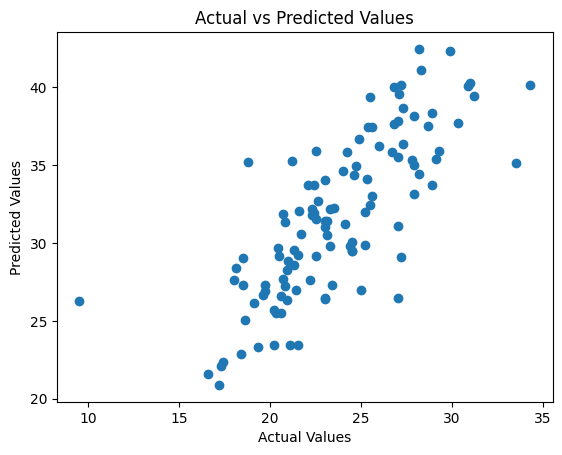

In [11]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Defining the model as an object of MLPRegressor()
mlp_model = MLPRegressor(hidden_layer_sizes = (18,), activation='identity', solver='lbfgs', alpha = 0.0001, max_iter = 100, shuffle=True)

# Different combinations of hyperparameter values
param_grid = {'alpha': [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100, 1000], 
              'activation': ['identity', 'logistic', 'tanh', 'relu'],
              'solver': ['lbfgs', 'sgd', 'adam'],
              'learning_rate': ['constant', 'adaptive', 'invscaling'],
              'hidden_layer_sizes': [(10,),(11,),(12,),(13,),(14,),(15,),(16,)],
              }

# Grid Search
grid = GridSearchCV(mlp_model, param_grid, refit = True, verbose = 3, scoring='neg_mean_squared_error')

# Fitting the model on the scaled training data
grid.fit(X_train_scaled, y_train)

# Getting the MSE score
print('Testing accuracy (Train): ', grid.score(X_train_scaled, y_train))
print('Validation Accuracy (Train): ', grid.best_score_)

# Getting the MSE score on test set
print('Testing accuracy (Test): ', grid.score(X_test_scaled, y_test))

# Predicted values for training data
y_pred_train = grid.predict(X=X_train_scaled)

# Predicted values for test data
y_pred_test = grid.predict(X=X_test_scaled)
print('Test MSE: {0:0.4f}'. format(mean_squared_error(y_test, y_pred_test)))
print('Test R^2: {0:0.4f}'. format(r2_score(y_test, y_pred_test)))
print("Best parameters: ", grid.best_params_)

# Create scatter plot of actual vs predicted values for test set
plt.scatter(y_test, y_pred_test)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

KNN

**Final Results**
MSE: 8.32
R2: -3.76

Best parameters:  {'algorithm': 'brute', 'n_neighbors': 7, 'weights': 'uniform'}
Best score:  0.4316920401138072
MSE:  8.323471209912535
R2:  -3.7674340043029924


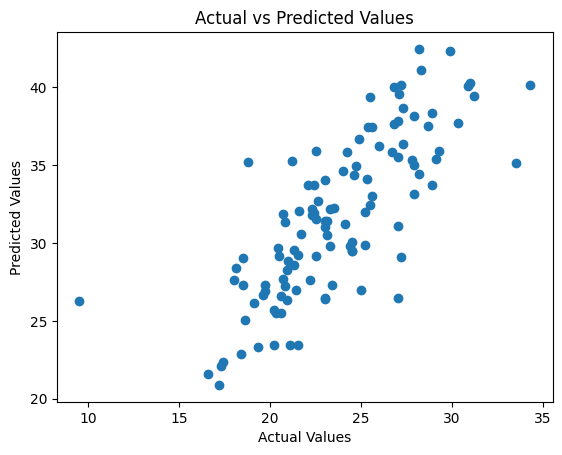

In [21]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

# Define the KNN model
knn_model = KNeighborsRegressor()

# Parameter grid, used to look for number of neighbours, different weights, and different algorithms
param_grid = {'n_neighbors': [1,2,3,4, 5,6, 7],
              'weights': ['uniform', 'distance'],
              'algorithm': ['brute', 'ball_tree', 'kd_tree', 'auto']}

# Define the grid search object and fit the data
grid = GridSearchCV(knn_model, param_grid, cv=5)
grid.fit(X_train_scaled, y_train)

#Outputs the best parameters
print("Best parameters: ", grid.best_params_)
print("Best score: ", grid.best_score_)

# Creates predictions from test data which will be used later on
y_pred = grid.predict(X_test_scaled)

# Calculate the mean squared error on the test data
mse = mean_squared_error(y_test, y_pred)
print("MSE: ", mse)
r2 = r2_score(y_test, y_pred_test)
print("R2: ", r2)

#Plots everything
plt.scatter(y_test, y_pred_test)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()
